<a href="https://colab.research.google.com/github/soulsharp/AutoCoco/blob/main/AutoCoco2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install efficientnet_pytorch
!pip install timm

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from PIL import Image
from torch import nn, optim
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import timm
import time

In [ ]:
# assigns gpu as primary device, if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Class folders
class_folders = ["Bud Root Drooping", "Bud Rot", "Gray Leaf Spot", "Leaf Rot", "Stem Bleeding"]
class_folders = [folder for folder in class_folders if folder not in [".ipynb_checkpoints", ".config", "sample_data"]]


In [ ]:
!rm -R /content/.ipynb_checkpoints
!ls /content/ -a   #to make sure that the deletion has occurred

 .   'Bud Root Dropping'   .config	    'Leaf Rot'	  'Stem Bleeding'
 ..  'Bud Rot'		  'Gray Leaf Spot'   sample_data


In [ ]:
!rm -R /content/.config

In [ ]:
!ls /content/ -a

 .   'Bud Root Dropping'  'Gray Leaf Spot'   sample_data
 ..  'Bud Rot'		  'Leaf Rot'	    'Stem Bleeding'


In [ ]:
!rm -R /content/sample_data

In [ ]:
!ls /content/ -a

 .   ..  'Bud Root Dropping'  'Bud Rot'  'Gray Leaf Spot'  'Leaf Rot'  'Stem Bleeding'


In [ ]:
root_dir = "/content"
filtered_root = "/dataset"
exclude_dirs = [".ipynb_checkpoints", ".config"]
if not os.path.exists(filtered_root):
    os.makedirs(filtered_root)

# Moves only the relevant class folders
for class_folder in os.listdir(root_dir):
    if class_folder not in exclude_dirs and os.path.isdir(os.path.join(root_dir, class_folder)):
        destination_path = os.path.join(filtered_root, class_folder)

        # Checks if the destination directory already exists
        if not os.path.exists(destination_path):
            shutil.copytree(os.path.join(root_dir, class_folder), destination_path)


In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
image_transform_for_swin = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
dataset = datasets.ImageFolder(root=root_dir, transform=image_transform)

In [ ]:
dataset_swin = datasets.ImageFolder(root=root_dir, transform=image_transform_for_swin)

In [ ]:
dataset.class_to_idx.items()

dict_items([('Bud Root Dropping', 0), ('Bud Rot', 1), ('Gray Leaf Spot', 2), ('Leaf Rot', 3), ('Stem Bleeding', 4)])

In [ ]:
len(dataset), len(dataset.targets)

(757, 757)

In [ ]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset_swin, val_dataset_swin = random_split(dataset_swin, [train_size, val_size])

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Flattens the tensor for the linear layer
        _, channels, height, width = self._get_dummy_output_shape()
        self.fc_input_size = channels * height * width

        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )


    def forward(self, x):
        for layer in self.features:
            x = layer(x)

        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        return logits

         # During training, calculates probabilities using softmax
        if self.training:
            probabilities = nn.functional.softmax(logits, dim=1)
            return probabilities
        else:
            # During inference, returns the class index with the highest probability
            _, predicted_labels = torch.max(logits, 1)
            return predicted_labels


    def _get_dummy_output_shape(self):
        # Helper function to get the output shape
        test_tensor = torch.randn(1, 3, 256, 256)
        for layer in self.features:
            test_tensor = layer(test_tensor)
        return test_tensor.size()

In [ ]:
def plot_metrics(epochs, train_values, val_values, y_label, title):
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_values, label=f'Training {y_label}')
    plt.plot(epochs, val_values, label=f'Validation {y_label}')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def plot_precision_recall_curve(y_true, y_pred, num_classes):
    precision = [precision_score(y_true, y_pred, average='micro')]
    recall = [recall_score(y_true, y_pred, average='micro')]

    for class_idx in range(num_classes):
        precision.append(precision_score(y_true == class_idx, y_pred == class_idx))
        recall.append(recall_score(y_true == class_idx, y_pred == class_idx))

    plt.figure(figsize=(12, 6))
    plt.bar(range(num_classes + 1), precision, color='blue', alpha=0.7, label='Precision')
    plt.bar(range(num_classes + 1), recall, color='green', alpha=0.7, label='Recall')
    plt.xticks(range(num_classes + 1), ['Overall'] + class_folders, rotation=45)

In [ ]:
# bar_graph for precision and recall
def plot_bar_precision_recall(val_precision, val_recall, class_folders):
        x = np.arange(len(class_folders))
        width = 0.35

        plt.figure(figsize=(12, 6))
        plt.bar(x - width/2, val_precision, width, label='Precision')
        plt.bar(x + width/2, val_recall, width, label='Recall')
        plt.xlabel('Classes')
        plt.ylabel('Score')
        plt.title('Precision and Recall by Class')
        plt.xticks(x, class_folders)
        plt.legend()
        plt.show()


In [ ]:
# calculates accuracy, precision, recall and f1_score given predicted and true labels
def calculate_metrics(true_labels, predictions):
          accuracy = accuracy_score(true_labels, predictions)
          precision = precision_score(true_labels, predictions, average=None)
          recall = recall_score(true_labels, predictions, average=None)
          f1_val = f1_score(true_labels, predictions, average=None)
          return accuracy, precision, recall, f1_val

In [ ]:
def plot_training_validation_loss(train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, f1_list, num_epochs):
      # Plots
      plt.figure(figsize=(12, 6))
      # plt.subplot(1, 2, 1)
      # plt.plot(range(1, num_epochs+1), train_loss_list, label='Training Loss')
      # plt.plot(range(1, num_epochs+1), val_loss_list, label='Validation Loss')
      # plt.xlabel('Epochs')
      # plt.ylabel('Loss')
      # plt.legend()

      # plt.subplot(1, 2, 2)
      plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Training Accuracy')
      plt.plot(range(1, num_epochs+1), val_accuracy_list, label='Validation Accuracy')
      plt.plot(range(1, num_epochs+1), f1_list, label='F1 Score')
      plt.xlabel('Epochs')
      plt.ylabel('Score')
      plt.legend()

      plt.show()


# **TRAIN ACCURACY METRICS**







In [ ]:
# Training Loop to get accuracy plots
def train_accuracy_metrics(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5):
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_idx, (data, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Track true labels and predictions for metrics calculation
            predictions.extend(torch.argmax(outputs, dim=1).device().numpy())
            true_labels.extend(labels.cpu().device())

            if batch_idx % 10 == 0:
                print(f'Train Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')

        # Calculates training accuracy
        train_accuracy = accuracy_score(true_labels, predictions)
        train_accuracy_list.append(train_accuracy)
        train_loss = running_loss / len(train_dataloader)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        running_loss_val = 0.0
        predictions_val = []
        true_labels_val = []

        with torch.no_grad():
            for data_val, labels_val in val_dataloader:
                data_val, labels_val = data_val.to(device), labels_val.to(device)
                outputs_val = model(data_val)
                loss_val = criterion(outputs_val, labels_val)
                running_loss_val += loss_val.item()

                # Tracks true labels and predictions for metrics calculation
                predictions_val.extend(torch.argmax(outputs_val, dim=1).cpu().numpy())
                true_labels_val.extend(labels_val.cpu().numpy())

        # Calculates validation accuracy
        val_accuracy = accuracy_score(true_labels_val, predictions_val)
        val_accuracy_list.append(val_accuracy)
        val_loss = running_loss_val / len(val_dataloader)
        val_loss_list.append(val_loss)

        # Calculates F1 score
        f1 = f1_score(true_labels_val, predictions_val, average='weighted')
        f1_list.append(f1)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, F1 Score: {f1:.4f}')

    # Plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_loss_list, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracy_list, label='Validation Accuracy')
    plt.plot(range(1, num_epochs+1), f1_list, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.show()

# **TRAIN LOGIC**

In [ ]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5):
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_val_loss = 0.0
        predictions = []
        true_labels = []

        for batch_idx, (data, labels) in enumerate(train_dataloader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Tracks true labels and predictions for metrics calculation
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f'Train Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')

        # Appends training loss for plotting
        train_loss_list.append(running_loss / len(train_dataloader))

        # Calculates training accuracy
        train_accuracy = accuracy_score(true_labels, predictions)
        train_accuracy_list.append(train_accuracy)

        # Validation Metrics Calculation
        model.eval()
        all_predictions_val = []
        all_true_labels_val = []
        total_time = 0.0

        tic = time.time()
        with torch.no_grad():
            for data_val, labels_val in val_dataloader:
                data_val, labels_val = data_val.to(device), labels_val.to(device)
                outputs_val = model(data_val)
                predictions_val = torch.argmax(outputs_val, dim=1).cpu().numpy()
                true_labels_val = labels_val.cpu().numpy()

                # Calculates validation loss
                val_loss = criterion(outputs_val, labels_val)
                running_val_loss += val_loss
                all_predictions_val.extend(predictions_val)
                all_true_labels_val.extend(true_labels_val)
        toc = time.time()
        total_time+= (toc-tic)*1000
        val_loss_list.append(running_val_loss/ len(val_dataloader))

        # Calculate metrics
        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(all_true_labels_val, all_predictions_val)

        # Plots the confusion matrix
        plot_confusion_matrix(all_true_labels_val, all_predictions_val, class_folders)

        # Plots bar graphs for precision and recall
        plot_bar_precision_recall(val_precision, val_recall, class_folders)

        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        print('Class-wise Metrics:')
        for i, class_name in enumerate(class_folders):
            print(f'Class: {class_name}, Precision: {val_precision[i]:.4f}, Recall: {val_recall[i]:.4f}, F1 Score: {val_f1[i]:.4f}')

        # Appends validation metrics for plotting
        val_loss_list.append(val_loss/ len(val_dataloader))
        val_accuracy_list.append(val_accuracy)
        f1_list.append(np.mean(val_f1))

    # Plots training, validation
    plot_training_validation_loss(train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, f1_list, num_epochs)
    print(f"Total time taken for batched inference = {total_time} ms")


In [ ]:
# Some hyperparameters
batch_size = 16
lr = 1e-3
num_epochs = 5

In [ ]:
model = CustomModel(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size, shuffle=False)

In [ ]:
train_dataloader_swin = DataLoader(train_dataset_swin, batch_size=batch_size, shuffle=True)
val_dataloader_swin = DataLoader(val_dataset_swin, batch_size=batch_size, shuffle=True)

Train Epoch 1/5, Batch 1/38, Loss: 0.2878
Train Epoch 1/5, Batch 11/38, Loss: 0.1741
Train Epoch 1/5, Batch 21/38, Loss: 0.2069
Train Epoch 1/5, Batch 31/38, Loss: 0.5224


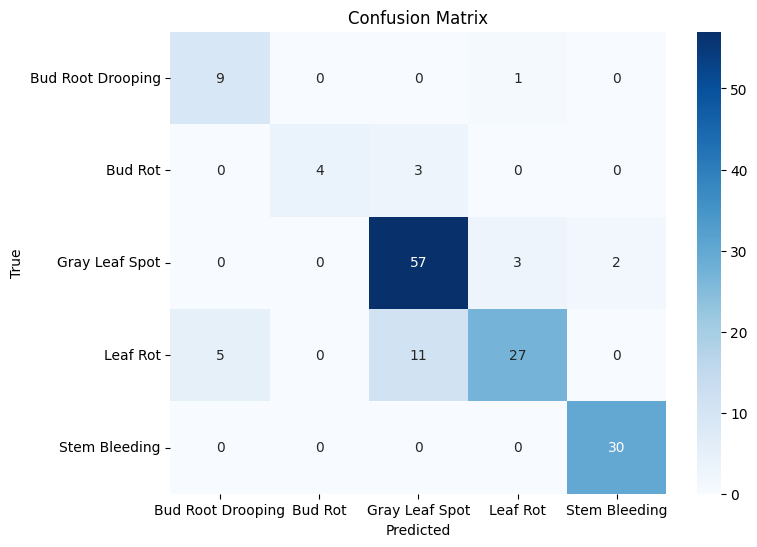

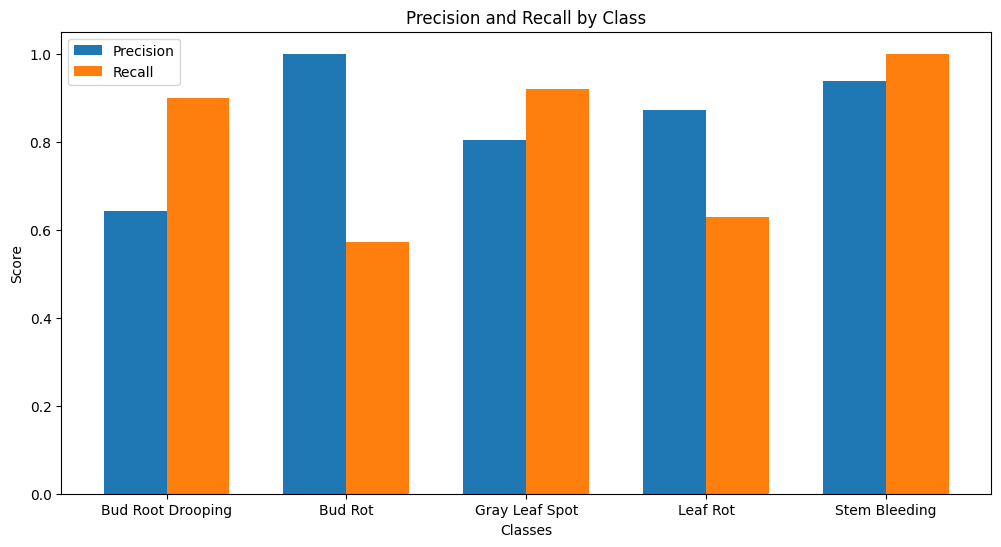

Epoch 1/5, Training Loss: 0.2426, Validation Accuracy: 0.8355
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.6429, Recall: 0.9000, F1 Score: 0.7500
Class: Bud Rot, Precision: 1.0000, Recall: 0.5714, F1 Score: 0.7273
Class: Gray Leaf Spot, Precision: 0.8028, Recall: 0.9194, F1 Score: 0.8571
Class: Leaf Rot, Precision: 0.8710, Recall: 0.6279, F1 Score: 0.7297
Class: Stem Bleeding, Precision: 0.9375, Recall: 1.0000, F1 Score: 0.9677
Train Epoch 2/5, Batch 1/38, Loss: 0.2191
Train Epoch 2/5, Batch 11/38, Loss: 0.2479
Train Epoch 2/5, Batch 21/38, Loss: 0.2530
Train Epoch 2/5, Batch 31/38, Loss: 0.1366


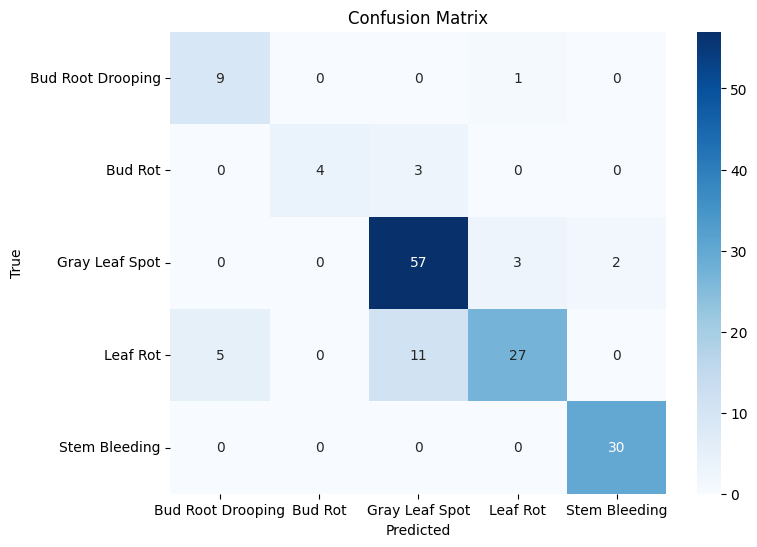

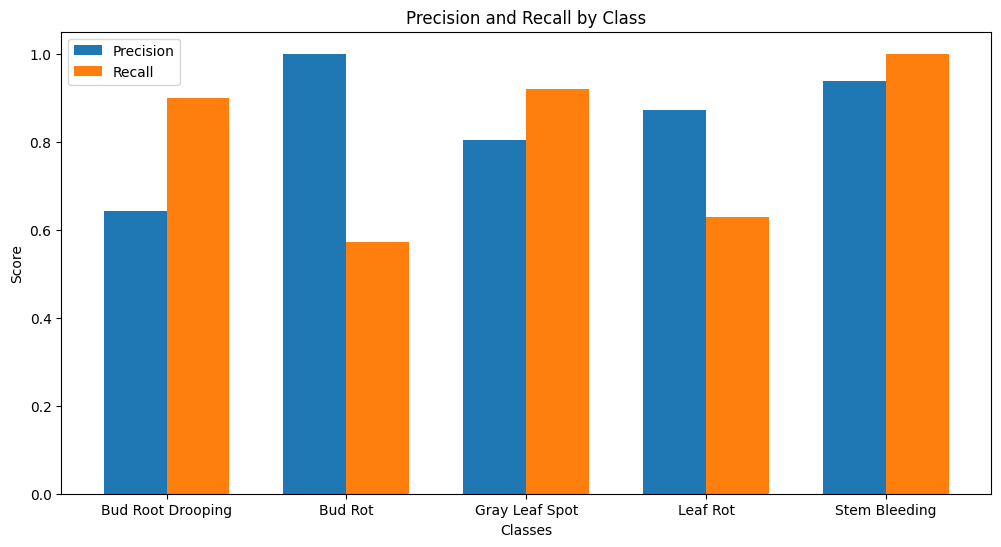

Epoch 2/5, Training Loss: 0.2425, Validation Accuracy: 0.8355
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.6429, Recall: 0.9000, F1 Score: 0.7500
Class: Bud Rot, Precision: 1.0000, Recall: 0.5714, F1 Score: 0.7273
Class: Gray Leaf Spot, Precision: 0.8028, Recall: 0.9194, F1 Score: 0.8571
Class: Leaf Rot, Precision: 0.8710, Recall: 0.6279, F1 Score: 0.7297
Class: Stem Bleeding, Precision: 0.9375, Recall: 1.0000, F1 Score: 0.9677
Train Epoch 3/5, Batch 1/38, Loss: 0.2935
Train Epoch 3/5, Batch 11/38, Loss: 0.2070
Train Epoch 3/5, Batch 21/38, Loss: 0.2083
Train Epoch 3/5, Batch 31/38, Loss: 0.1002


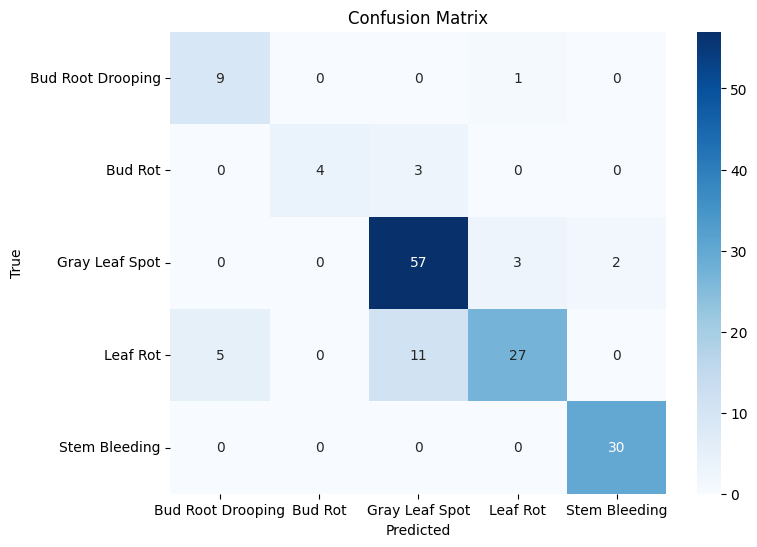

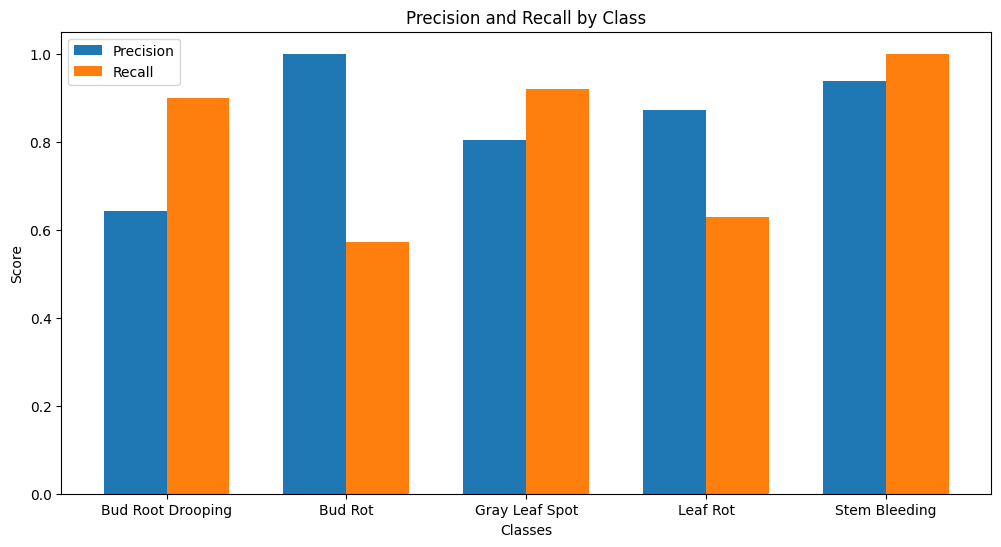

Epoch 3/5, Training Loss: 0.2429, Validation Accuracy: 0.8355
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.6429, Recall: 0.9000, F1 Score: 0.7500
Class: Bud Rot, Precision: 1.0000, Recall: 0.5714, F1 Score: 0.7273
Class: Gray Leaf Spot, Precision: 0.8028, Recall: 0.9194, F1 Score: 0.8571
Class: Leaf Rot, Precision: 0.8710, Recall: 0.6279, F1 Score: 0.7297
Class: Stem Bleeding, Precision: 0.9375, Recall: 1.0000, F1 Score: 0.9677
Train Epoch 4/5, Batch 1/38, Loss: 0.3050
Train Epoch 4/5, Batch 11/38, Loss: 0.2987
Train Epoch 4/5, Batch 21/38, Loss: 0.1243
Train Epoch 4/5, Batch 31/38, Loss: 0.2023


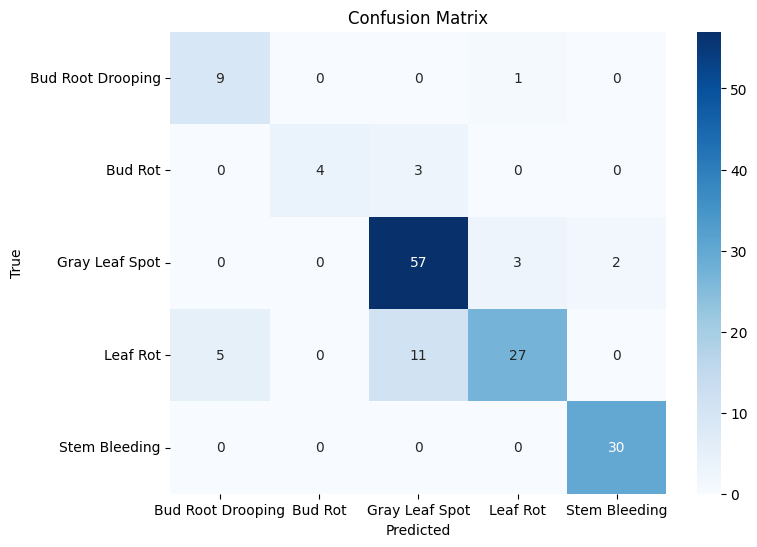

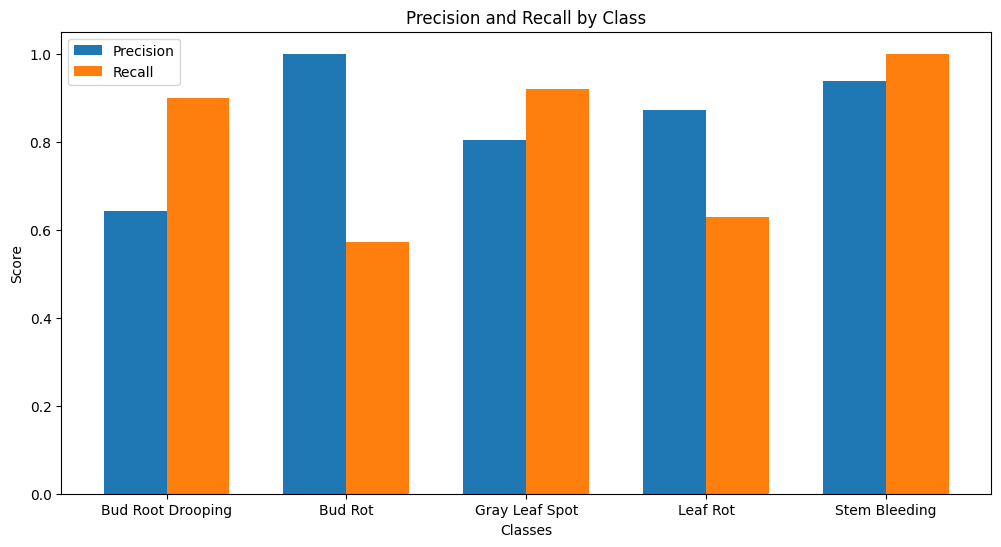

Epoch 4/5, Training Loss: 0.2434, Validation Accuracy: 0.8355
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.6429, Recall: 0.9000, F1 Score: 0.7500
Class: Bud Rot, Precision: 1.0000, Recall: 0.5714, F1 Score: 0.7273
Class: Gray Leaf Spot, Precision: 0.8028, Recall: 0.9194, F1 Score: 0.8571
Class: Leaf Rot, Precision: 0.8710, Recall: 0.6279, F1 Score: 0.7297
Class: Stem Bleeding, Precision: 0.9375, Recall: 1.0000, F1 Score: 0.9677
Train Epoch 5/5, Batch 1/38, Loss: 0.2516
Train Epoch 5/5, Batch 11/38, Loss: 0.2114
Train Epoch 5/5, Batch 21/38, Loss: 0.1216
Train Epoch 5/5, Batch 31/38, Loss: 0.2548


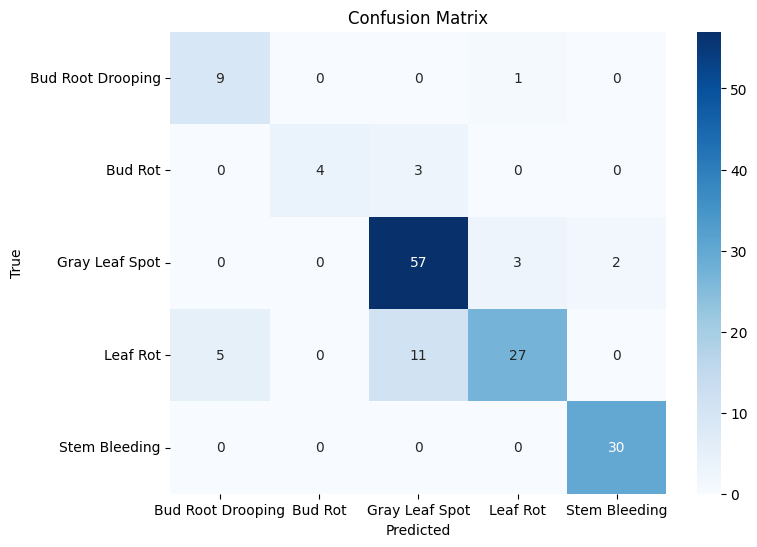

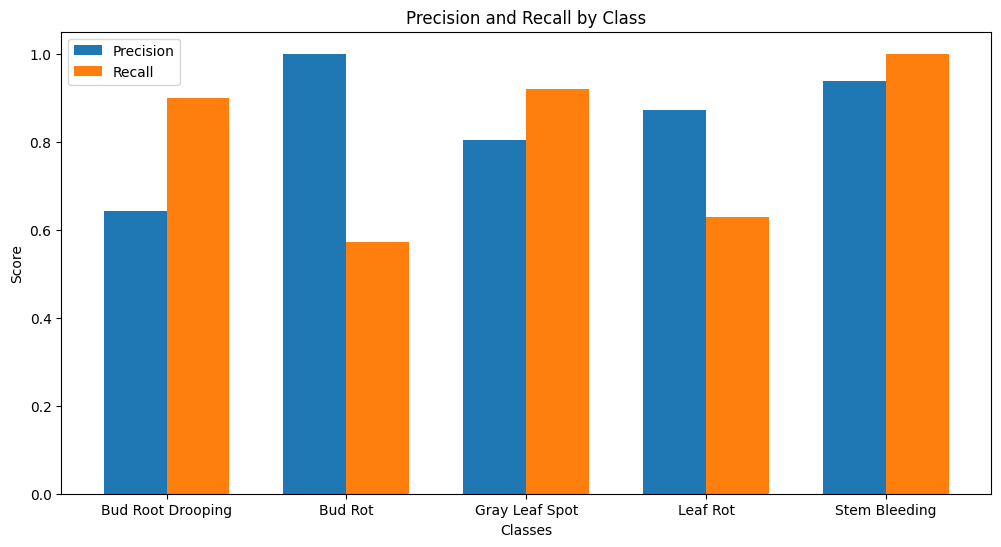

Epoch 5/5, Training Loss: 0.2428, Validation Accuracy: 0.8355
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.6429, Recall: 0.9000, F1 Score: 0.7500
Class: Bud Rot, Precision: 1.0000, Recall: 0.5714, F1 Score: 0.7273
Class: Gray Leaf Spot, Precision: 0.8028, Recall: 0.9194, F1 Score: 0.8571
Class: Leaf Rot, Precision: 0.8710, Recall: 0.6279, F1 Score: 0.7297
Class: Stem Bleeding, Precision: 0.9375, Recall: 1.0000, F1 Score: 0.9677


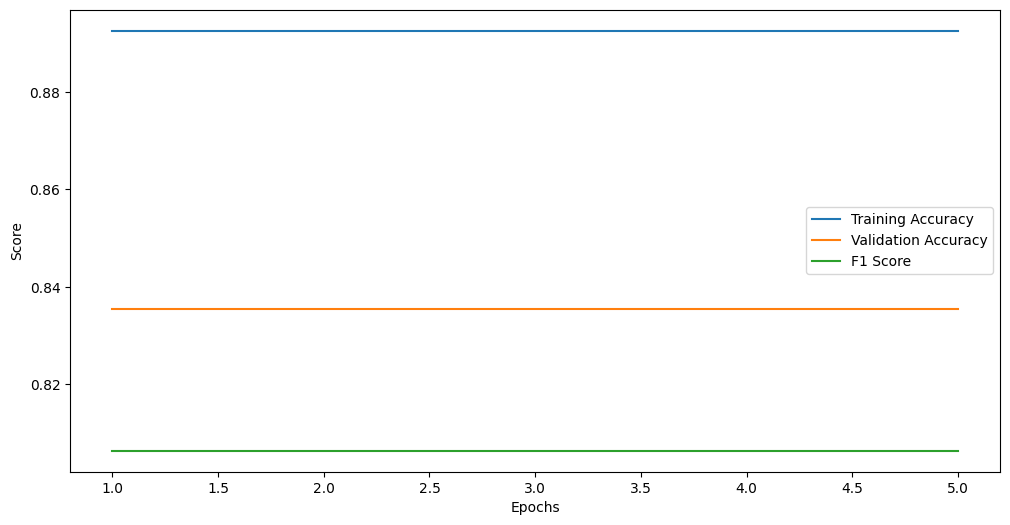

Total time taken for batched inference = 1552.4635314941406 ms


In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)


In [ ]:
# train_accuracy_metrics(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5)

In [ ]:
mobilenet_v2 = models.mobilenet_v2(pretrained=True).to(device)

# Modifies the last layer
num_classes = len(class_folders)
mobilenet_v2.classifier[-1] = nn.Linear(mobilenet_v2.classifier[-1].in_features, num_classes)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Defines criterion, optimizer, and other parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.parameters(), lr=0.001)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 76.5MB/s]


In [ ]:
# train(mobilenet_v2, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

In [ ]:
class CustomEffNetV2Model(nn.Module):
    def __init__(self, num_classes):
        super(CustomEffNetV2Model, self).__init__()
        self.effnet = timm.create_model('tf_efficientnetv2_b2', pretrained=True, num_classes=0, global_pool='avg')

        # Modifies the classifier
        self.classifier = nn.Linear(self.effnet.num_features, num_classes)

    def forward(self, x):
        x = self.effnet(x)
        x = self.classifier(x)
        return x



Train Epoch 1/5, Batch 1/38, Loss: 1.5936
Train Epoch 1/5, Batch 11/38, Loss: 0.1613
Train Epoch 1/5, Batch 21/38, Loss: 0.1420
Train Epoch 1/5, Batch 31/38, Loss: 0.0731


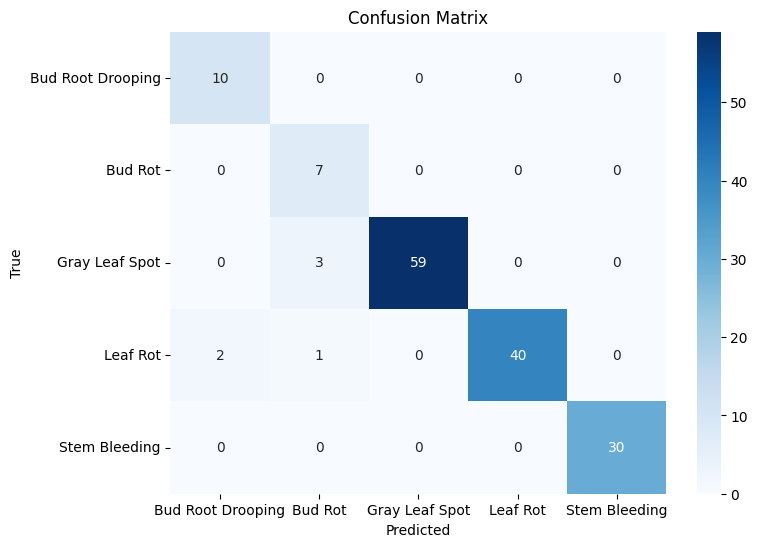

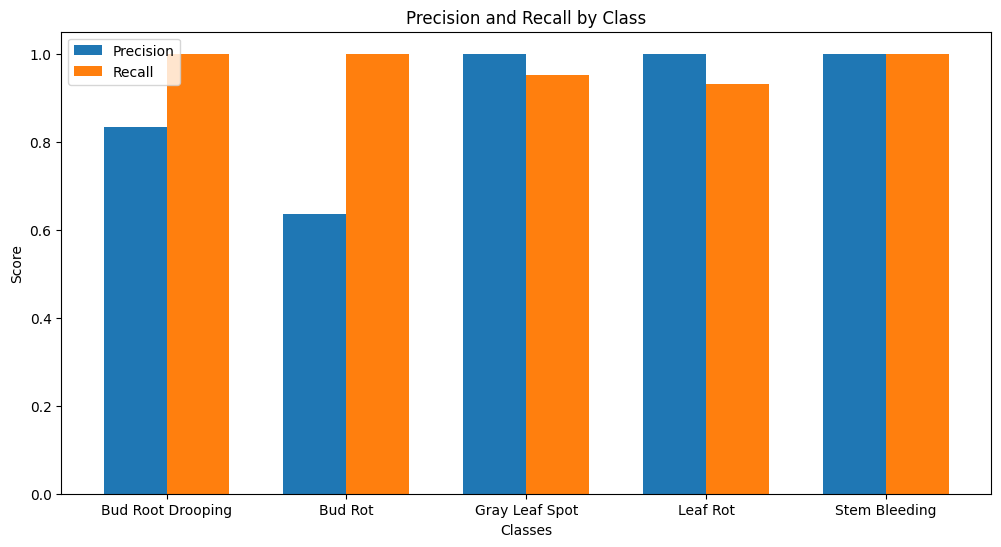

Epoch 1/5, Training Loss: 0.4119, Validation Accuracy: 0.9605
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.8333, Recall: 1.0000, F1 Score: 0.9091
Class: Bud Rot, Precision: 0.6364, Recall: 1.0000, F1 Score: 0.7778
Class: Gray Leaf Spot, Precision: 1.0000, Recall: 0.9516, F1 Score: 0.9752
Class: Leaf Rot, Precision: 1.0000, Recall: 0.9302, F1 Score: 0.9639
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 2/5, Batch 1/38, Loss: 0.1403
Train Epoch 2/5, Batch 11/38, Loss: 0.2111
Train Epoch 2/5, Batch 21/38, Loss: 0.0406
Train Epoch 2/5, Batch 31/38, Loss: 0.2542


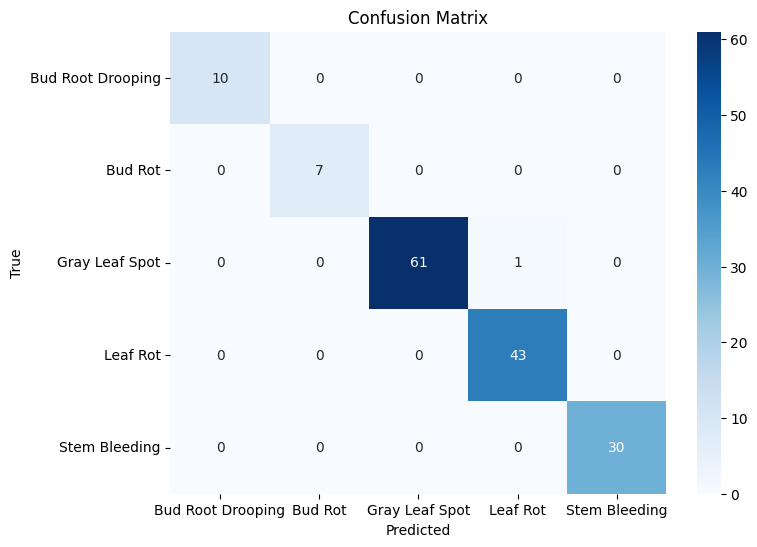

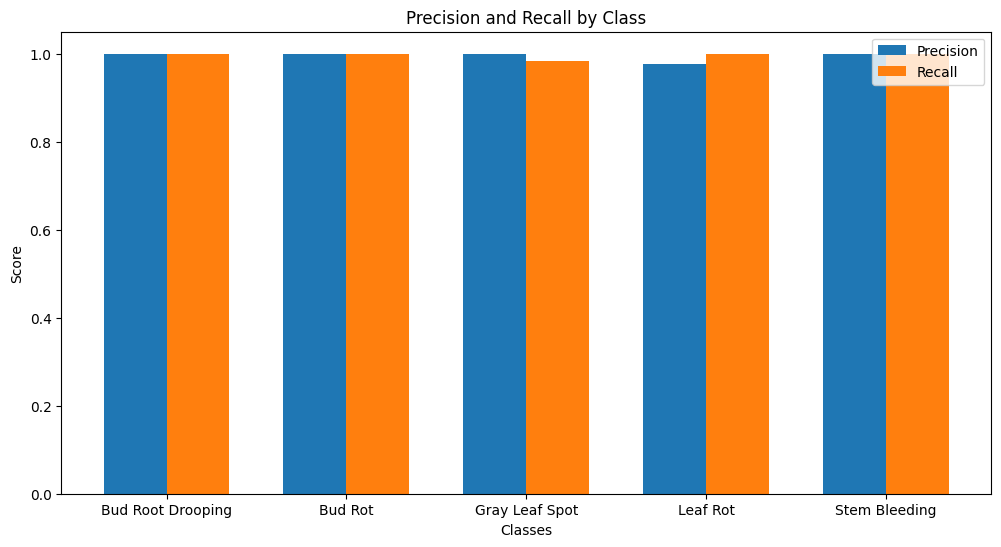

Epoch 2/5, Training Loss: 0.1756, Validation Accuracy: 0.9934
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Gray Leaf Spot, Precision: 1.0000, Recall: 0.9839, F1 Score: 0.9919
Class: Leaf Rot, Precision: 0.9773, Recall: 1.0000, F1 Score: 0.9885
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 3/5, Batch 1/38, Loss: 0.0291
Train Epoch 3/5, Batch 11/38, Loss: 0.0564
Train Epoch 3/5, Batch 21/38, Loss: 0.1140
Train Epoch 3/5, Batch 31/38, Loss: 0.0408


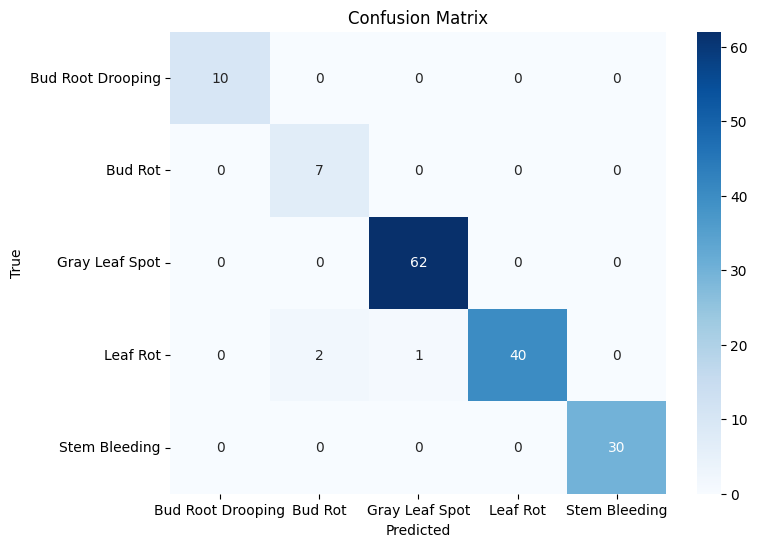

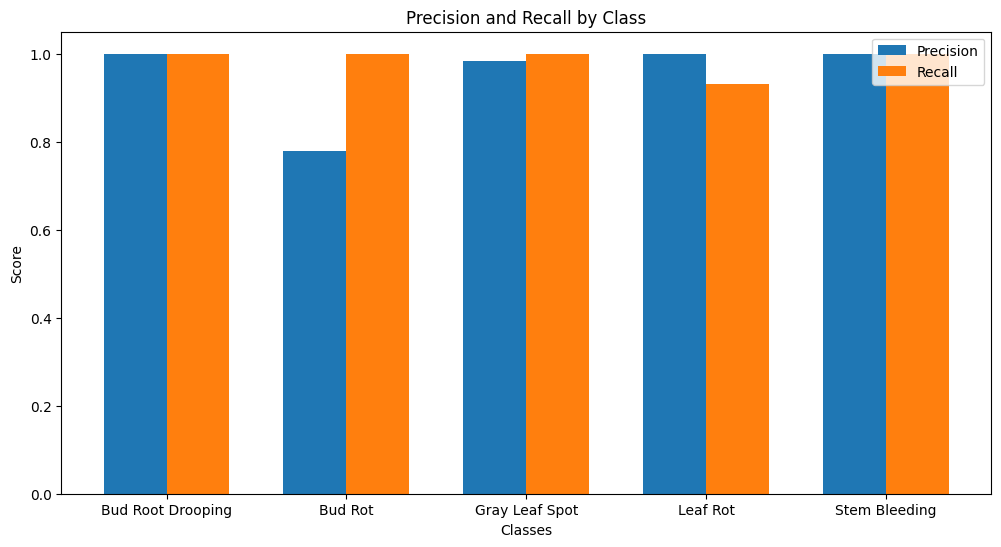

Epoch 3/5, Training Loss: 0.1367, Validation Accuracy: 0.9803
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 0.7778, Recall: 1.0000, F1 Score: 0.8750
Class: Gray Leaf Spot, Precision: 0.9841, Recall: 1.0000, F1 Score: 0.9920
Class: Leaf Rot, Precision: 1.0000, Recall: 0.9302, F1 Score: 0.9639
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 4/5, Batch 1/38, Loss: 0.0902
Train Epoch 4/5, Batch 11/38, Loss: 0.0200
Train Epoch 4/5, Batch 21/38, Loss: 0.0726
Train Epoch 4/5, Batch 31/38, Loss: 0.0096


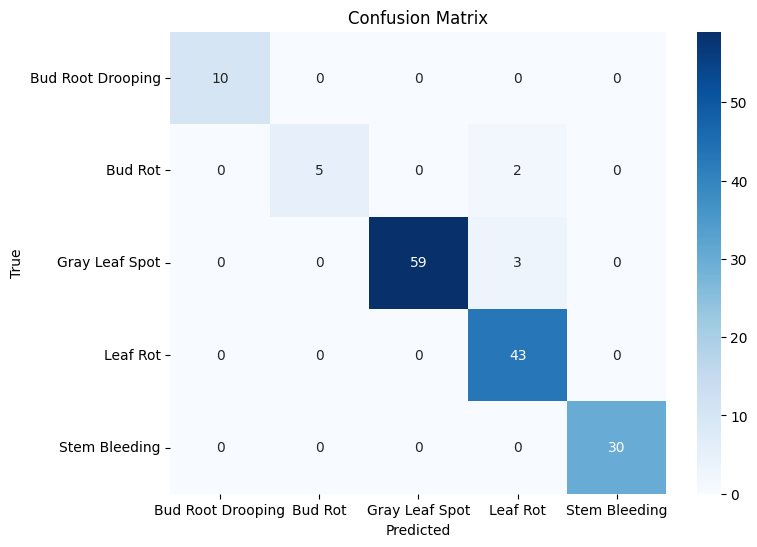

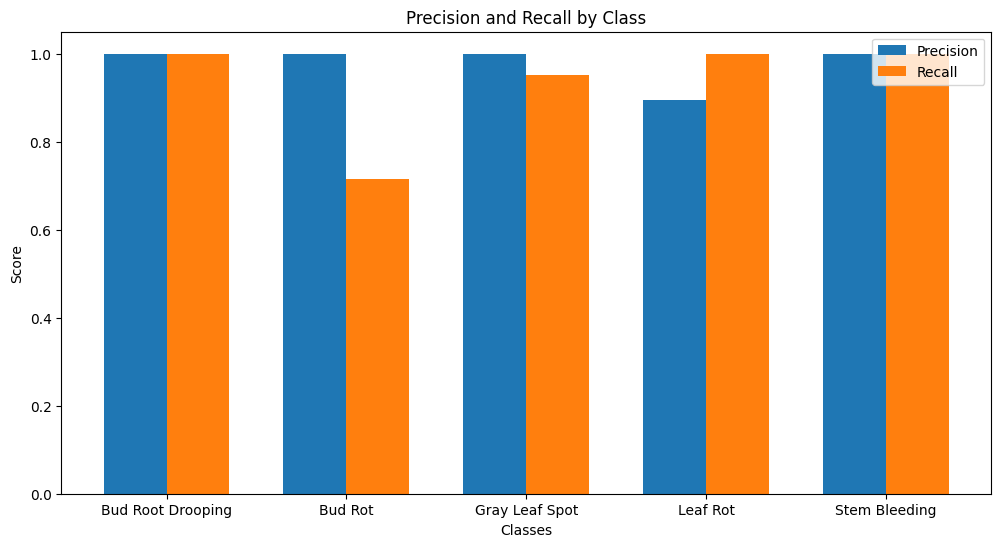

Epoch 4/5, Training Loss: 0.1131, Validation Accuracy: 0.9671
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 1.0000, Recall: 0.7143, F1 Score: 0.8333
Class: Gray Leaf Spot, Precision: 1.0000, Recall: 0.9516, F1 Score: 0.9752
Class: Leaf Rot, Precision: 0.8958, Recall: 1.0000, F1 Score: 0.9451
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 5/5, Batch 1/38, Loss: 0.2108
Train Epoch 5/5, Batch 11/38, Loss: 0.0176
Train Epoch 5/5, Batch 21/38, Loss: 0.0051
Train Epoch 5/5, Batch 31/38, Loss: 0.0780


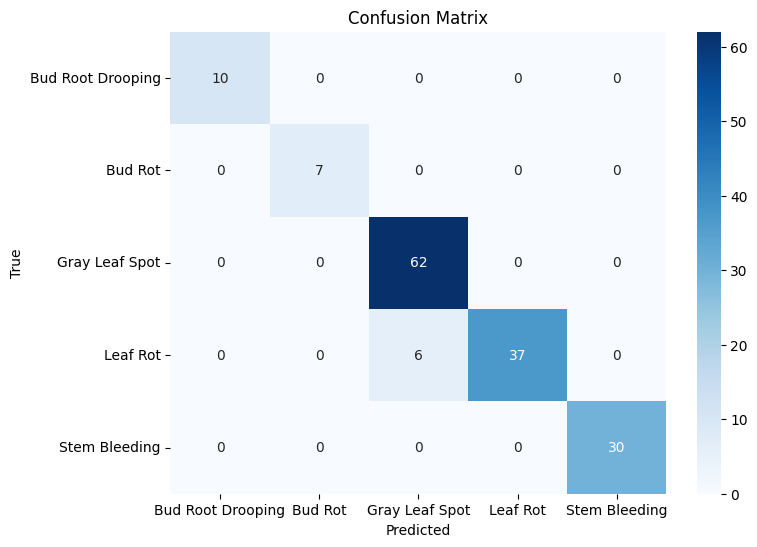

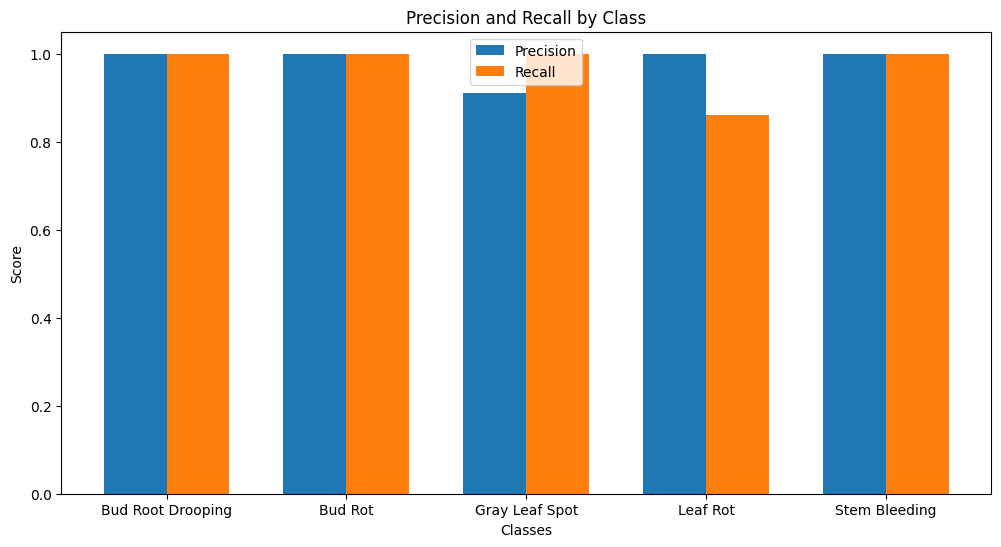

Epoch 5/5, Training Loss: 0.1097, Validation Accuracy: 0.9605
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Gray Leaf Spot, Precision: 0.9118, Recall: 1.0000, F1 Score: 0.9538
Class: Leaf Rot, Precision: 1.0000, Recall: 0.8605, F1 Score: 0.9250
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


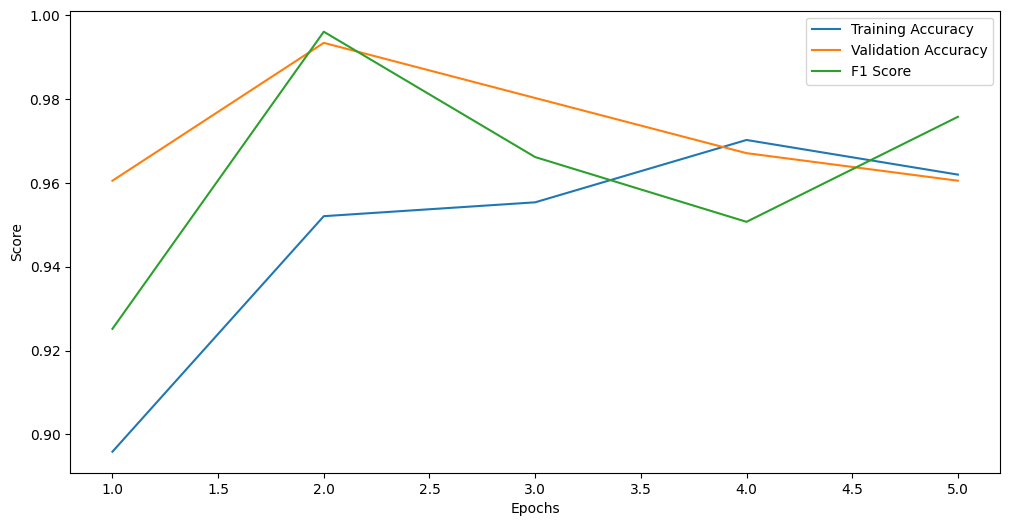

Total time taken for batched inference = 2440.3793811798096 ms


In [ ]:
effnet_model = CustomEffNetV2Model(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_model.parameters(), lr=1e-3)

train(effnet_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5)

Train Epoch 1/5, Batch 1/38, Loss: 1.6523
Train Epoch 1/5, Batch 11/38, Loss: 0.4760
Train Epoch 1/5, Batch 21/38, Loss: 0.2683
Train Epoch 1/5, Batch 31/38, Loss: 0.0821


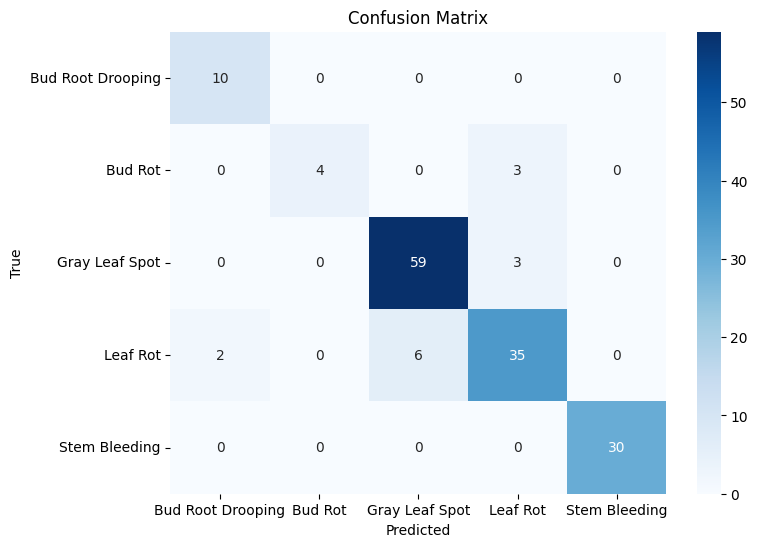

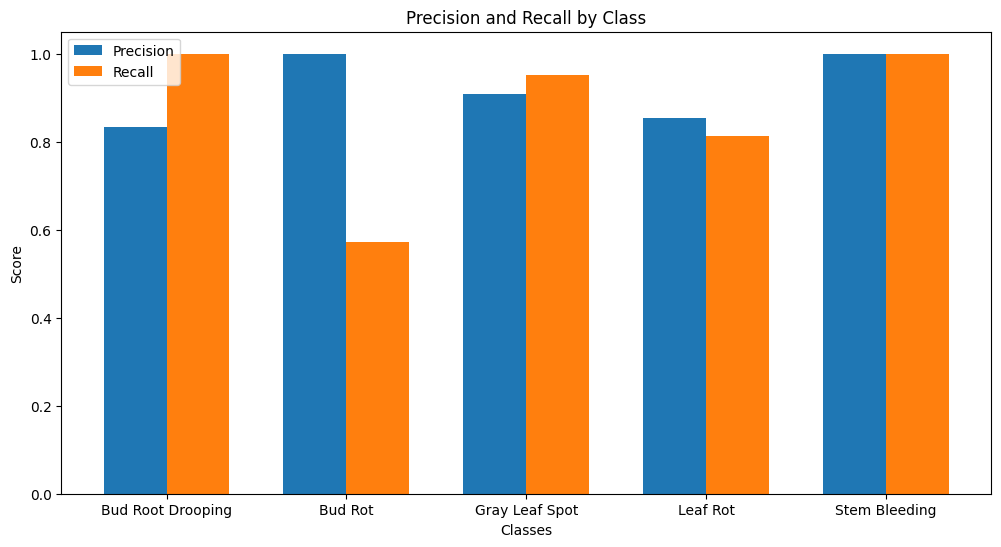

Epoch 1/5, Training Loss: 0.4532, Validation Accuracy: 0.9079
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.8333, Recall: 1.0000, F1 Score: 0.9091
Class: Bud Rot, Precision: 1.0000, Recall: 0.5714, F1 Score: 0.7273
Class: Gray Leaf Spot, Precision: 0.9077, Recall: 0.9516, F1 Score: 0.9291
Class: Leaf Rot, Precision: 0.8537, Recall: 0.8140, F1 Score: 0.8333
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 2/5, Batch 1/38, Loss: 0.3045
Train Epoch 2/5, Batch 11/38, Loss: 0.1576
Train Epoch 2/5, Batch 21/38, Loss: 0.0919
Train Epoch 2/5, Batch 31/38, Loss: 0.0074


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


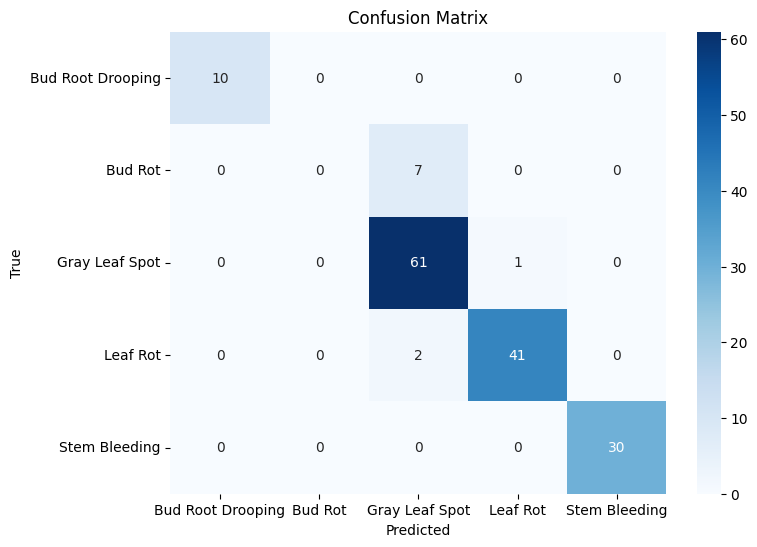

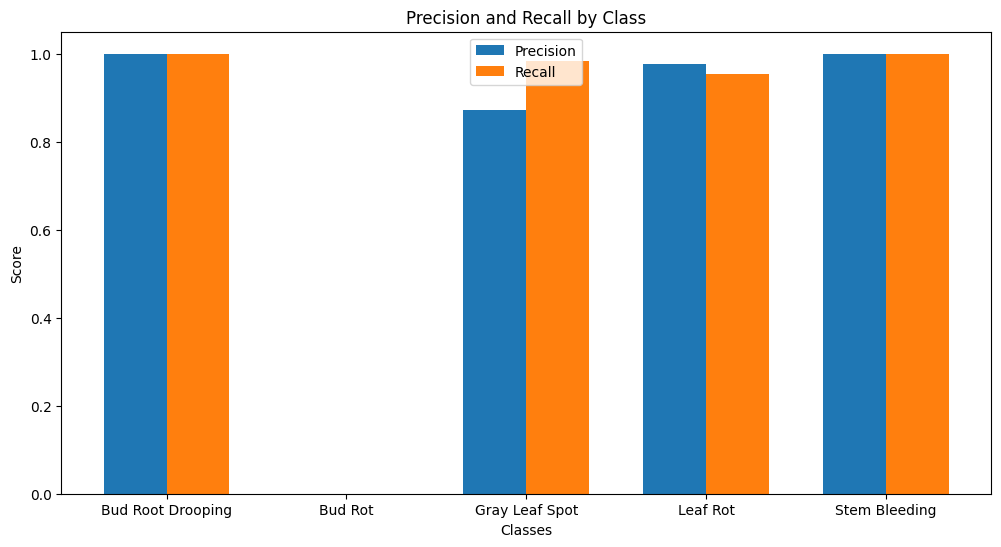

Epoch 2/5, Training Loss: 0.1612, Validation Accuracy: 0.9342
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.8714, Recall: 0.9839, F1 Score: 0.9242
Class: Leaf Rot, Precision: 0.9762, Recall: 0.9535, F1 Score: 0.9647
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 3/5, Batch 1/38, Loss: 0.0679
Train Epoch 3/5, Batch 11/38, Loss: 0.0494
Train Epoch 3/5, Batch 21/38, Loss: 0.0535
Train Epoch 3/5, Batch 31/38, Loss: 0.0105


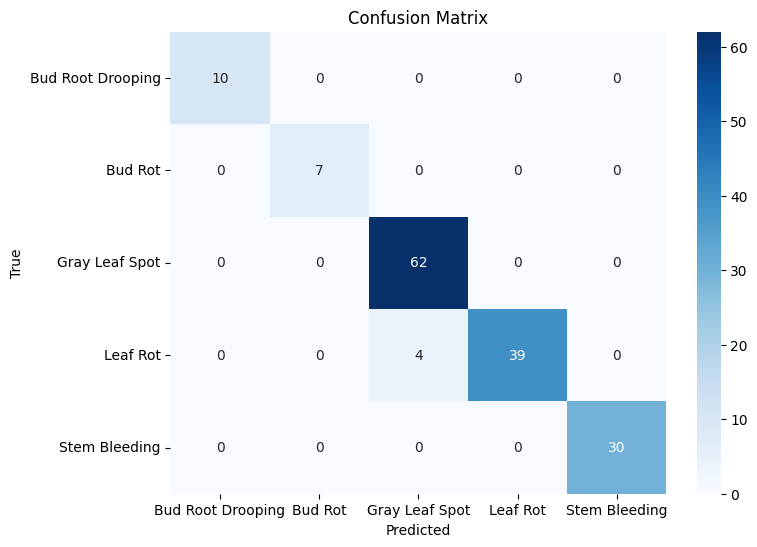

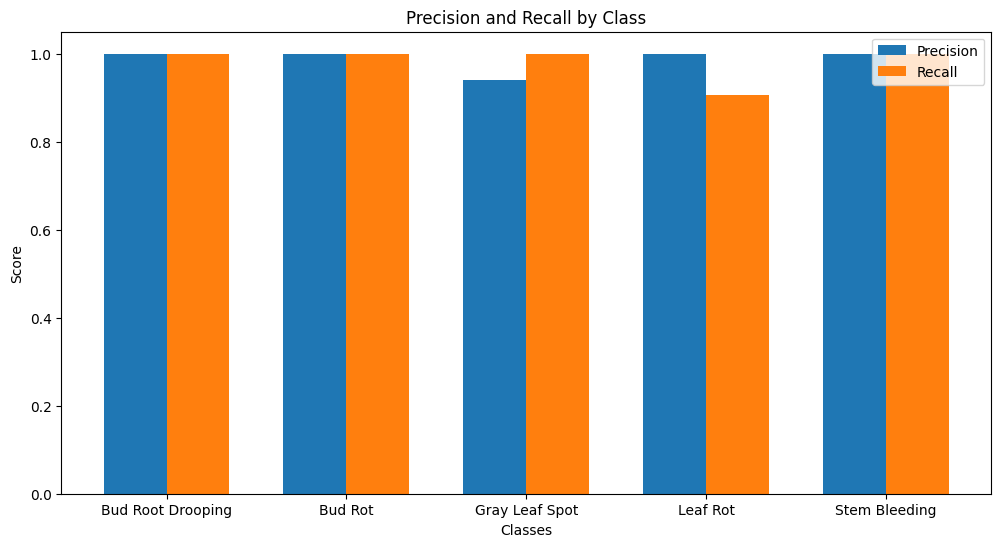

Epoch 3/5, Training Loss: 0.1300, Validation Accuracy: 0.9737
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Gray Leaf Spot, Precision: 0.9394, Recall: 1.0000, F1 Score: 0.9688
Class: Leaf Rot, Precision: 1.0000, Recall: 0.9070, F1 Score: 0.9512
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 4/5, Batch 1/38, Loss: 0.2491
Train Epoch 4/5, Batch 11/38, Loss: 0.0334
Train Epoch 4/5, Batch 21/38, Loss: 0.0686
Train Epoch 4/5, Batch 31/38, Loss: 0.0780


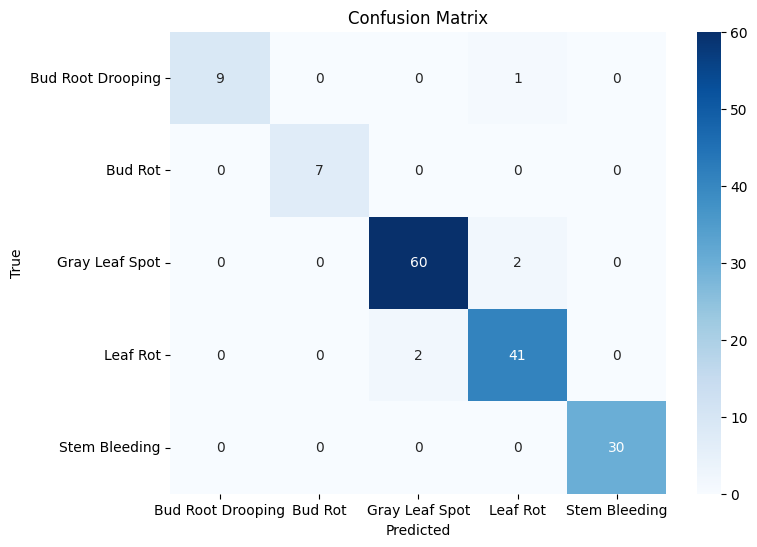

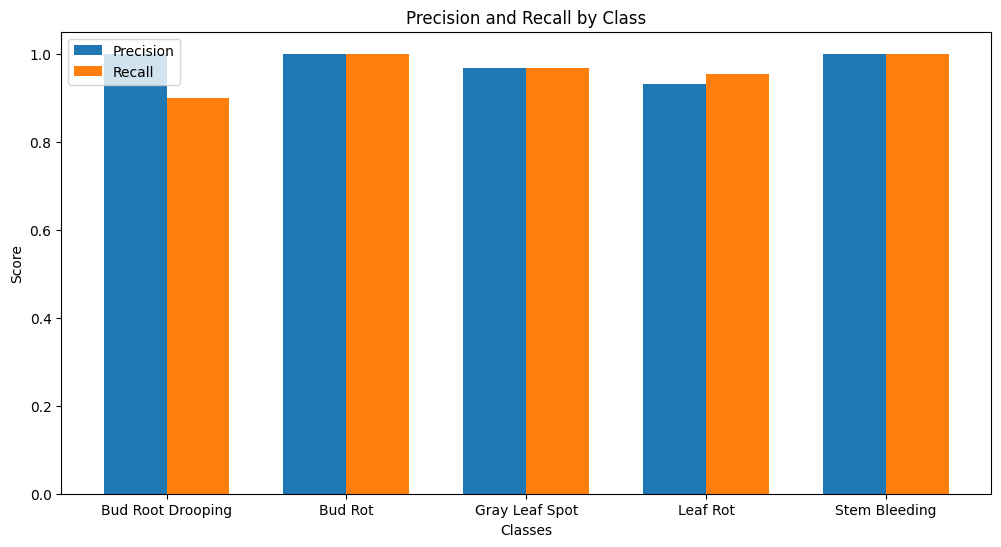

Epoch 4/5, Training Loss: 0.1224, Validation Accuracy: 0.9671
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9474
Class: Bud Rot, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Gray Leaf Spot, Precision: 0.9677, Recall: 0.9677, F1 Score: 0.9677
Class: Leaf Rot, Precision: 0.9318, Recall: 0.9535, F1 Score: 0.9425
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 5/5, Batch 1/38, Loss: 0.0025
Train Epoch 5/5, Batch 11/38, Loss: 0.1218
Train Epoch 5/5, Batch 21/38, Loss: 0.0187
Train Epoch 5/5, Batch 31/38, Loss: 0.0731


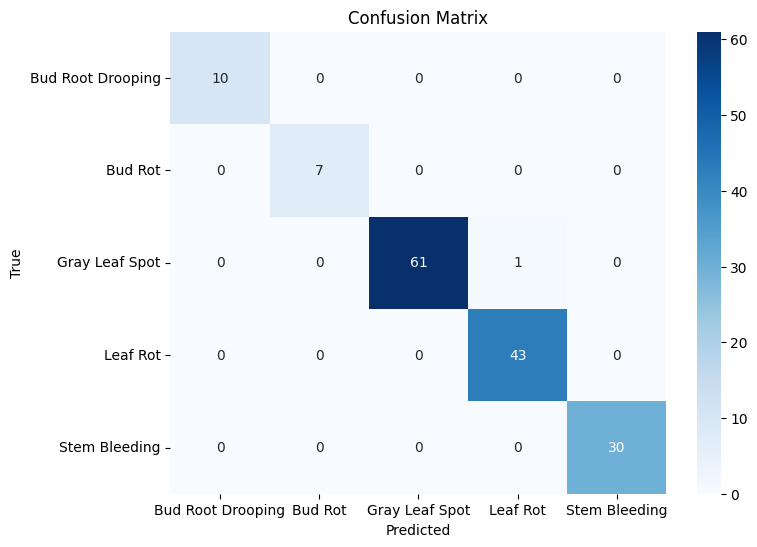

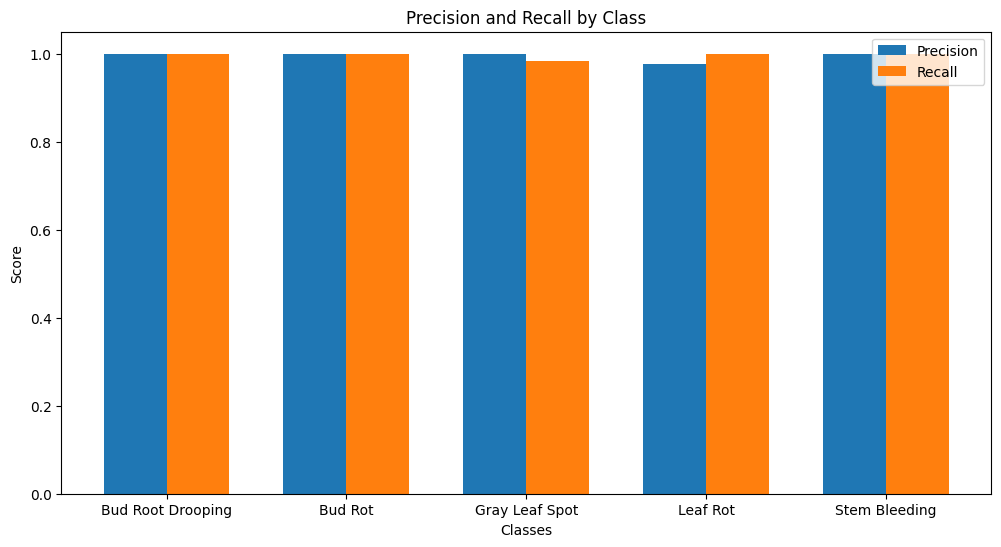

Epoch 5/5, Training Loss: 0.1044, Validation Accuracy: 0.9934
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Gray Leaf Spot, Precision: 1.0000, Recall: 0.9839, F1 Score: 0.9919
Class: Leaf Rot, Precision: 0.9773, Recall: 1.0000, F1 Score: 0.9885
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


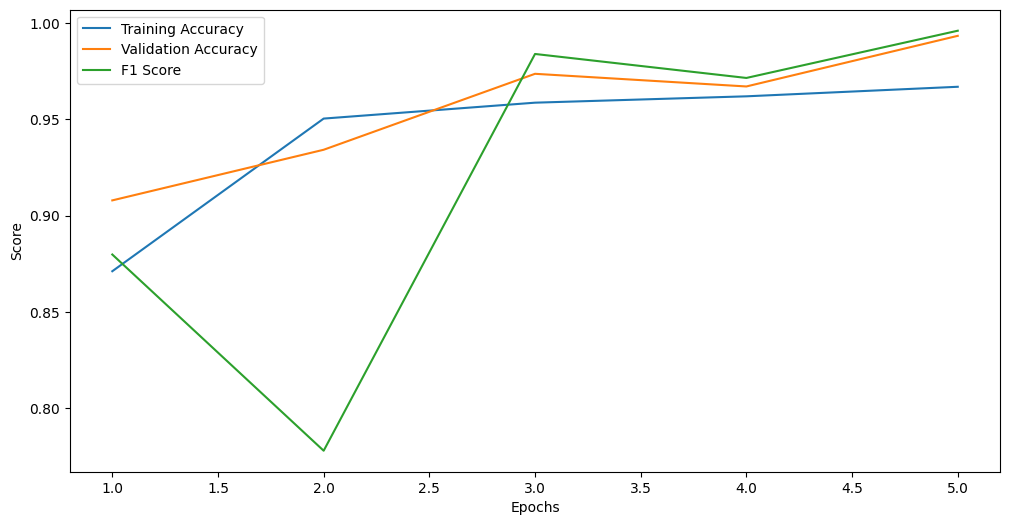

13609.756135940552 ms


In [ ]:
# tic = time.time()
# train(effnet_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)
# toc = time.time()
# print(f"{(toc-tic)*1000 /5 } ms")

In [ ]:
# # Comparison of inference times of models
# model.eval()
# mobilenet_v2.eval()
# effnet_model.eval()

# model_names = ['Custom', 'MobileNetV2', 'EfficientNetV2']
# avg_times = []
# for model in [model, mobilenet_v2, effnet_model]:
#     total_time = 0.0
#     num_samples = 0

#     # Iterates through the validation dataset with no gradient changes
#     with torch.no_grad():
#         for inputs, _ in val_dataloader:
#             # inputs = inputs.to(device)
#             # Measures inference time
#             start_time = time.time()
#             outputs = model(inputs)
#             end_time = time.time()

#             total_time += end_time - start_time
#             num_samples += len(inputs)

#     # Calculates average inference time per sample
#     avg_time_per_sample = total_time / num_samples
#     avg_times.append(avg_time_per_sample)

# # Plots the bar chart
# plt.bar(model_names, avg_times, color=['blue', 'orange', 'green'])
# plt.xlabel('Model')
# plt.ylabel('Average Inference Time per Sample (seconds)')
# plt.title('Comparison of Inference Times')
# plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch 1/5, Batch 1/38, Loss: 1.6400
Train Epoch 1/5, Batch 11/38, Loss: 0.0342
Train Epoch 1/5, Batch 21/38, Loss: 1.1395
Train Epoch 1/5, Batch 31/38, Loss: 0.1966


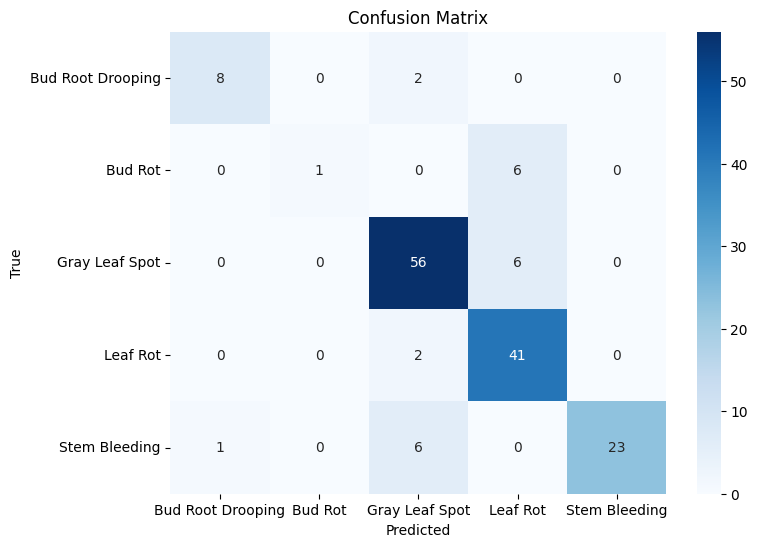

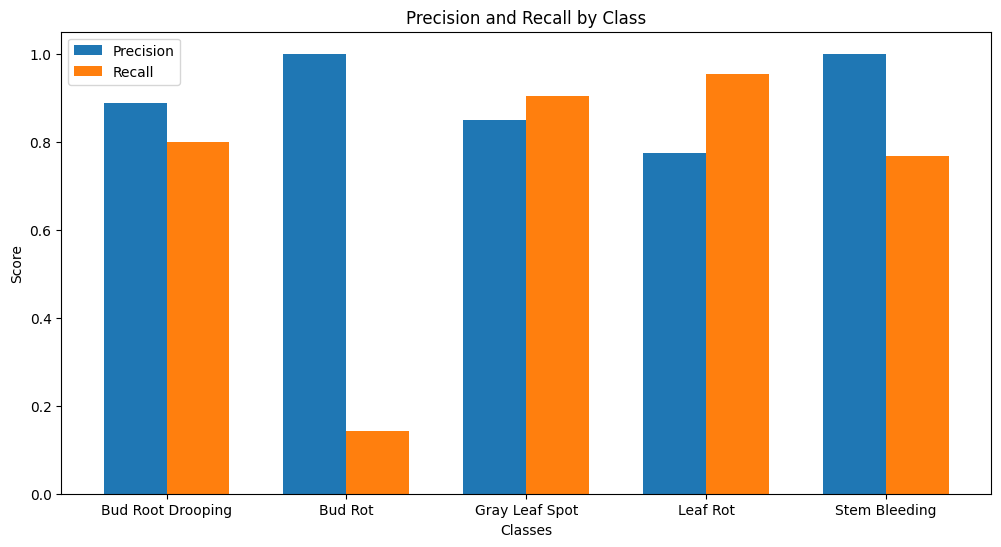

Epoch 1/5, Training Loss: 0.3402, Validation Accuracy: 0.8487
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.8889, Recall: 0.8000, F1 Score: 0.8421
Class: Bud Rot, Precision: 1.0000, Recall: 0.1429, F1 Score: 0.2500
Class: Gray Leaf Spot, Precision: 0.8485, Recall: 0.9032, F1 Score: 0.8750
Class: Leaf Rot, Precision: 0.7736, Recall: 0.9535, F1 Score: 0.8542
Class: Stem Bleeding, Precision: 1.0000, Recall: 0.7667, F1 Score: 0.8679
Train Epoch 2/5, Batch 1/38, Loss: 0.1489
Train Epoch 2/5, Batch 11/38, Loss: 0.3624
Train Epoch 2/5, Batch 21/38, Loss: 0.0280
Train Epoch 2/5, Batch 31/38, Loss: 0.5490


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


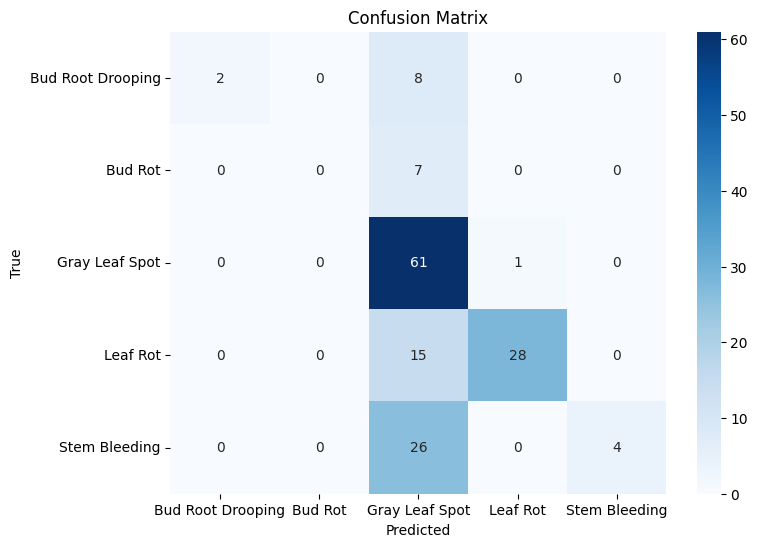

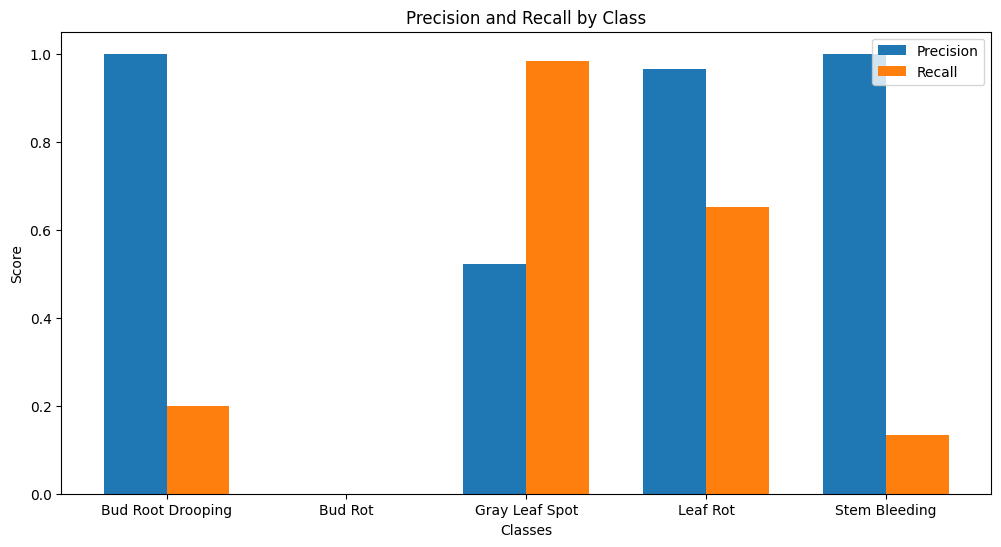

Epoch 2/5, Training Loss: 0.1794, Validation Accuracy: 0.6250
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 0.2000, F1 Score: 0.3333
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.5214, Recall: 0.9839, F1 Score: 0.6816
Class: Leaf Rot, Precision: 0.9655, Recall: 0.6512, F1 Score: 0.7778
Class: Stem Bleeding, Precision: 1.0000, Recall: 0.1333, F1 Score: 0.2353
Train Epoch 3/5, Batch 1/38, Loss: 0.2481
Train Epoch 3/5, Batch 11/38, Loss: 0.0124
Train Epoch 3/5, Batch 21/38, Loss: 0.2203
Train Epoch 3/5, Batch 31/38, Loss: 0.2886


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


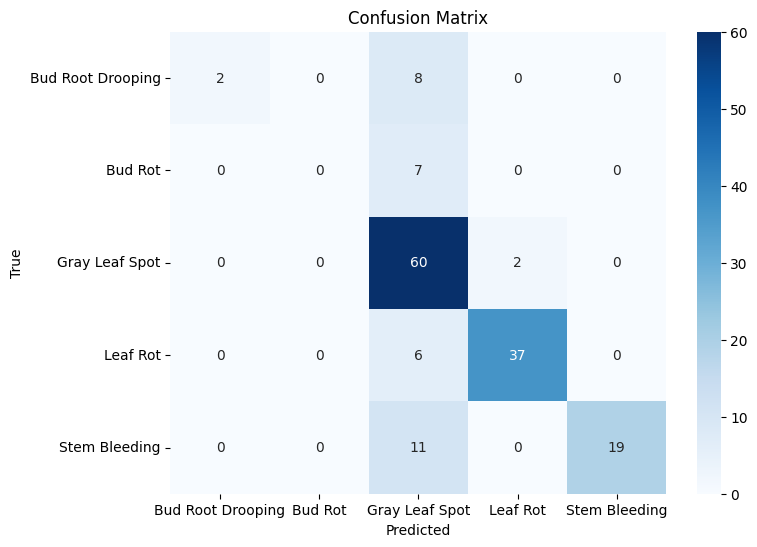

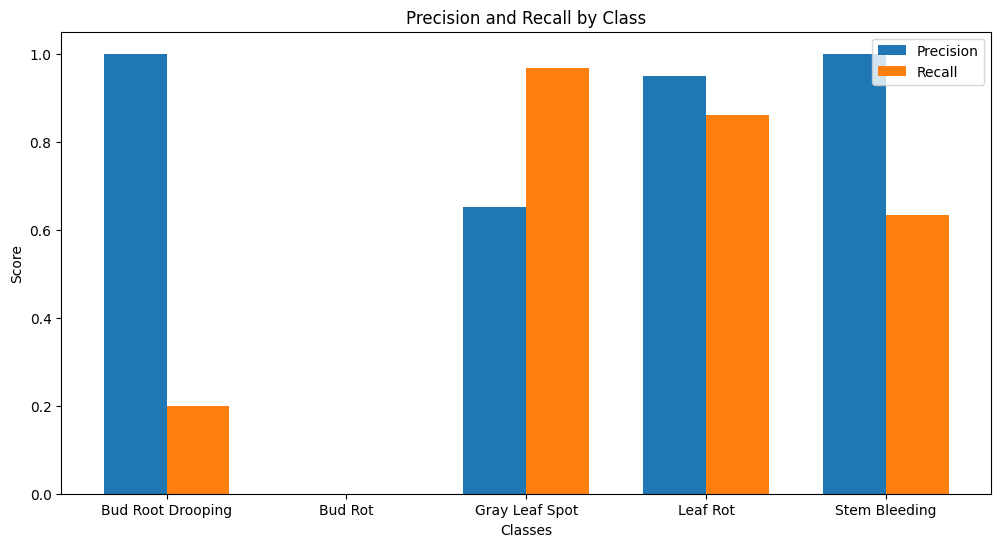

Epoch 3/5, Training Loss: 0.1058, Validation Accuracy: 0.7763
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 0.2000, F1 Score: 0.3333
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.6522, Recall: 0.9677, F1 Score: 0.7792
Class: Leaf Rot, Precision: 0.9487, Recall: 0.8605, F1 Score: 0.9024
Class: Stem Bleeding, Precision: 1.0000, Recall: 0.6333, F1 Score: 0.7755
Train Epoch 4/5, Batch 1/38, Loss: 0.0759
Train Epoch 4/5, Batch 11/38, Loss: 0.0432
Train Epoch 4/5, Batch 21/38, Loss: 0.0146
Train Epoch 4/5, Batch 31/38, Loss: 0.0015


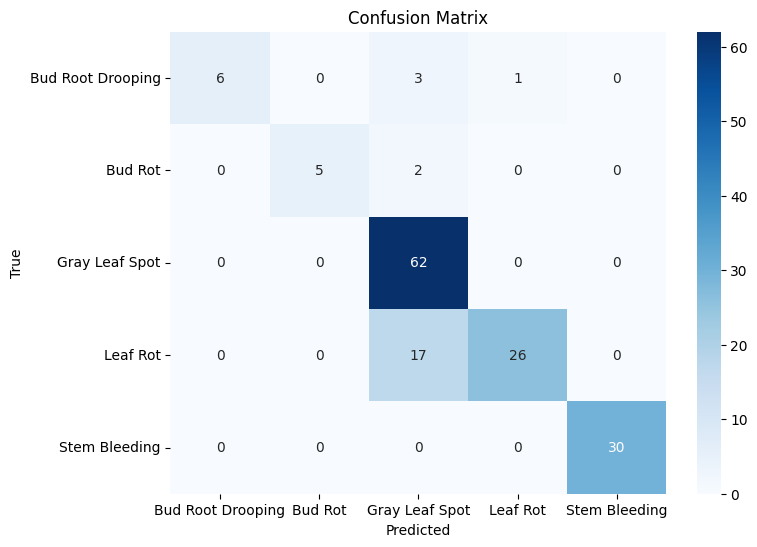

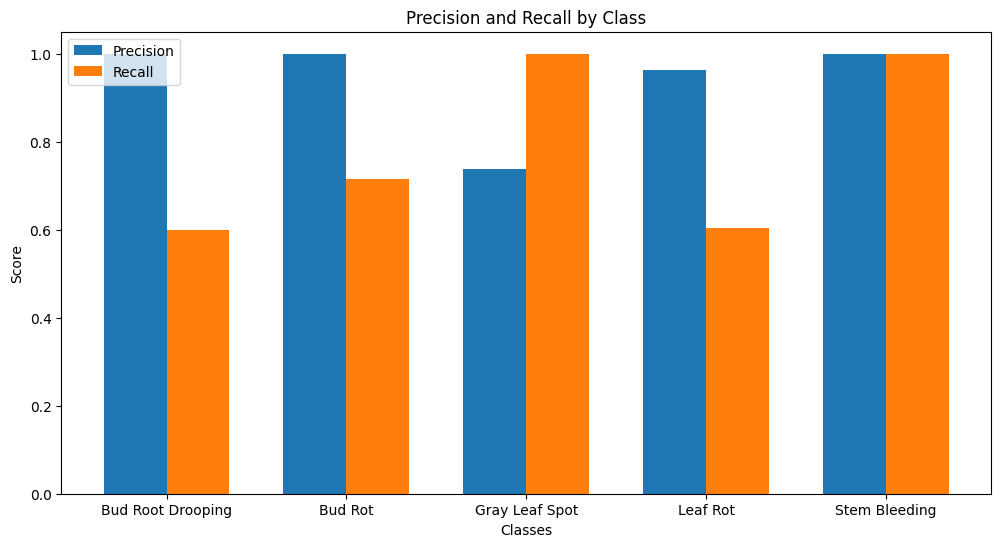

Epoch 4/5, Training Loss: 0.0964, Validation Accuracy: 0.8487
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 0.6000, F1 Score: 0.7500
Class: Bud Rot, Precision: 1.0000, Recall: 0.7143, F1 Score: 0.8333
Class: Gray Leaf Spot, Precision: 0.7381, Recall: 1.0000, F1 Score: 0.8493
Class: Leaf Rot, Precision: 0.9630, Recall: 0.6047, F1 Score: 0.7429
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 5/5, Batch 1/38, Loss: 0.0020
Train Epoch 5/5, Batch 11/38, Loss: 0.0577
Train Epoch 5/5, Batch 21/38, Loss: 0.0011
Train Epoch 5/5, Batch 31/38, Loss: 0.0099


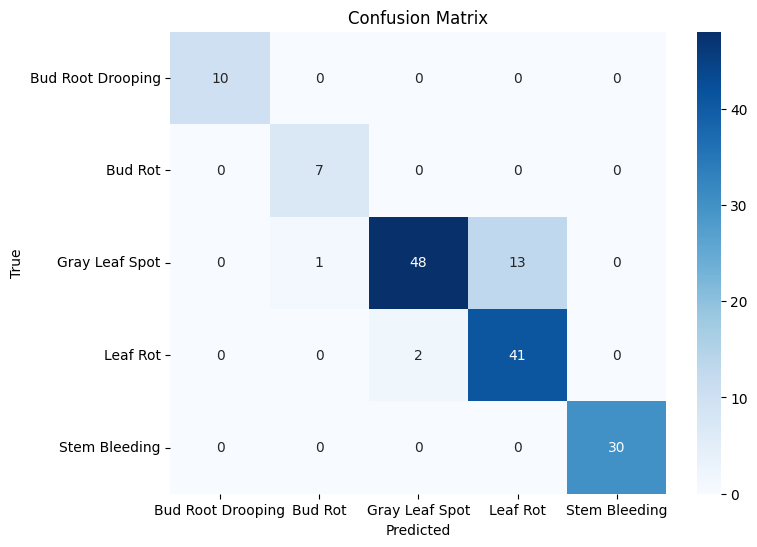

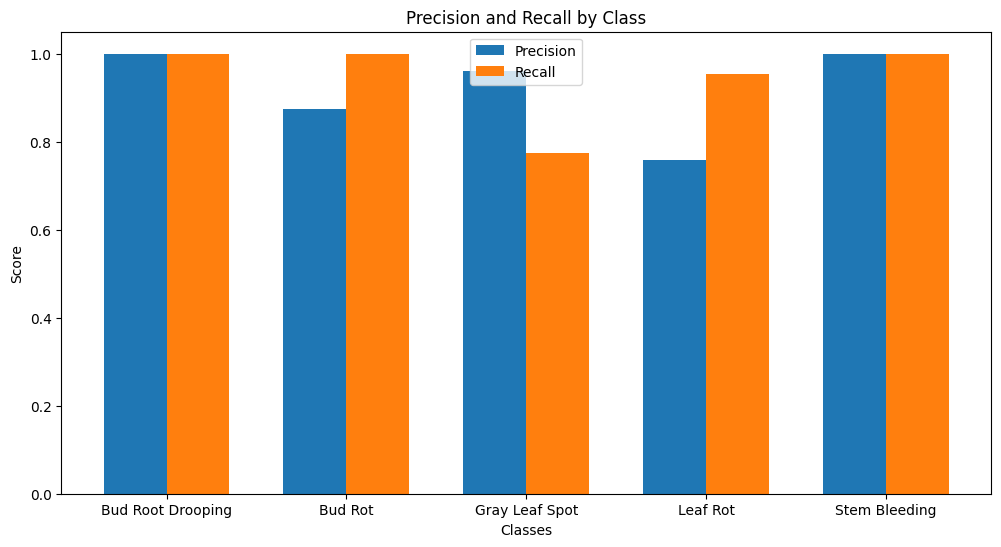

Epoch 5/5, Training Loss: 0.1554, Validation Accuracy: 0.8947
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 0.8750, Recall: 1.0000, F1 Score: 0.9333
Class: Gray Leaf Spot, Precision: 0.9600, Recall: 0.7742, F1 Score: 0.8571
Class: Leaf Rot, Precision: 0.7593, Recall: 0.9535, F1 Score: 0.8454
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


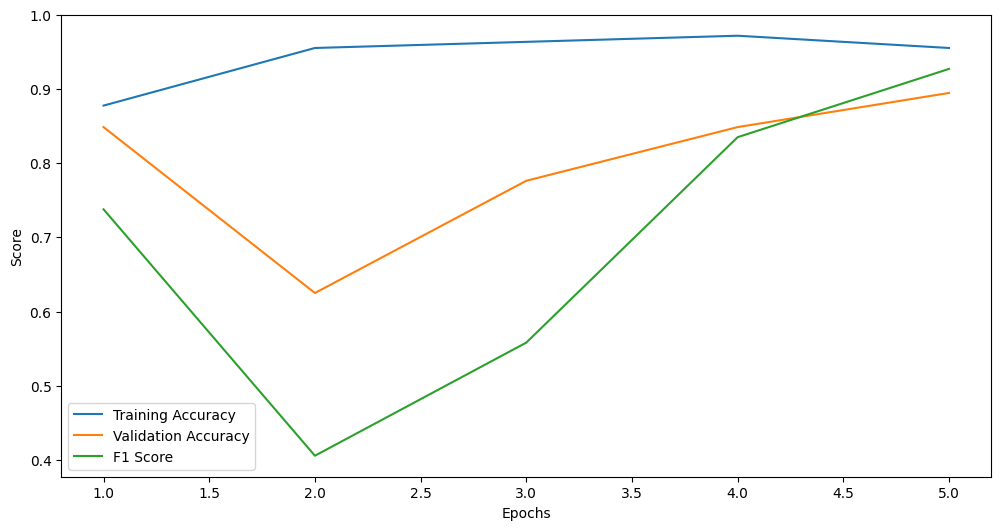

Total time taken for batched inference = 1662.1315479278564 ms


In [ ]:
# MobileNetv3 model
class CustomMobileNetV3Model(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNetV3Model, self).__init__()
        self.mobilenet_v3 = models.mobilenet_v3_large(pretrained=True)
        self.mobilenet_v3.classifier[-1] = nn.Linear(self.mobilenet_v3.classifier[-1].in_features, num_classes)

    def forward(self, x):
        x = self.mobilenet_v3(x)
        return x

mobilenet_v3_model = CustomMobileNetV3Model(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v3_model.parameters(), lr=0.001)
num_epochs = 5

# Trains the model
# tic = time.time()
train(mobilenet_v3_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)
# toc = time.time()
# print(f"{(toc-tic)*1000 /5 } ms")
# train(mobilenet_v3_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

In [ ]:
# train_accuracy_metrics(mobilenet_v3_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Train Epoch 1/5, Batch 1/38, Loss: 1.6664
Train Epoch 1/5, Batch 11/38, Loss: 0.4309
Train Epoch 1/5, Batch 21/38, Loss: 0.1181
Train Epoch 1/5, Batch 31/38, Loss: 0.3450


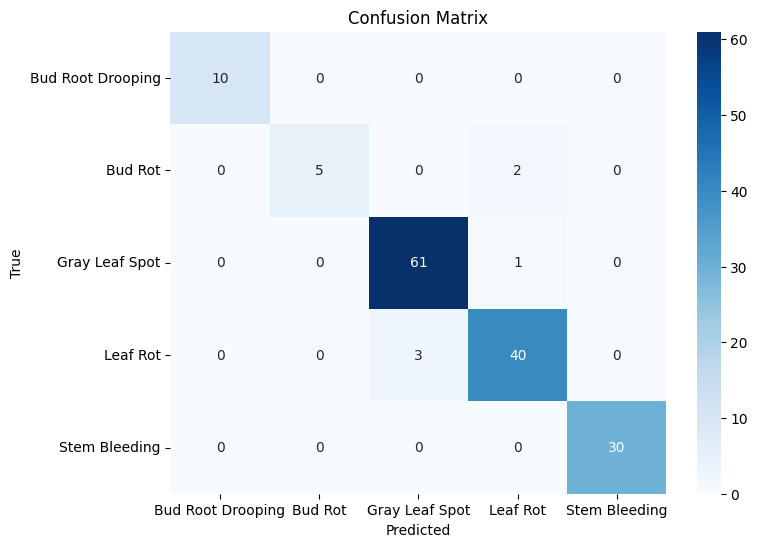

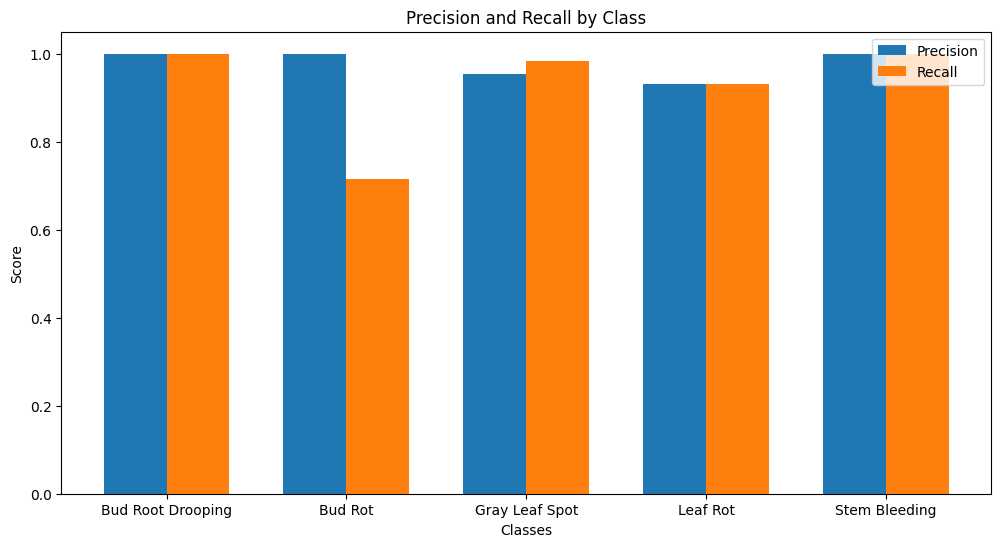

Epoch 1/5, Training Loss: 0.4213, Validation Accuracy: 0.9605
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 1.0000, Recall: 0.7143, F1 Score: 0.8333
Class: Gray Leaf Spot, Precision: 0.9531, Recall: 0.9839, F1 Score: 0.9683
Class: Leaf Rot, Precision: 0.9302, Recall: 0.9302, F1 Score: 0.9302
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 2/5, Batch 1/38, Loss: 0.1087
Train Epoch 2/5, Batch 11/38, Loss: 0.0272
Train Epoch 2/5, Batch 21/38, Loss: 0.0500
Train Epoch 2/5, Batch 31/38, Loss: 0.0119


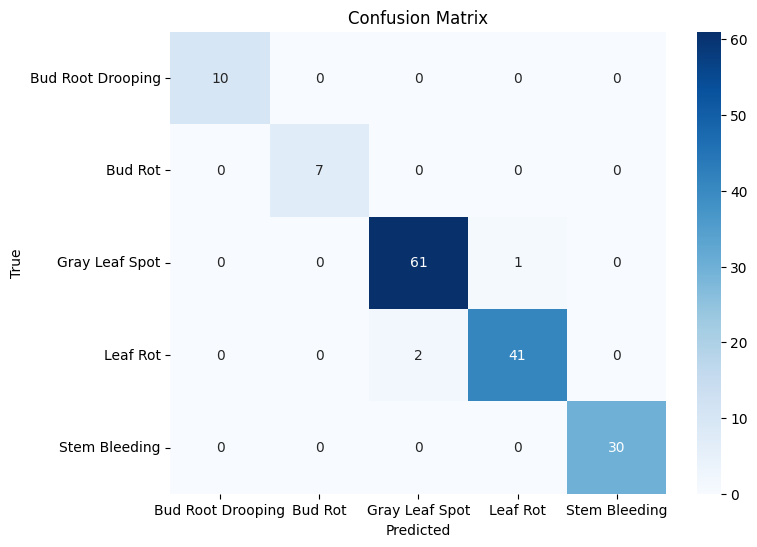

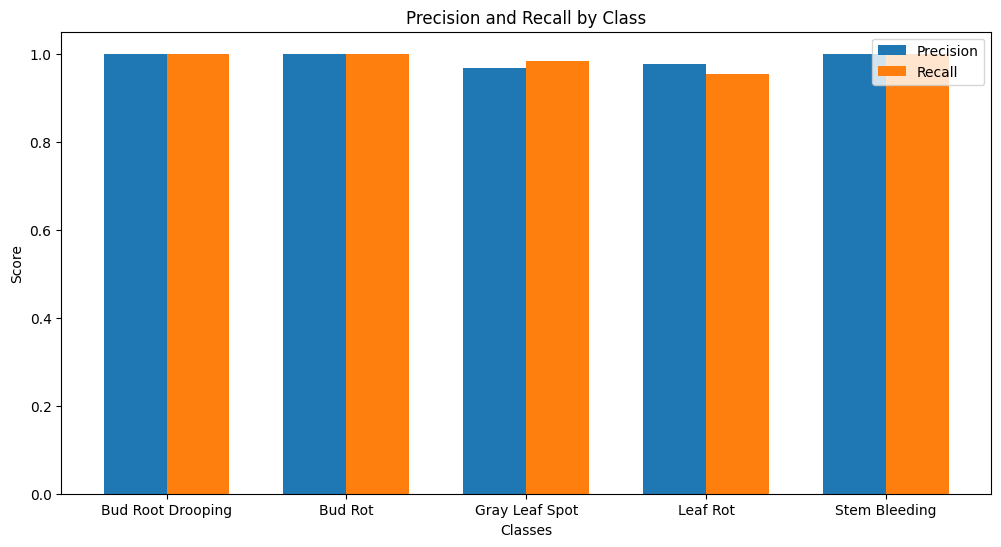

Epoch 2/5, Training Loss: 0.1246, Validation Accuracy: 0.9803
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Gray Leaf Spot, Precision: 0.9683, Recall: 0.9839, F1 Score: 0.9760
Class: Leaf Rot, Precision: 0.9762, Recall: 0.9535, F1 Score: 0.9647
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 3/5, Batch 1/38, Loss: 0.0210
Train Epoch 3/5, Batch 11/38, Loss: 0.0022
Train Epoch 3/5, Batch 21/38, Loss: 0.1622
Train Epoch 3/5, Batch 31/38, Loss: 0.9292


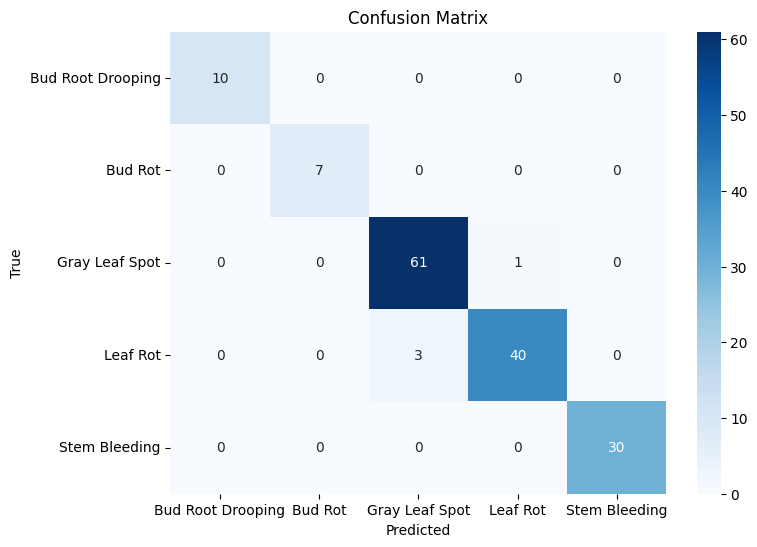

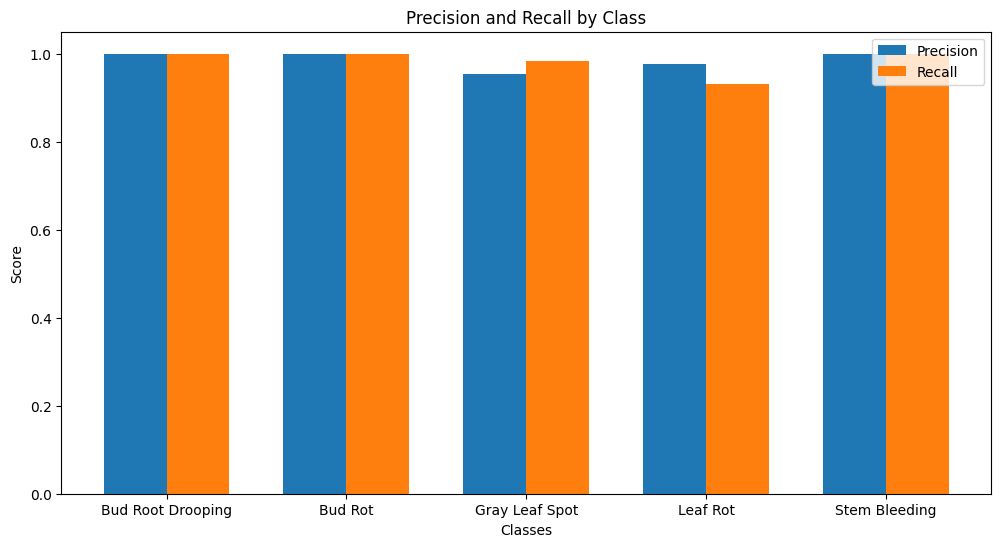

Epoch 3/5, Training Loss: 0.1926, Validation Accuracy: 0.9737
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Gray Leaf Spot, Precision: 0.9531, Recall: 0.9839, F1 Score: 0.9683
Class: Leaf Rot, Precision: 0.9756, Recall: 0.9302, F1 Score: 0.9524
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 4/5, Batch 1/38, Loss: 0.0452
Train Epoch 4/5, Batch 11/38, Loss: 0.0875
Train Epoch 4/5, Batch 21/38, Loss: 0.1402
Train Epoch 4/5, Batch 31/38, Loss: 0.1136


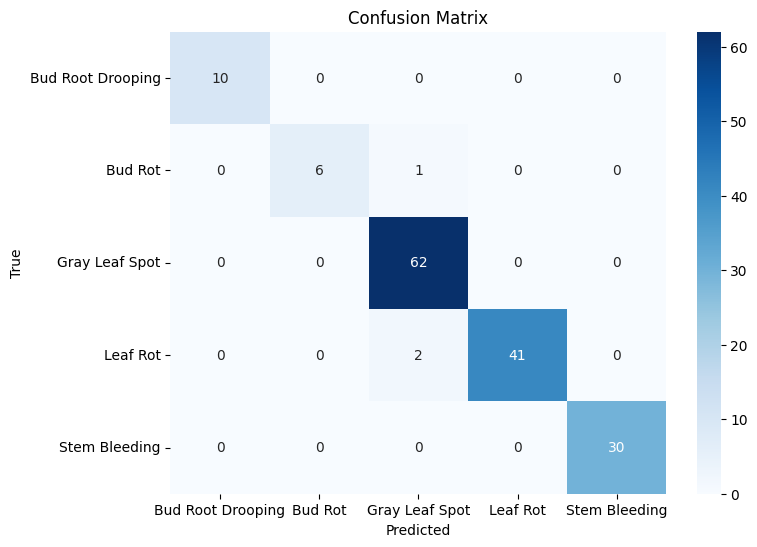

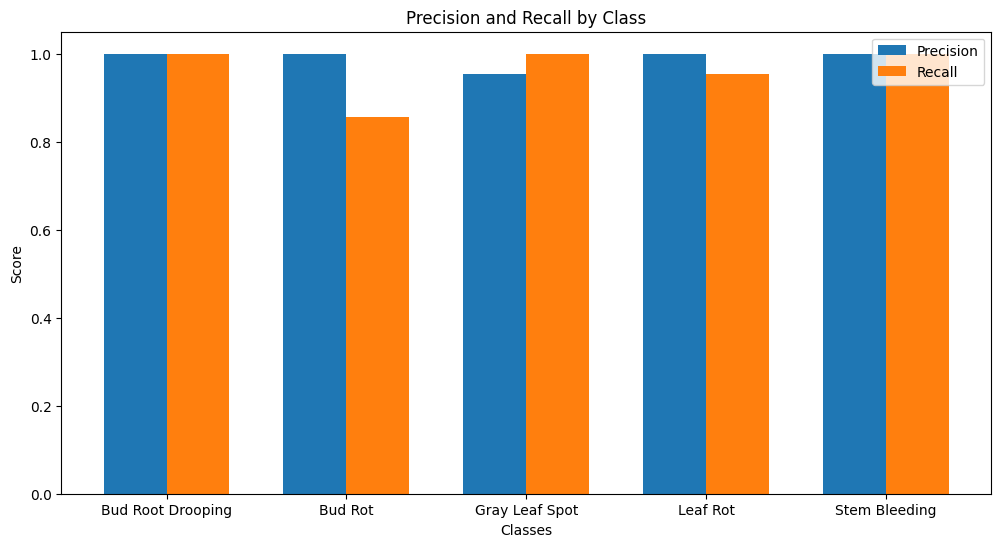

Epoch 4/5, Training Loss: 0.1030, Validation Accuracy: 0.9803
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 1.0000, Recall: 0.8571, F1 Score: 0.9231
Class: Gray Leaf Spot, Precision: 0.9538, Recall: 1.0000, F1 Score: 0.9764
Class: Leaf Rot, Precision: 1.0000, Recall: 0.9535, F1 Score: 0.9762
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 5/5, Batch 1/38, Loss: 0.0080
Train Epoch 5/5, Batch 11/38, Loss: 0.0045
Train Epoch 5/5, Batch 21/38, Loss: 0.0295
Train Epoch 5/5, Batch 31/38, Loss: 0.0075


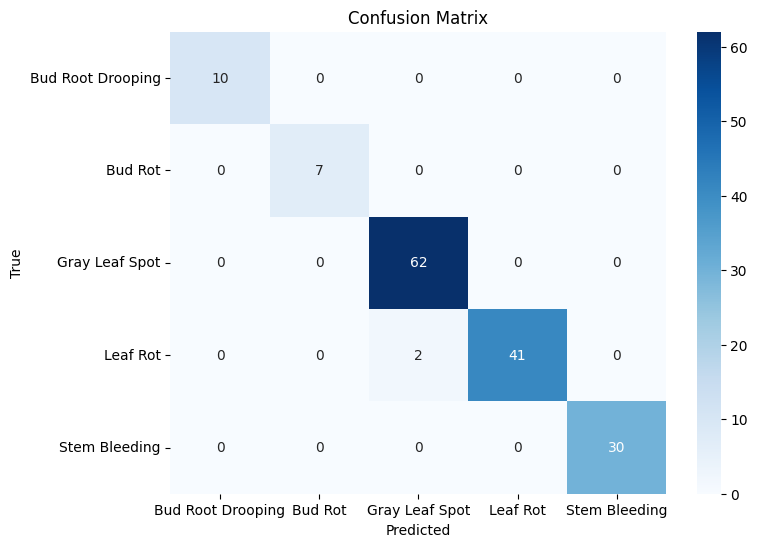

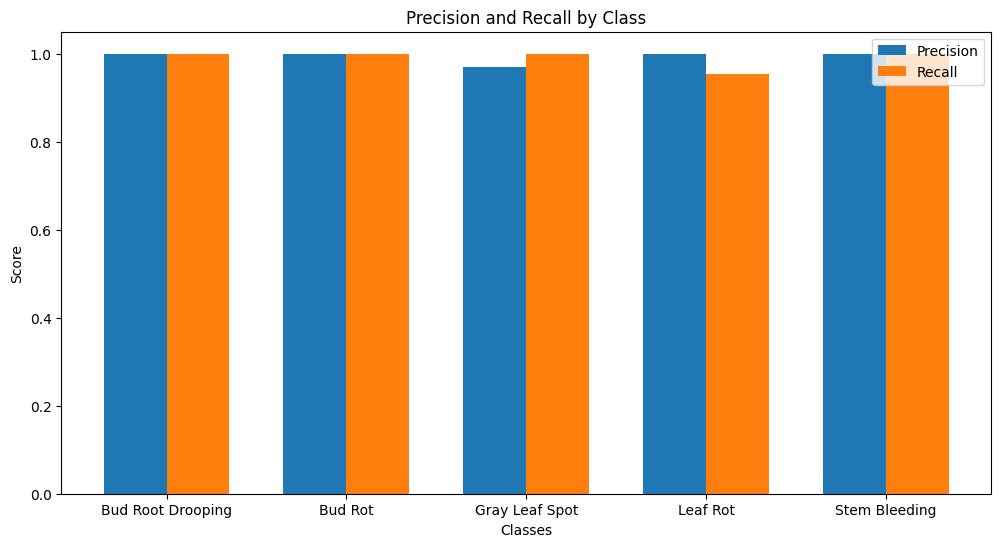

Epoch 5/5, Training Loss: 0.0425, Validation Accuracy: 0.9868
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Gray Leaf Spot, Precision: 0.9688, Recall: 1.0000, F1 Score: 0.9841
Class: Leaf Rot, Precision: 1.0000, Recall: 0.9535, F1 Score: 0.9762
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


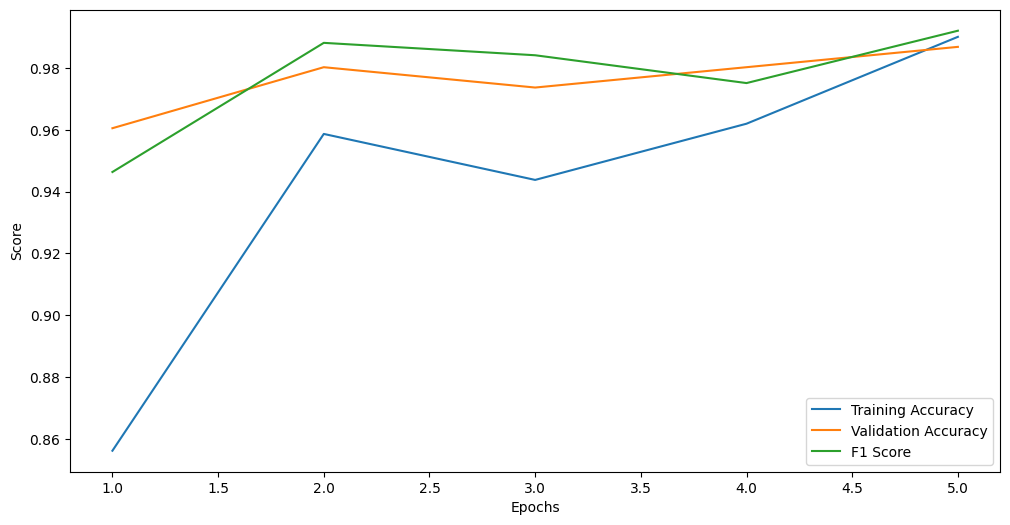

Total time taken for batched inference = 1799.1271018981934 ms


In [ ]:
#ResNetXT model
class CustomResNetXTModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNetXTModel, self).__init__()
        self.resnetxt = timm.create_model('rexnet_150', pretrained=True, num_classes=0, global_pool='avg')

        # Modifies the classifier
        self.classifier = nn.Linear(self.resnetxt.num_features, num_classes)

    def forward(self, x):
        x = self.resnetxt(x)
        x = self.classifier(x)
        return x

resnet_xt_model = CustomResNetXTModel(num_classes=5).to(device)
optimizer = optim.Adam(resnet_xt_model.parameters(), lr=0.001)


# Trains the model
# tic = time.time()
train(resnet_xt_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)
# toc = time.time()
# print(f"{(toc-tic)*1000 /5 } ms")

In [ ]:
# train_accuracy_metrics(resnet_xt_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch 1/5, Batch 1/38, Loss: 1.7113
Train Epoch 1/5, Batch 11/38, Loss: 1.8532
Train Epoch 1/5, Batch 21/38, Loss: 1.7449
Train Epoch 1/5, Batch 31/38, Loss: 1.7605


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


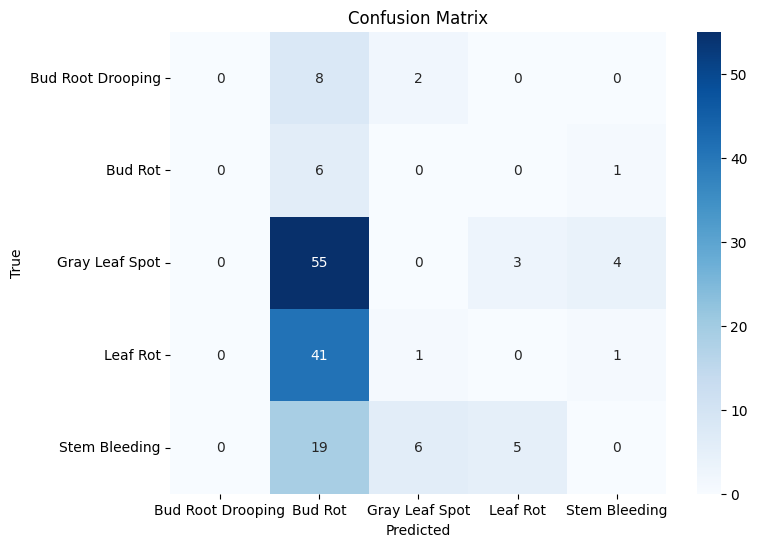

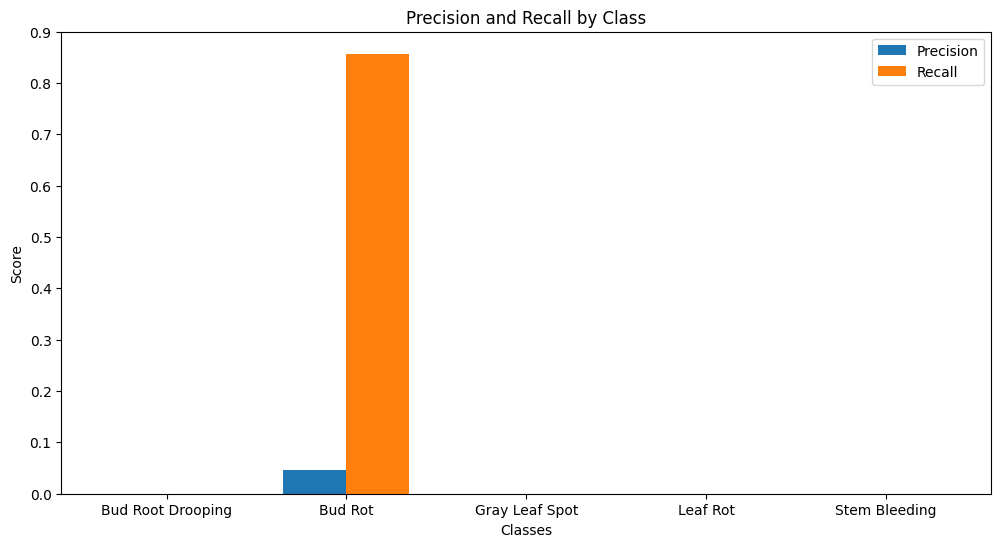

Epoch 1/5, Training Loss: 1.7933, Validation Accuracy: 0.0395
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0465, Recall: 0.8571, F1 Score: 0.0882
Class: Gray Leaf Spot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Train Epoch 2/5, Batch 1/38, Loss: 1.8437
Train Epoch 2/5, Batch 11/38, Loss: 1.8525
Train Epoch 2/5, Batch 21/38, Loss: 1.8063
Train Epoch 2/5, Batch 31/38, Loss: 1.8327


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


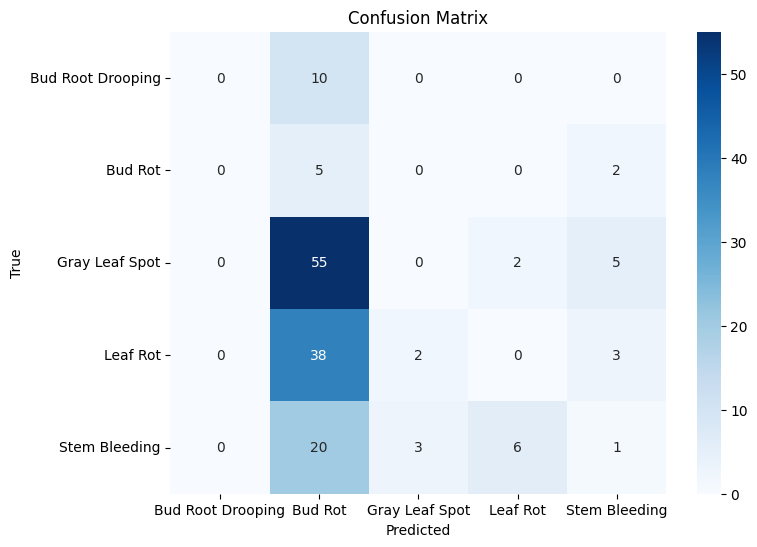

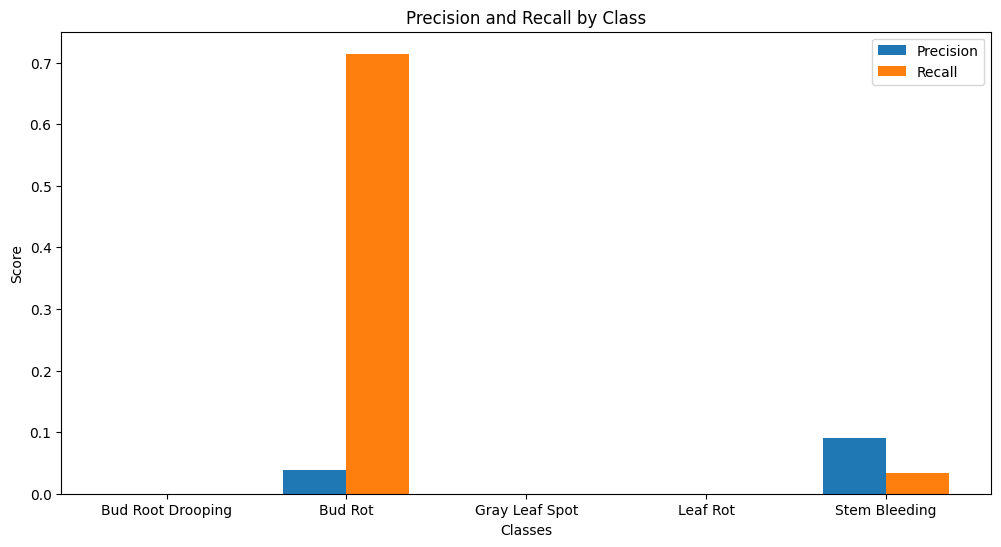

Epoch 2/5, Training Loss: 1.7951, Validation Accuracy: 0.0395
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0391, Recall: 0.7143, F1 Score: 0.0741
Class: Gray Leaf Spot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.0909, Recall: 0.0333, F1 Score: 0.0488
Train Epoch 3/5, Batch 1/38, Loss: 1.8195
Train Epoch 3/5, Batch 11/38, Loss: 1.7019
Train Epoch 3/5, Batch 21/38, Loss: 1.8062
Train Epoch 3/5, Batch 31/38, Loss: 1.6292


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


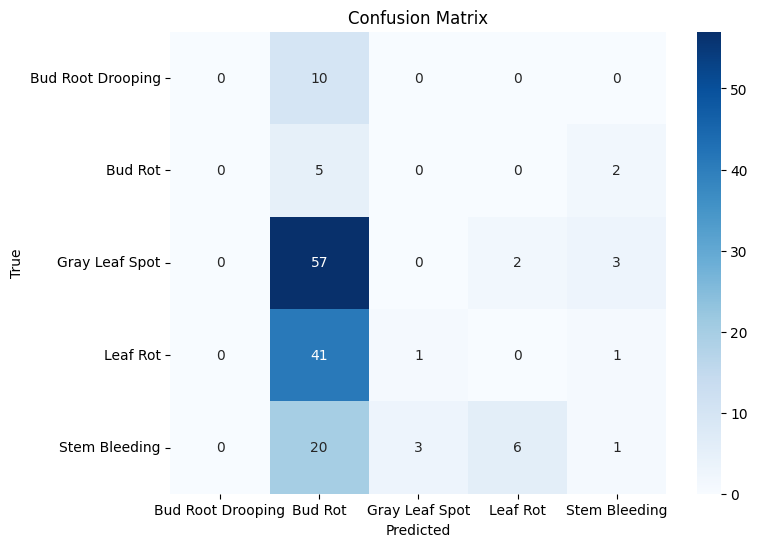

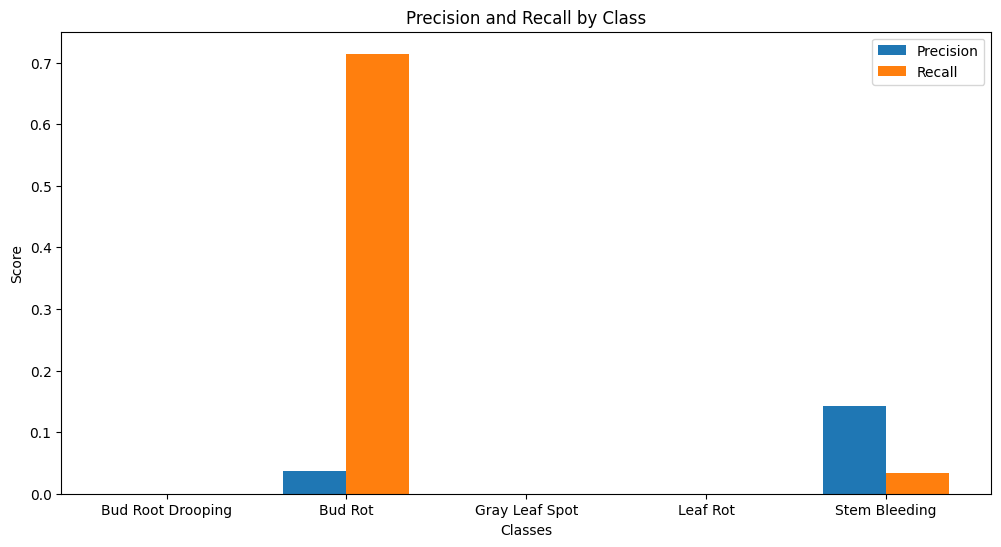

Epoch 3/5, Training Loss: 1.7943, Validation Accuracy: 0.0395
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0376, Recall: 0.7143, F1 Score: 0.0714
Class: Gray Leaf Spot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.1429, Recall: 0.0333, F1 Score: 0.0541
Train Epoch 4/5, Batch 1/38, Loss: 1.7387
Train Epoch 4/5, Batch 11/38, Loss: 1.8981
Train Epoch 4/5, Batch 21/38, Loss: 1.8310
Train Epoch 4/5, Batch 31/38, Loss: 1.7822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


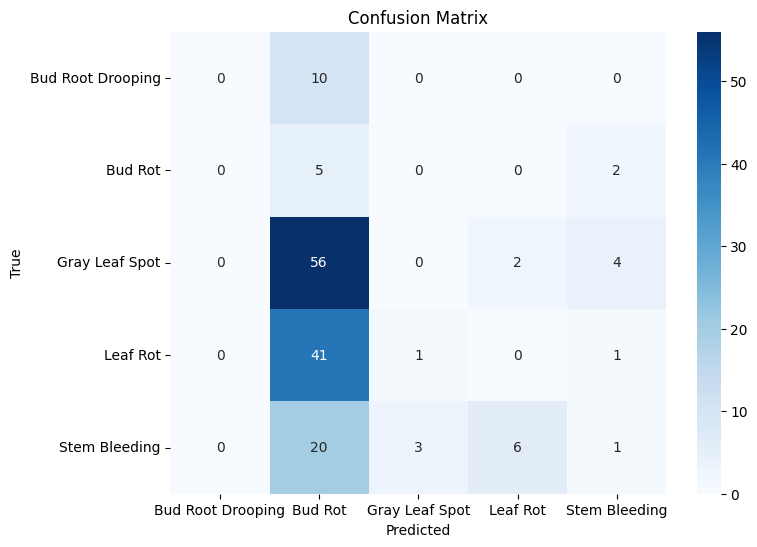

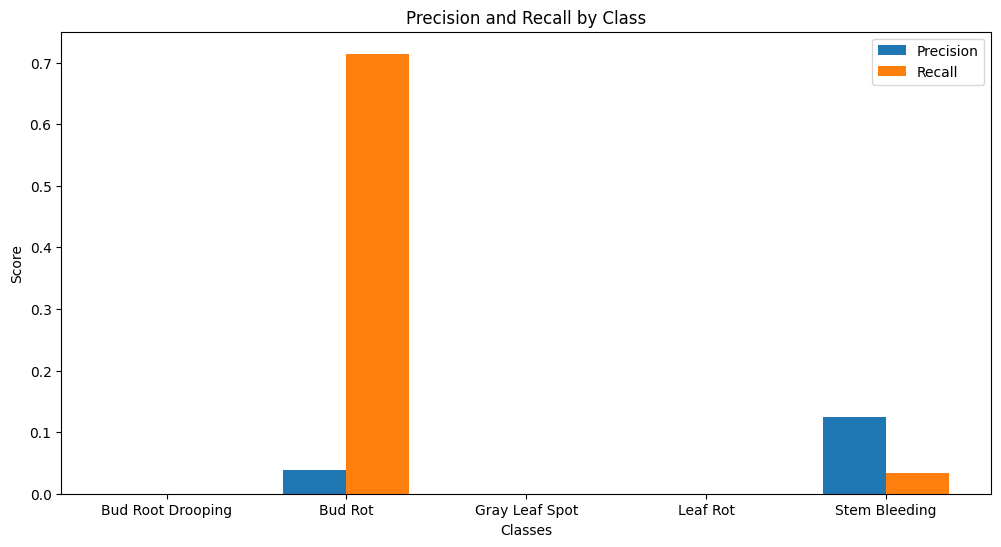

Epoch 4/5, Training Loss: 1.7907, Validation Accuracy: 0.0395
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0379, Recall: 0.7143, F1 Score: 0.0719
Class: Gray Leaf Spot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.1250, Recall: 0.0333, F1 Score: 0.0526
Train Epoch 5/5, Batch 1/38, Loss: 1.8047
Train Epoch 5/5, Batch 11/38, Loss: 1.7240
Train Epoch 5/5, Batch 21/38, Loss: 1.7965
Train Epoch 5/5, Batch 31/38, Loss: 1.7144


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


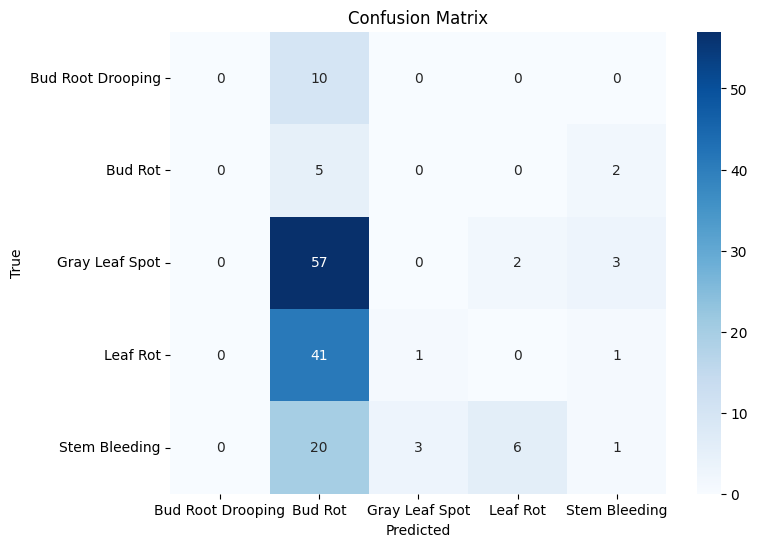

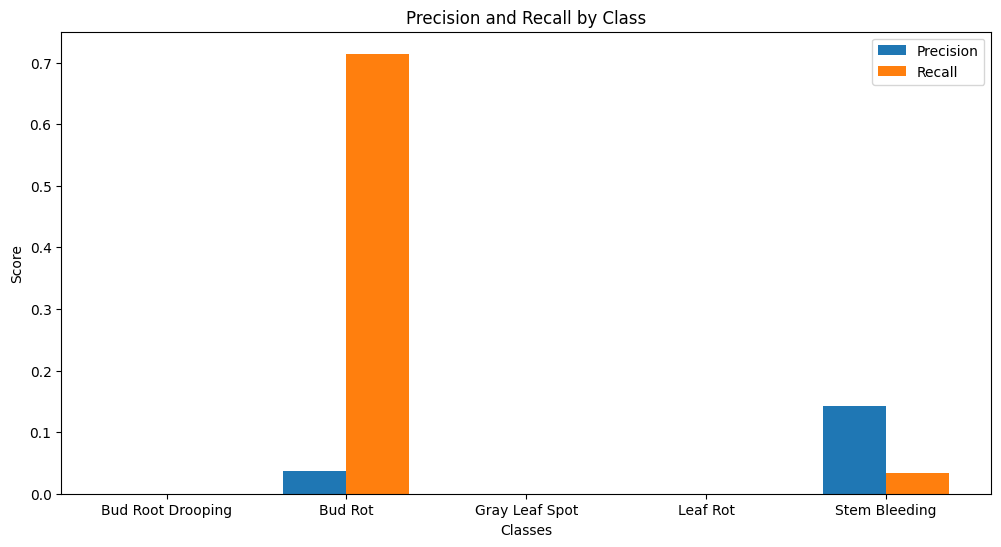

Epoch 5/5, Training Loss: 1.8050, Validation Accuracy: 0.0395
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0376, Recall: 0.7143, F1 Score: 0.0714
Class: Gray Leaf Spot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.1429, Recall: 0.0333, F1 Score: 0.0541


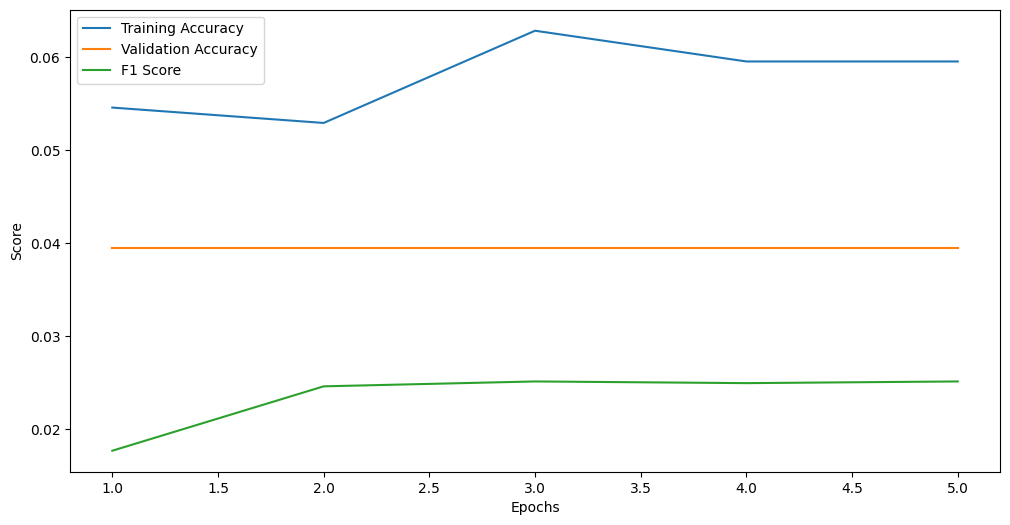

Total time taken for batched inference = 3165.595531463623 ms


In [ ]:
class CustomDenseNetModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomDenseNetModel, self).__init__()
        self.densenet = models.densenet121(pretrained=True)

        # Modiies the classifier
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.densenet(x)
        return x

dense_net_model = CustomDenseNetModel(num_classes=5).to(device)
optimizer = optim.Adam(resnet_xt_model.parameters(), lr=0.001)

train(dense_net_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

In [ ]:
# custom Vision Transformer Model

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Train Epoch 1/5, Batch 1/38, Loss: 1.6523
Train Epoch 1/5, Batch 11/38, Loss: 2.9612
Train Epoch 1/5, Batch 21/38, Loss: 1.2256
Train Epoch 1/5, Batch 31/38, Loss: 1.0413


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


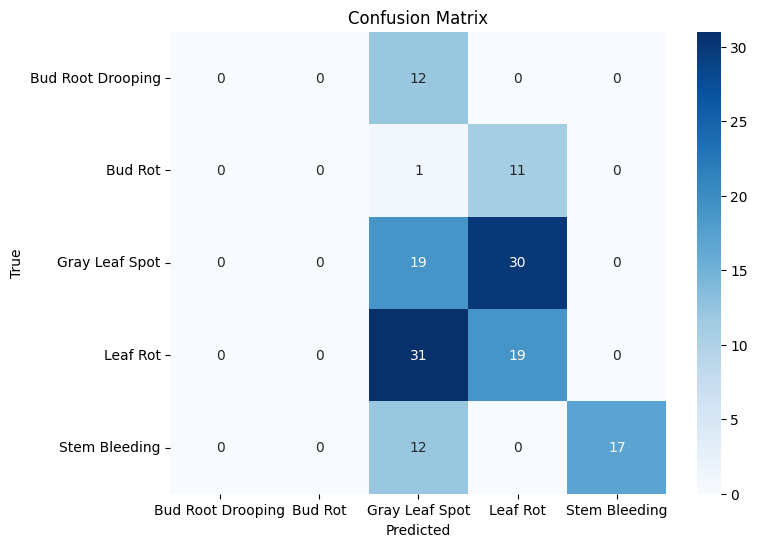

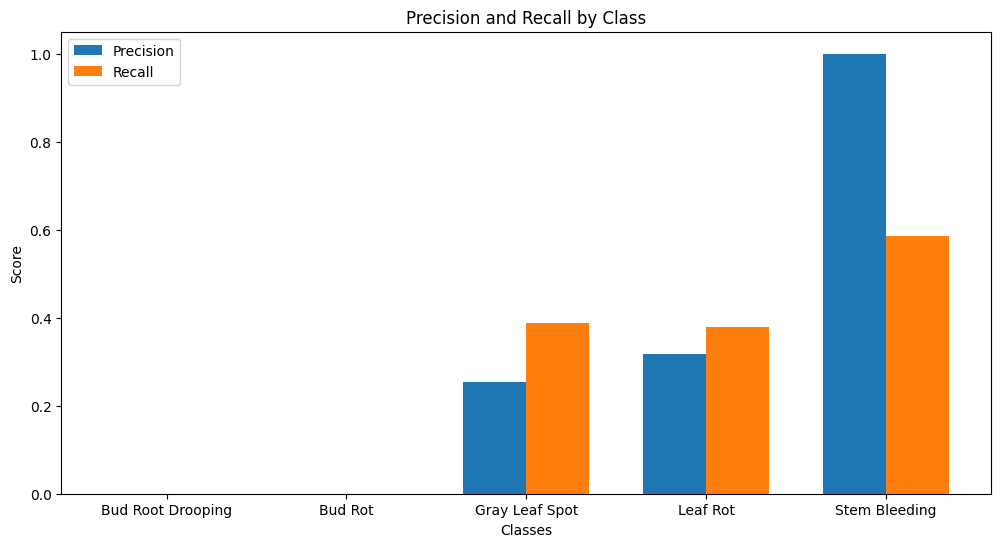

Epoch 1/5, Training Loss: 1.5826, Validation Accuracy: 0.3618
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.2533, Recall: 0.3878, F1 Score: 0.3065
Class: Leaf Rot, Precision: 0.3167, Recall: 0.3800, F1 Score: 0.3455
Class: Stem Bleeding, Precision: 1.0000, Recall: 0.5862, F1 Score: 0.7391
Train Epoch 2/5, Batch 1/38, Loss: 0.9503
Train Epoch 2/5, Batch 11/38, Loss: 1.6686
Train Epoch 2/5, Batch 21/38, Loss: 1.6634
Train Epoch 2/5, Batch 31/38, Loss: 1.3233


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


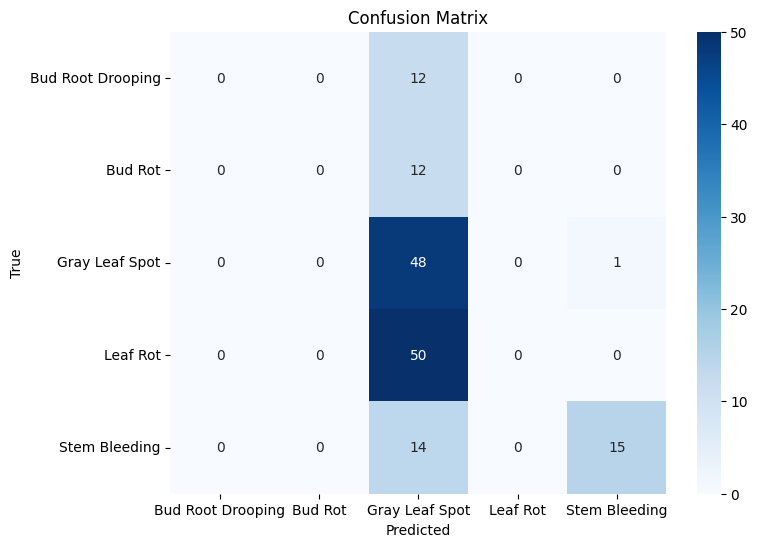

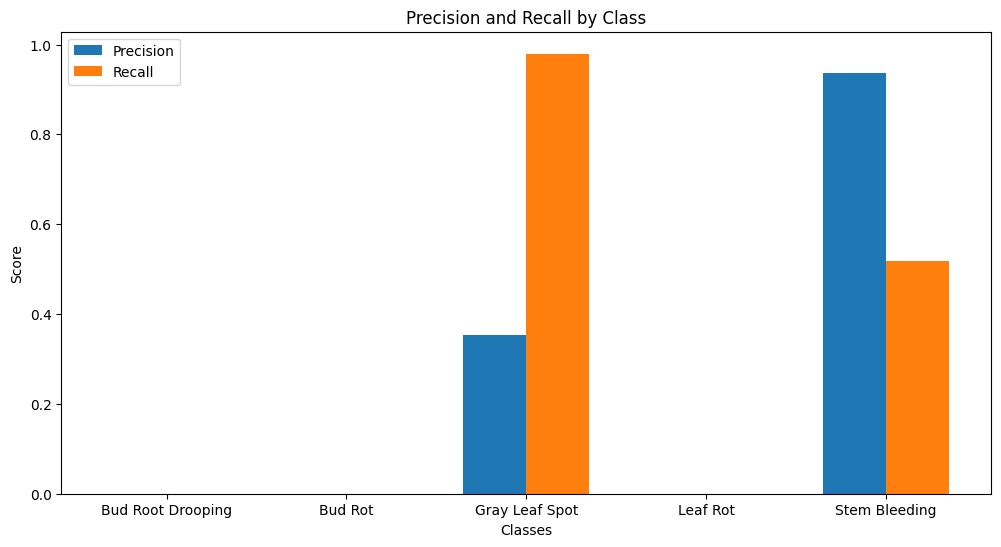

Epoch 2/5, Training Loss: 1.4339, Validation Accuracy: 0.4145
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3529, Recall: 0.9796, F1 Score: 0.5189
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.9375, Recall: 0.5172, F1 Score: 0.6667
Train Epoch 3/5, Batch 1/38, Loss: 0.8434
Train Epoch 3/5, Batch 11/38, Loss: 1.3821
Train Epoch 3/5, Batch 21/38, Loss: 2.1531
Train Epoch 3/5, Batch 31/38, Loss: 1.4489


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


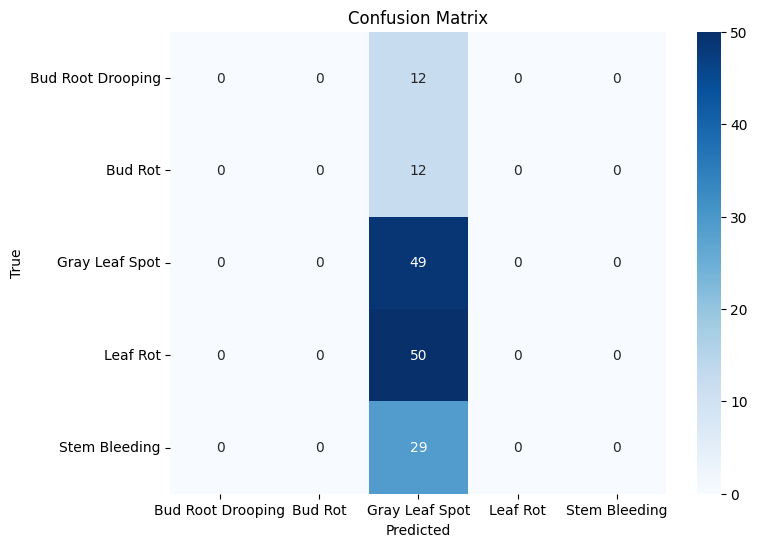

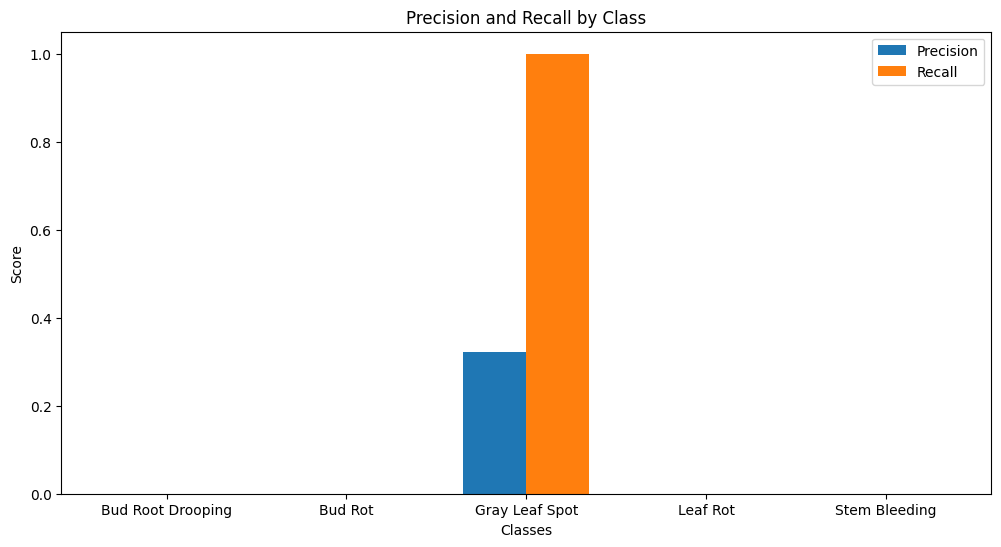

Epoch 3/5, Training Loss: 1.4211, Validation Accuracy: 0.3224
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3224, Recall: 1.0000, F1 Score: 0.4876
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Train Epoch 4/5, Batch 1/38, Loss: 1.7275
Train Epoch 4/5, Batch 11/38, Loss: 1.4365
Train Epoch 4/5, Batch 21/38, Loss: 1.3728
Train Epoch 4/5, Batch 31/38, Loss: 1.6933


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


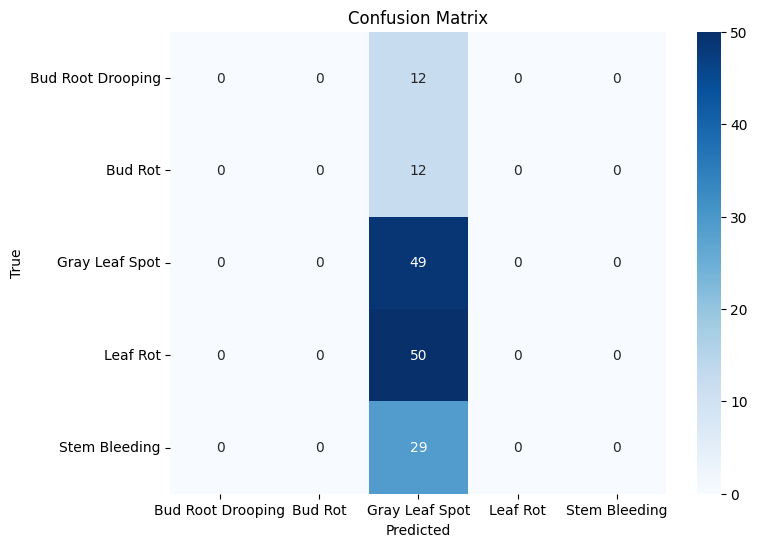

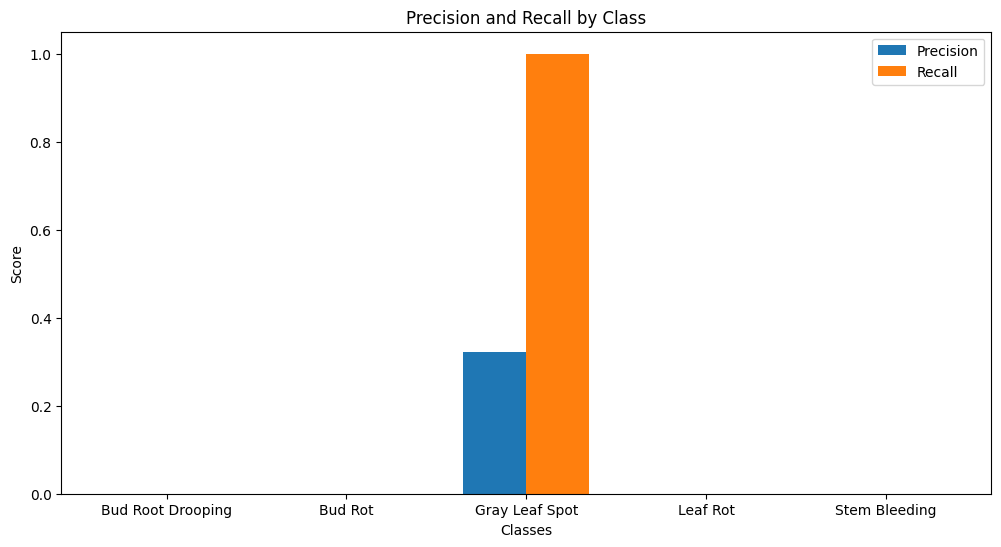

Epoch 4/5, Training Loss: 1.4740, Validation Accuracy: 0.3224
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3224, Recall: 1.0000, F1 Score: 0.4876
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Train Epoch 5/5, Batch 1/38, Loss: 1.4926
Train Epoch 5/5, Batch 11/38, Loss: 1.5898
Train Epoch 5/5, Batch 21/38, Loss: 1.4062
Train Epoch 5/5, Batch 31/38, Loss: 1.4217


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


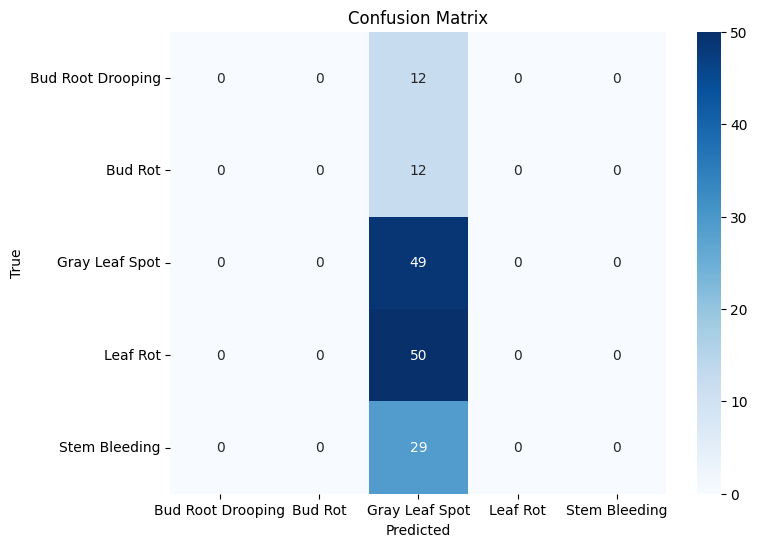

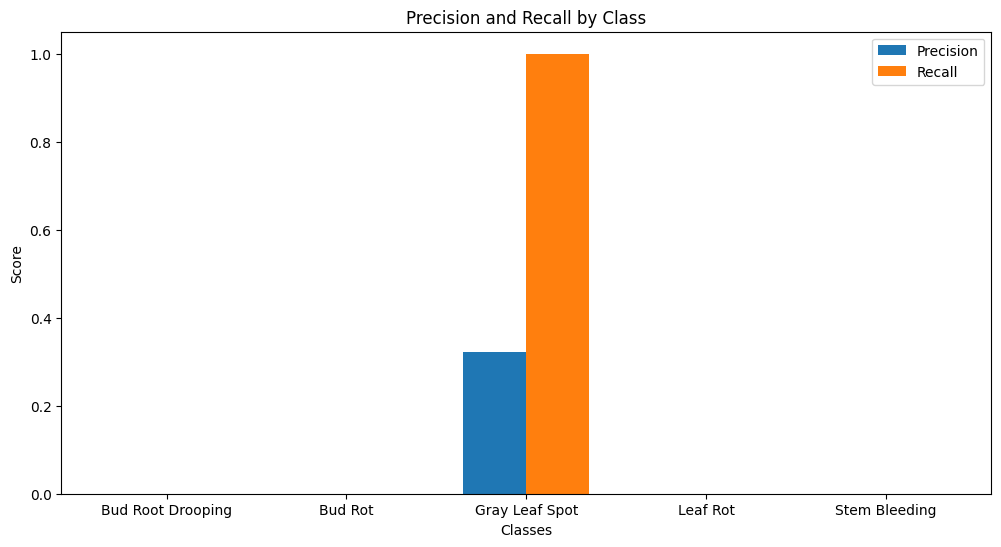

Epoch 5/5, Training Loss: 1.4715, Validation Accuracy: 0.3224
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3224, Recall: 1.0000, F1 Score: 0.4876
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


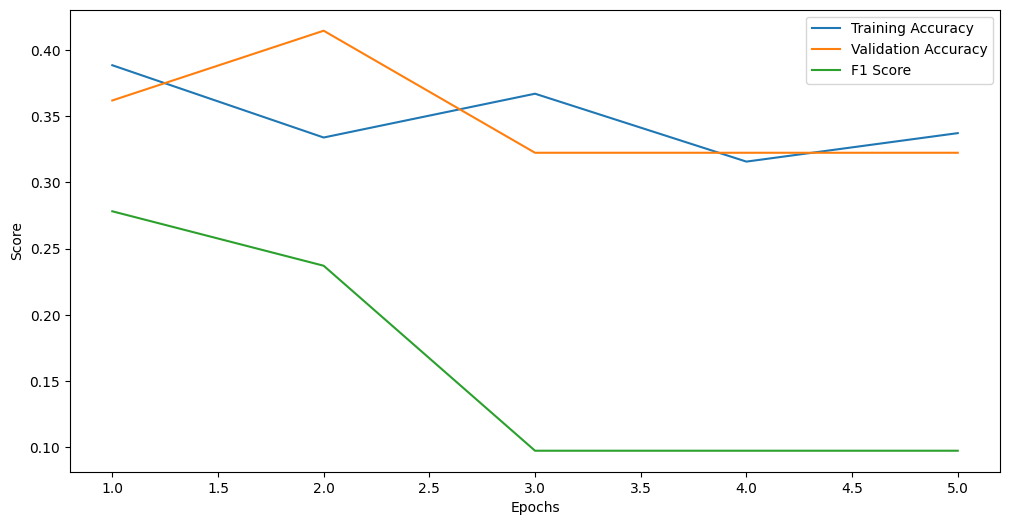

Total time taken for batched inference = 2671.8835830688477 ms


In [ ]:
# Swin Transformer model
class CustomSwinTransformerModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomSwinTransformerModel, self).__init__()
        self.swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0, global_pool='avg')

        # Modifies the classifier
        self.classifier = nn.Linear(self.swin.num_features, num_classes)

    def forward(self, x):
        x = self.swin(x)
        x = self.classifier(x)
        return x

swin_model = CustomSwinTransformerModel(num_classes=5).to(device)
optimizer = optim.Adam(swin_model.parameters(), lr=lr)

# tic = time.time()
train(swin_model, train_dataloader_swin, val_dataloader_swin, criterion, optimizer, num_epochs=num_epochs)
# toc = time.time()
# print(f"{(toc-tic)*1000 /5 } ms")

model.safetensors:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

DeiT Model Global Pooling Output Size: 384
Train Epoch 1/10, Batch 1/38, Loss: 3.5108
Train Epoch 1/10, Batch 11/38, Loss: 2.2967
Train Epoch 1/10, Batch 21/38, Loss: 1.5565
Train Epoch 1/10, Batch 31/38, Loss: 1.7174


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


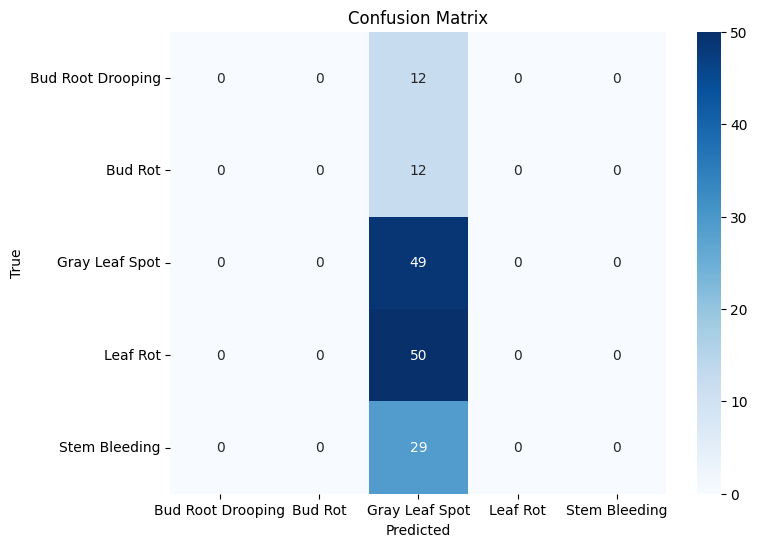

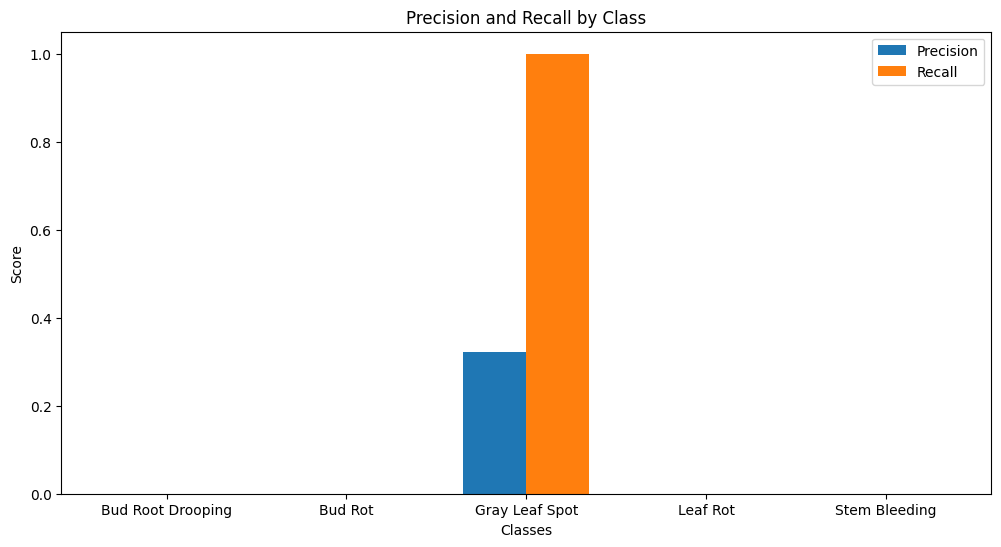

Epoch 1/10, Training Loss: 3.6613, Validation Accuracy: 0.3224
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3224, Recall: 1.0000, F1 Score: 0.4876
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Train Epoch 2/10, Batch 1/38, Loss: 1.8381
Train Epoch 2/10, Batch 11/38, Loss: 1.2428
Train Epoch 2/10, Batch 21/38, Loss: 1.8846
Train Epoch 2/10, Batch 31/38, Loss: 1.9260


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


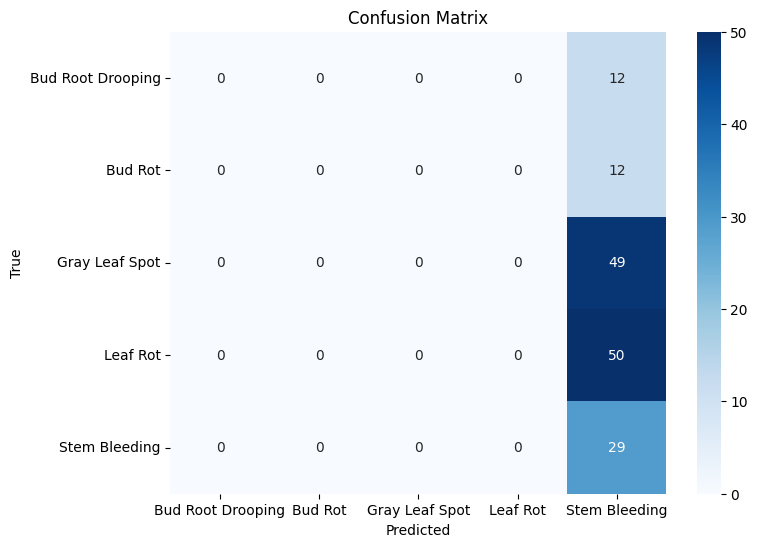

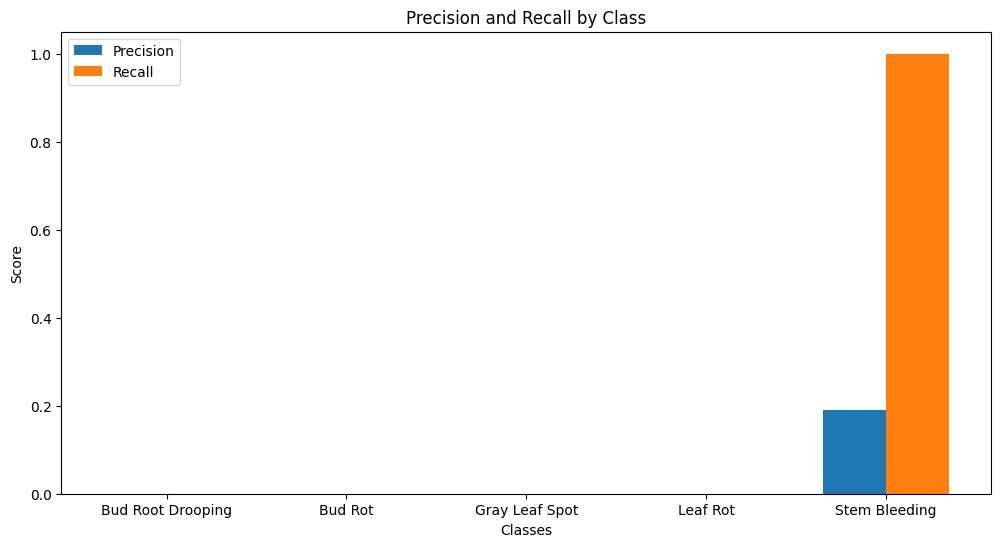

Epoch 2/10, Training Loss: 1.7465, Validation Accuracy: 0.1908
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.1908, Recall: 1.0000, F1 Score: 0.3204
Train Epoch 3/10, Batch 1/38, Loss: 1.5623
Train Epoch 3/10, Batch 11/38, Loss: 1.3575
Train Epoch 3/10, Batch 21/38, Loss: 1.4350
Train Epoch 3/10, Batch 31/38, Loss: 1.3372


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


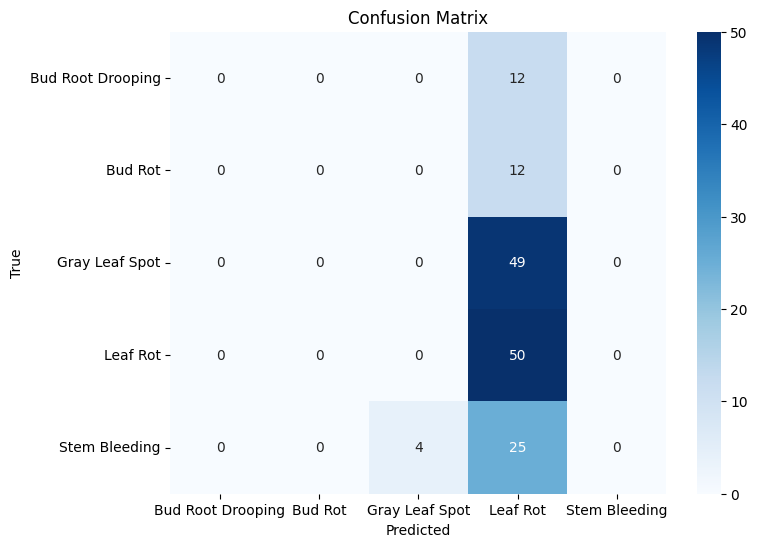

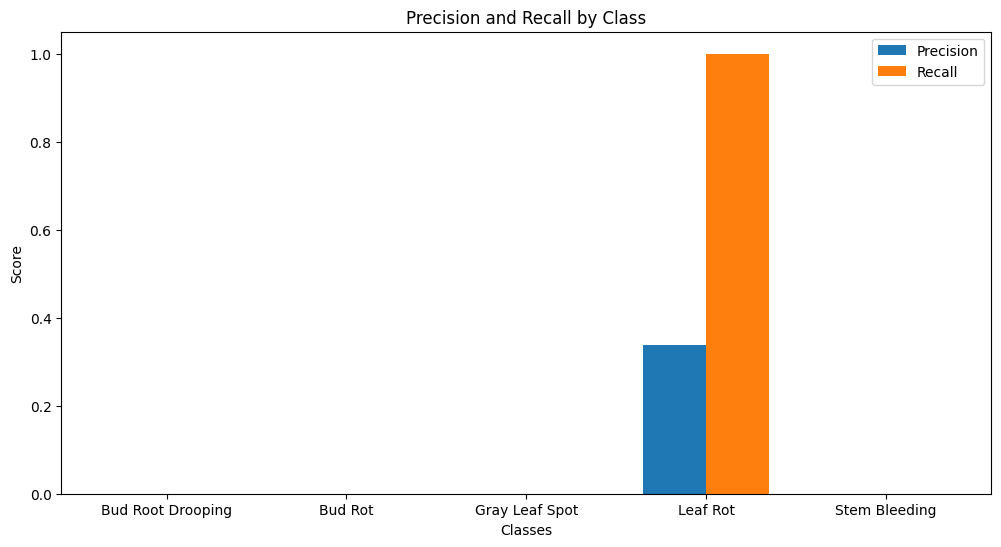

Epoch 3/10, Training Loss: 1.4237, Validation Accuracy: 0.3289
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Leaf Rot, Precision: 0.3378, Recall: 1.0000, F1 Score: 0.5051
Class: Stem Bleeding, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Train Epoch 4/10, Batch 1/38, Loss: 1.6065
Train Epoch 4/10, Batch 11/38, Loss: 1.2077
Train Epoch 4/10, Batch 21/38, Loss: 1.0880
Train Epoch 4/10, Batch 31/38, Loss: 1.3115


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


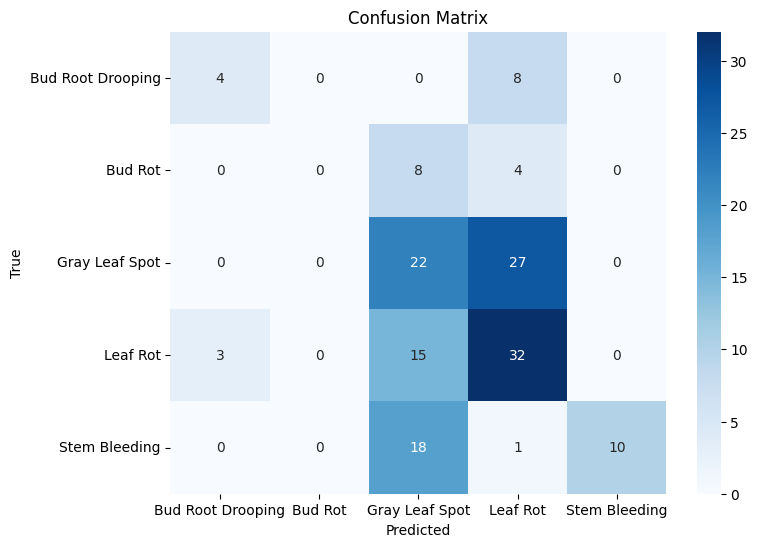

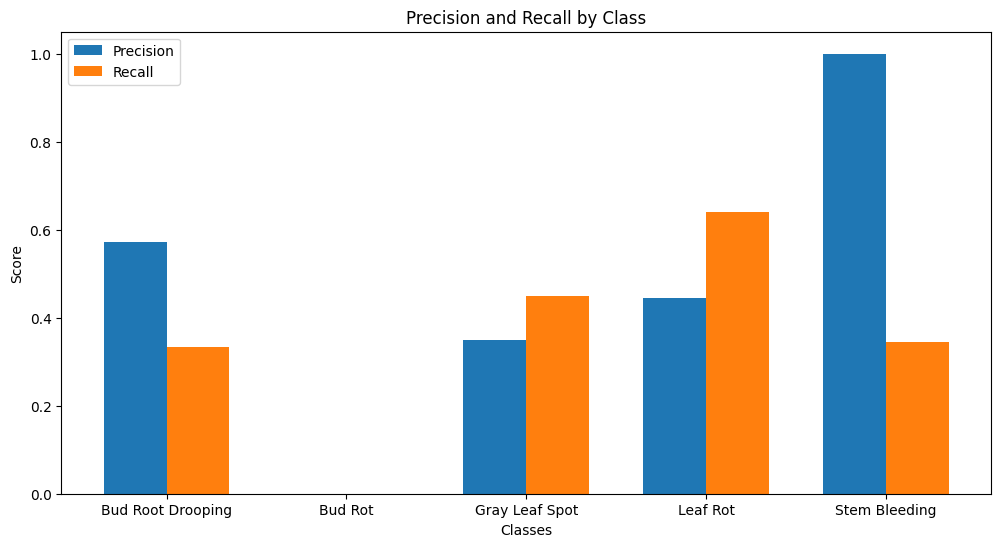

Epoch 4/10, Training Loss: 1.3434, Validation Accuracy: 0.4474
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.5714, Recall: 0.3333, F1 Score: 0.4211
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3492, Recall: 0.4490, F1 Score: 0.3929
Class: Leaf Rot, Precision: 0.4444, Recall: 0.6400, F1 Score: 0.5246
Class: Stem Bleeding, Precision: 1.0000, Recall: 0.3448, F1 Score: 0.5128
Train Epoch 5/10, Batch 1/38, Loss: 1.3837
Train Epoch 5/10, Batch 11/38, Loss: 1.2015
Train Epoch 5/10, Batch 21/38, Loss: 0.7845
Train Epoch 5/10, Batch 31/38, Loss: 0.9345


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


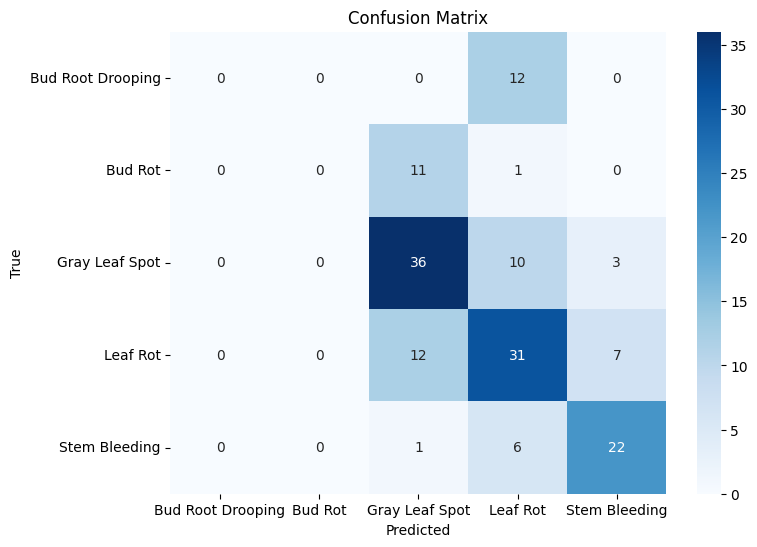

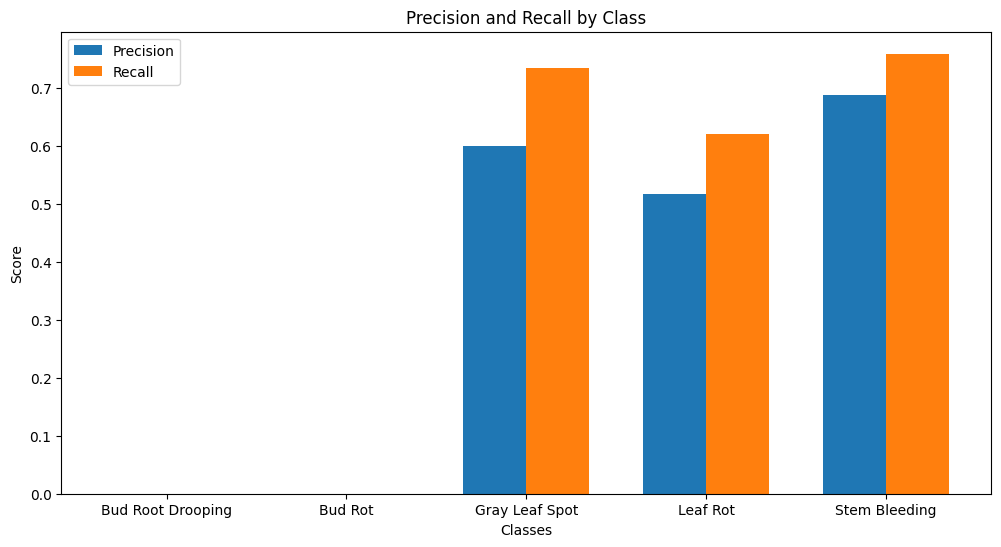

Epoch 5/10, Training Loss: 1.1223, Validation Accuracy: 0.5855
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.6000, Recall: 0.7347, F1 Score: 0.6606
Class: Leaf Rot, Precision: 0.5167, Recall: 0.6200, F1 Score: 0.5636
Class: Stem Bleeding, Precision: 0.6875, Recall: 0.7586, F1 Score: 0.7213
Train Epoch 6/10, Batch 1/38, Loss: 1.0817
Train Epoch 6/10, Batch 11/38, Loss: 0.9700
Train Epoch 6/10, Batch 21/38, Loss: 0.7443
Train Epoch 6/10, Batch 31/38, Loss: 1.1134


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


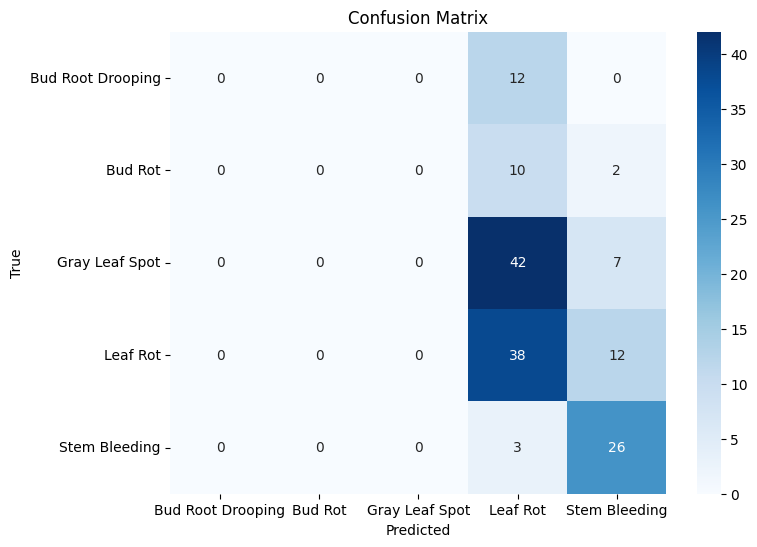

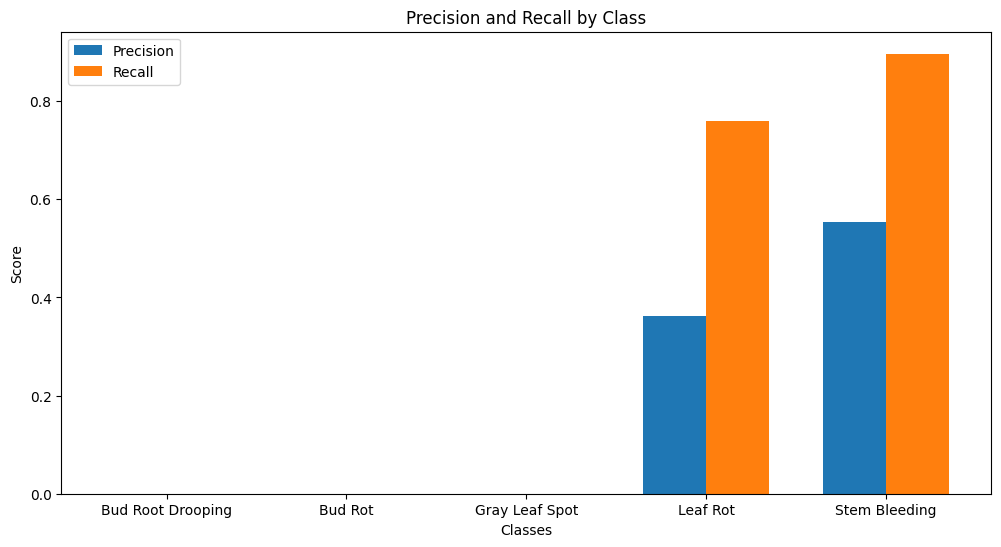

Epoch 6/10, Training Loss: 1.3114, Validation Accuracy: 0.4211
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Leaf Rot, Precision: 0.3619, Recall: 0.7600, F1 Score: 0.4903
Class: Stem Bleeding, Precision: 0.5532, Recall: 0.8966, F1 Score: 0.6842
Train Epoch 7/10, Batch 1/38, Loss: 1.4136
Train Epoch 7/10, Batch 11/38, Loss: 1.0126
Train Epoch 7/10, Batch 21/38, Loss: 1.6170
Train Epoch 7/10, Batch 31/38, Loss: 1.5249


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


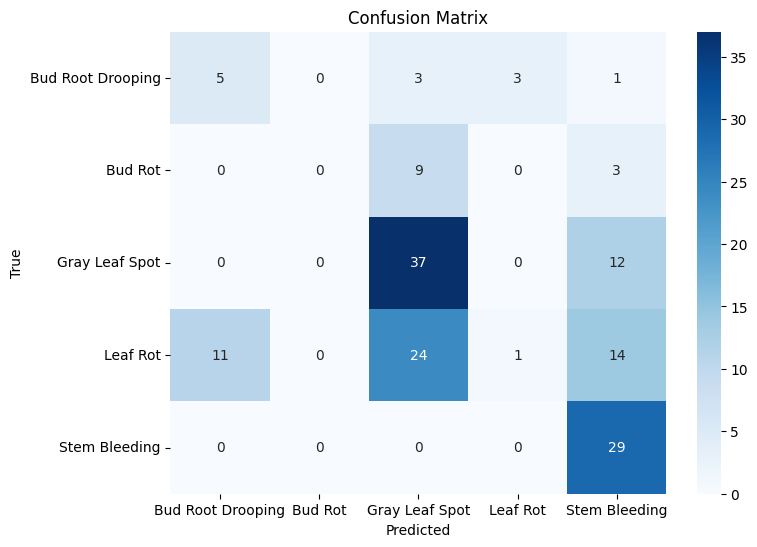

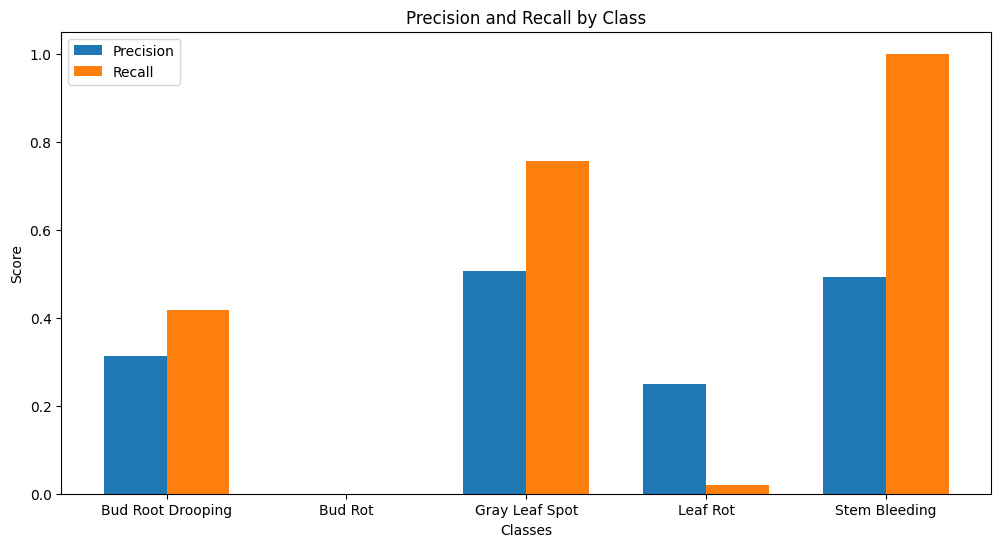

Epoch 7/10, Training Loss: 1.2873, Validation Accuracy: 0.4737
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.3125, Recall: 0.4167, F1 Score: 0.3571
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.5068, Recall: 0.7551, F1 Score: 0.6066
Class: Leaf Rot, Precision: 0.2500, Recall: 0.0200, F1 Score: 0.0370
Class: Stem Bleeding, Precision: 0.4915, Recall: 1.0000, F1 Score: 0.6591
Train Epoch 8/10, Batch 1/38, Loss: 1.2088
Train Epoch 8/10, Batch 11/38, Loss: 0.7953
Train Epoch 8/10, Batch 21/38, Loss: 1.6617
Train Epoch 8/10, Batch 31/38, Loss: 0.9605


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


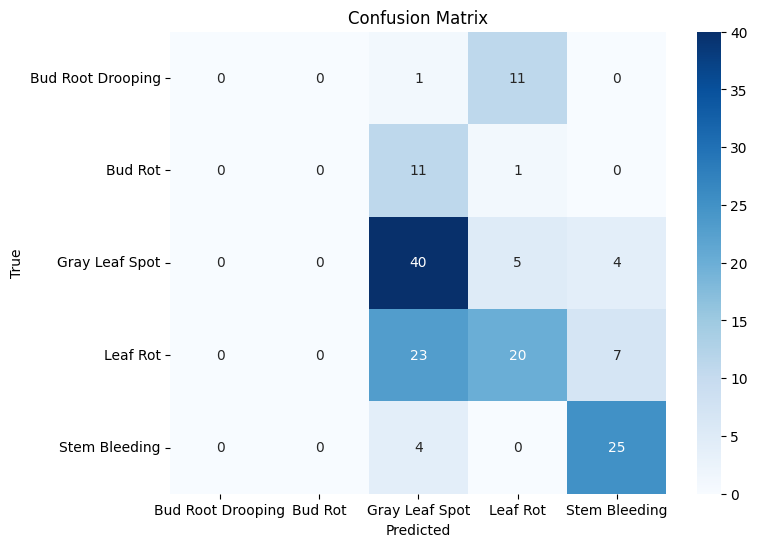

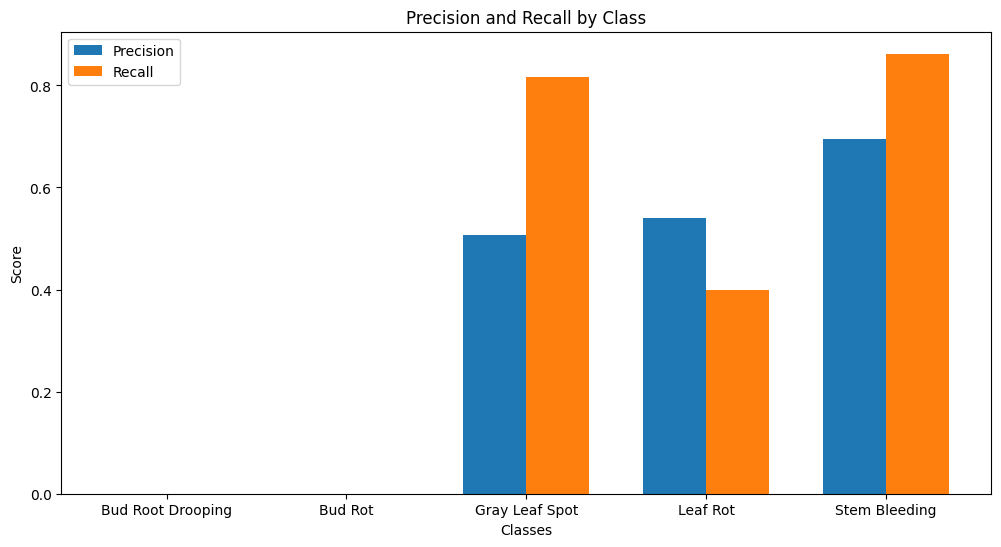

Epoch 8/10, Training Loss: 1.1763, Validation Accuracy: 0.5592
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.5063, Recall: 0.8163, F1 Score: 0.6250
Class: Leaf Rot, Precision: 0.5405, Recall: 0.4000, F1 Score: 0.4598
Class: Stem Bleeding, Precision: 0.6944, Recall: 0.8621, F1 Score: 0.7692
Train Epoch 9/10, Batch 1/38, Loss: 1.1534
Train Epoch 9/10, Batch 11/38, Loss: 1.2562
Train Epoch 9/10, Batch 21/38, Loss: 0.8202
Train Epoch 9/10, Batch 31/38, Loss: 0.8451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


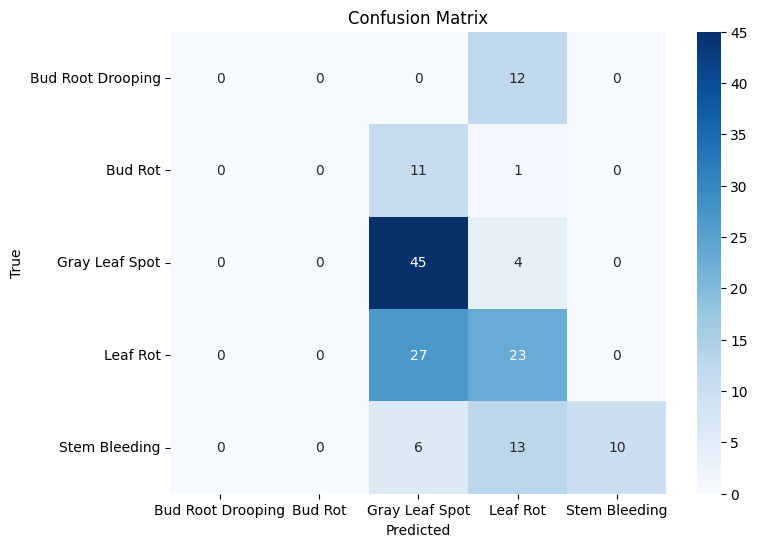

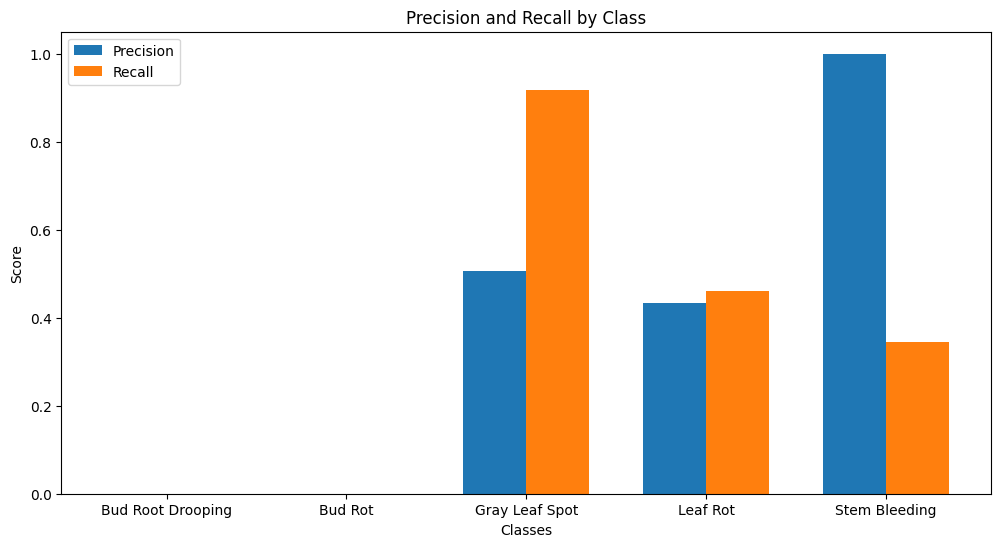

Epoch 9/10, Training Loss: 0.9791, Validation Accuracy: 0.5132
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.5056, Recall: 0.9184, F1 Score: 0.6522
Class: Leaf Rot, Precision: 0.4340, Recall: 0.4600, F1 Score: 0.4466
Class: Stem Bleeding, Precision: 1.0000, Recall: 0.3448, F1 Score: 0.5128
Train Epoch 10/10, Batch 1/38, Loss: 1.0450
Train Epoch 10/10, Batch 11/38, Loss: 0.4427
Train Epoch 10/10, Batch 21/38, Loss: 0.8741
Train Epoch 10/10, Batch 31/38, Loss: 0.6525


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


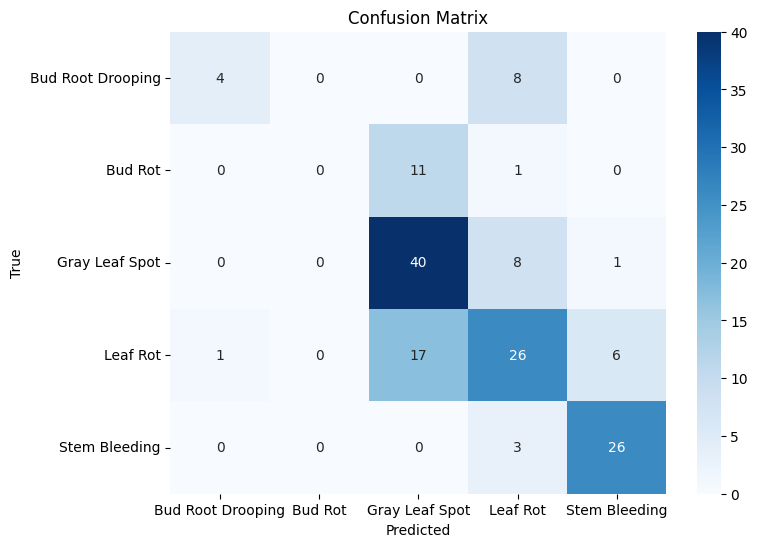

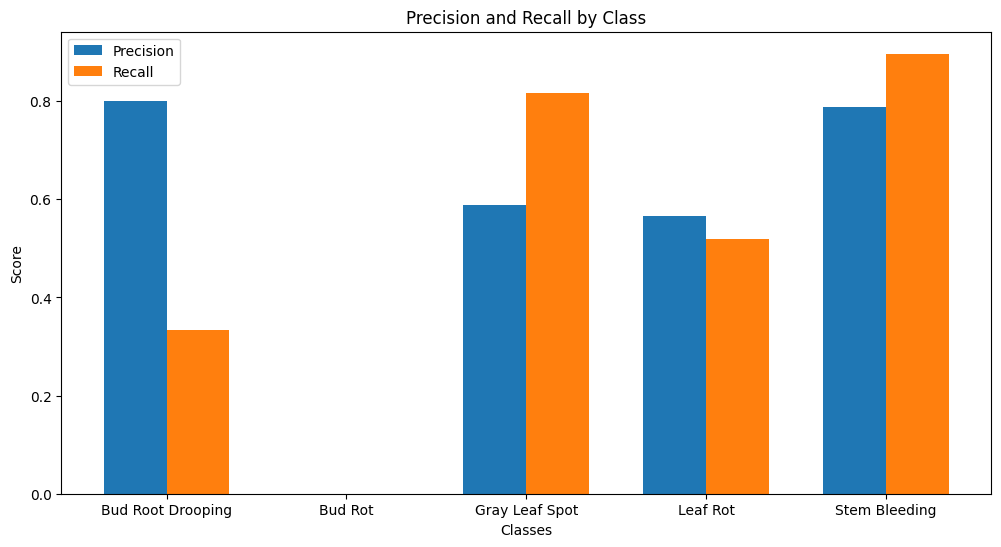

Epoch 10/10, Training Loss: 0.8858, Validation Accuracy: 0.6316
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.8000, Recall: 0.3333, F1 Score: 0.4706
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.5882, Recall: 0.8163, F1 Score: 0.6838
Class: Leaf Rot, Precision: 0.5652, Recall: 0.5200, F1 Score: 0.5417
Class: Stem Bleeding, Precision: 0.7879, Recall: 0.8966, F1 Score: 0.8387


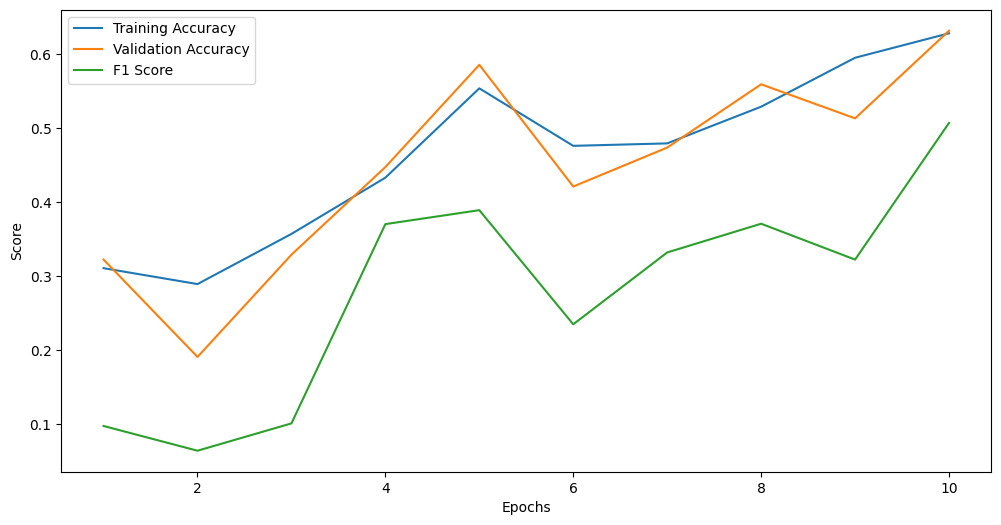

Total time taken for batched inference = 1797.0693111419678 ms


In [ ]:
class CustomDeiTModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomDeiTModel, self).__init__()
        self.deit = timm.create_model('deit3_small_patch16_224.fb_in1k', pretrained=True)
        # Modifies the classifier
        self.classifier = nn.Sequential(
            nn.Linear(1000, self.deit.num_features),
            nn.ReLU(),
            nn.Linear(self.deit.num_features, num_classes),
            )

    def forward(self, x):
        x = self.deit(x)
        x = self.classifier(x)
        return x


input_size = (224, 224)

# # Verify input size and num_classes
deit_model = CustomDeiTModel(num_classes=5).to(device)
# assert input_size == (deit_model.deit.default_cfg['input_size'][-1], deit_model.deit.default_cfg['input_size'][-1]), \
#     f"Input size mismatch: Expected {input_size}, but got {deit_model.deit.default_cfg['input_size']}"
# assert num_classes == deit_model.classifier.out_features, \
#     f"Number of classes mismatch: Expected {num_classes}, but got {deit_model.classifier.out_features}"

optimizer = optim.Adam(deit_model.parameters(), lr=0.001)
print(f"DeiT Model Global Pooling Output Size: {deit_model.deit.num_features}")
# print(f"Num Classes: {deit_model.classifier.out_features}")
train(deit_model, train_dataloader_swin, val_dataloader_swin, criterion, optimizer, num_epochs=10)

model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

Train Epoch 1/10, Batch 1/38, Loss: 2.3609
Train Epoch 1/10, Batch 11/38, Loss: 142.1776
Train Epoch 1/10, Batch 21/38, Loss: 136.6520
Train Epoch 1/10, Batch 31/38, Loss: 33.0632


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


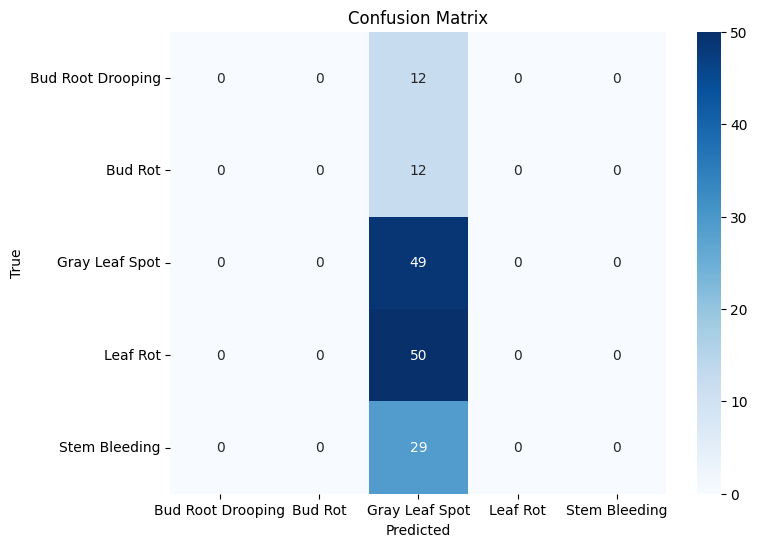

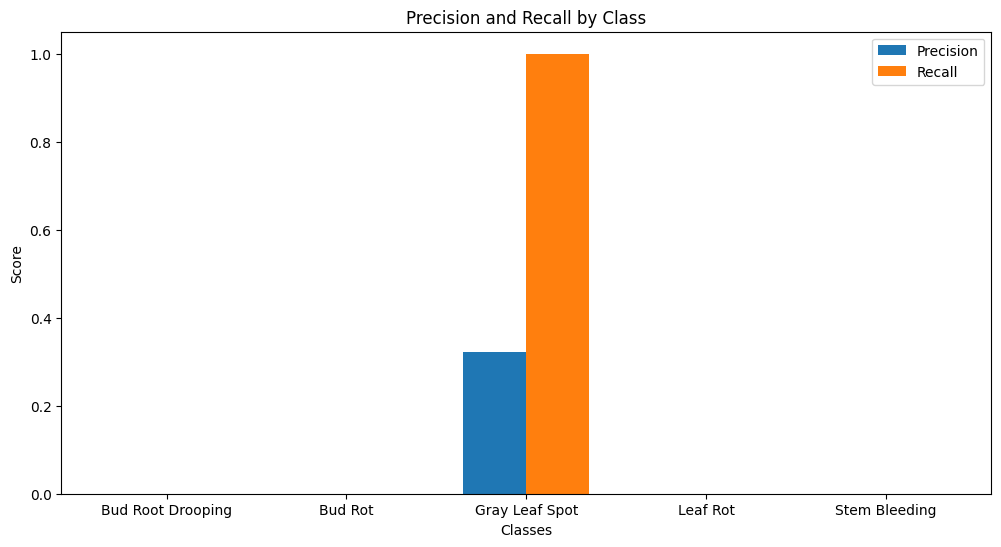

Epoch 1/10, Training Loss: 75.3027, Validation Accuracy: 0.3224
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3224, Recall: 1.0000, F1 Score: 0.4876
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Train Epoch 2/10, Batch 1/38, Loss: 19.7936
Train Epoch 2/10, Batch 11/38, Loss: 3.0046
Train Epoch 2/10, Batch 21/38, Loss: 2.0752


KeyboardInterrupt: 

In [ ]:
class CustomPTVModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomPTVModel, self).__init__()
        self.pvt = timm.create_model('vit_base_patch16_224.augreg_in21k', pretrained=True)
        # Modify the classifier
        self.classifier = nn.Sequential(
         nn.Linear(21843, self.pvt.num_features),
         nn.ReLU(),
         nn.Linear(self.pvt.num_features, num_classes),
        )

    def forward(self, x):
        x = self.pvt(x)
        x = self.classifier(x)
        return x


pvt_model = CustomPTVModel(num_classes=5).to(device)
optimizer = optim.Adam(pvt_model.parameters(), lr=0.001)

train(pvt_model, train_dataloader_swin, val_dataloader_swin, criterion, optimizer, num_epochs=10)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Train Epoch 1/5, Batch 1/38, Loss: 1.6999
Train Epoch 1/5, Batch 11/38, Loss: 1.5311
Train Epoch 1/5, Batch 21/38, Loss: 2.0112
Train Epoch 1/5, Batch 31/38, Loss: 1.3825


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


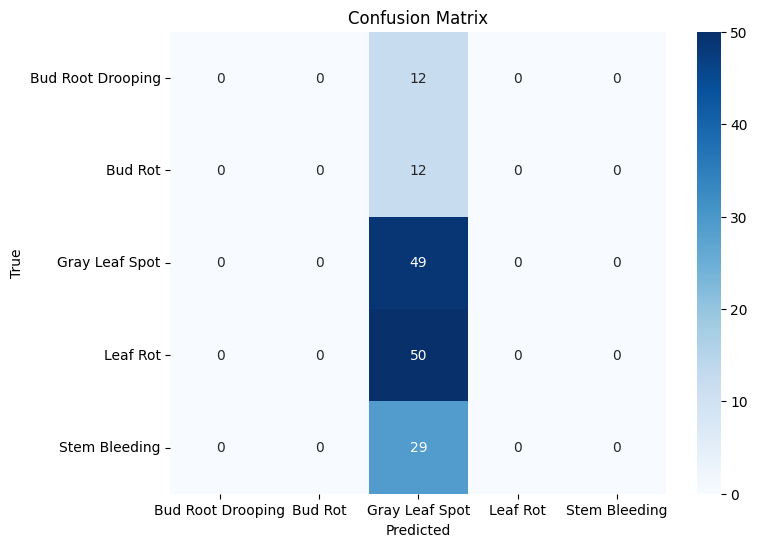

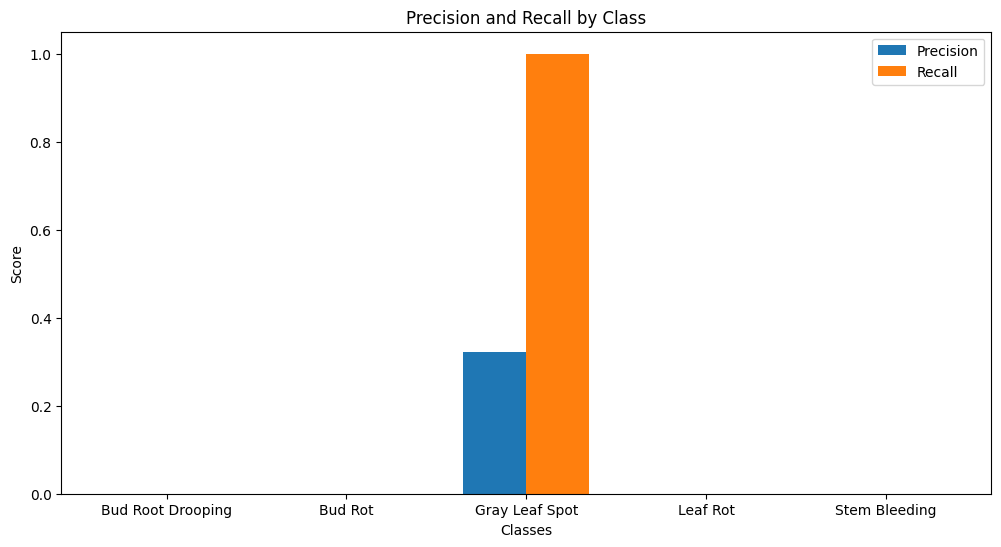

Epoch 1/5, Training Loss: 1.7854, Validation Accuracy: 0.3224
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3224, Recall: 1.0000, F1 Score: 0.4876
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Train Epoch 2/5, Batch 1/38, Loss: 1.3364
Train Epoch 2/5, Batch 11/38, Loss: 1.4504
Train Epoch 2/5, Batch 21/38, Loss: 1.3461
Train Epoch 2/5, Batch 31/38, Loss: 1.4769


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


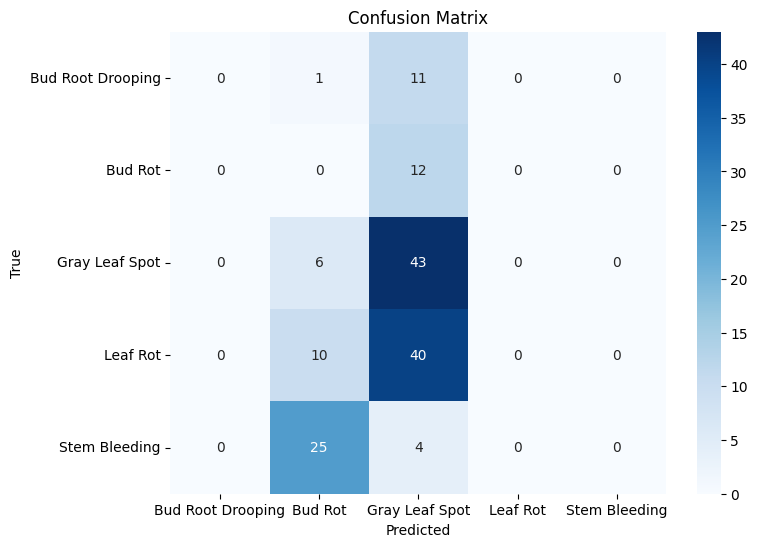

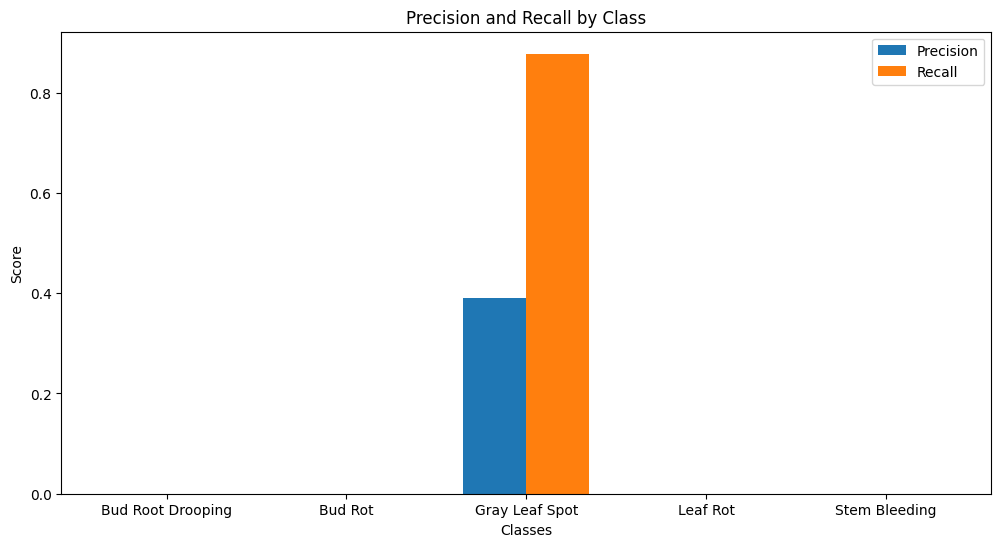

Epoch 2/5, Training Loss: 1.4854, Validation Accuracy: 0.2829
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3909, Recall: 0.8776, F1 Score: 0.5409
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Train Epoch 3/5, Batch 1/38, Loss: 1.5851
Train Epoch 3/5, Batch 11/38, Loss: 1.4242
Train Epoch 3/5, Batch 21/38, Loss: 1.6243
Train Epoch 3/5, Batch 31/38, Loss: 1.8449


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


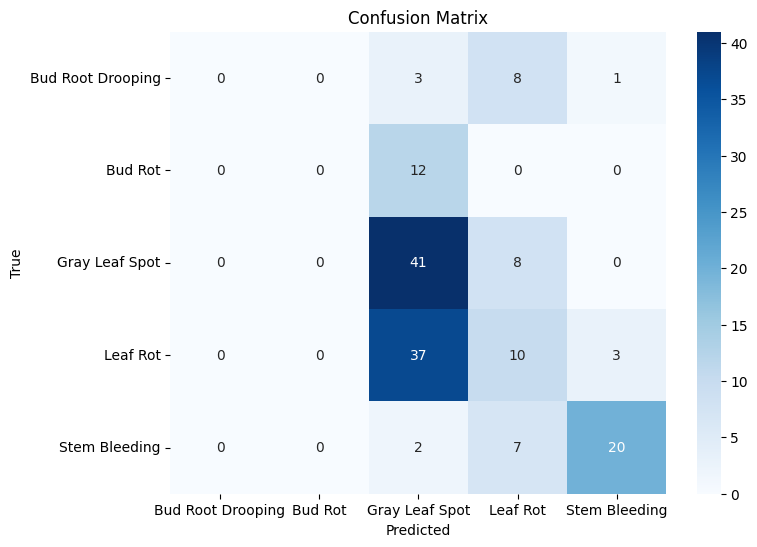

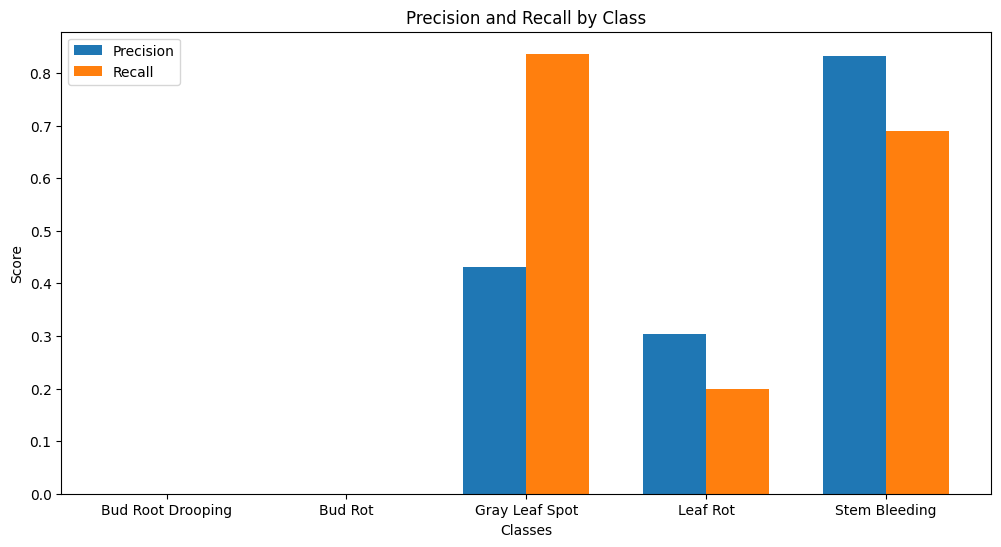

Epoch 3/5, Training Loss: 1.4799, Validation Accuracy: 0.4671
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.4316, Recall: 0.8367, F1 Score: 0.5694
Class: Leaf Rot, Precision: 0.3030, Recall: 0.2000, F1 Score: 0.2410
Class: Stem Bleeding, Precision: 0.8333, Recall: 0.6897, F1 Score: 0.7547
Train Epoch 4/5, Batch 1/38, Loss: 0.9874
Train Epoch 4/5, Batch 11/38, Loss: 0.8660
Train Epoch 4/5, Batch 21/38, Loss: 1.5736
Train Epoch 4/5, Batch 31/38, Loss: 1.4387


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


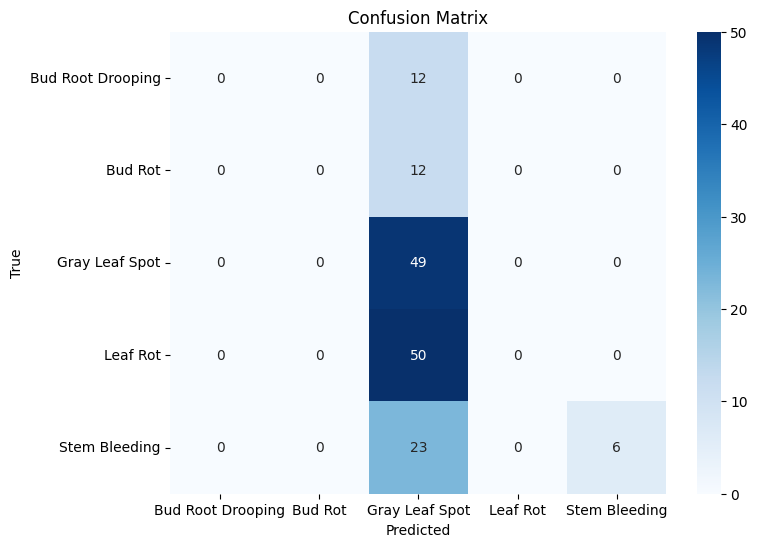

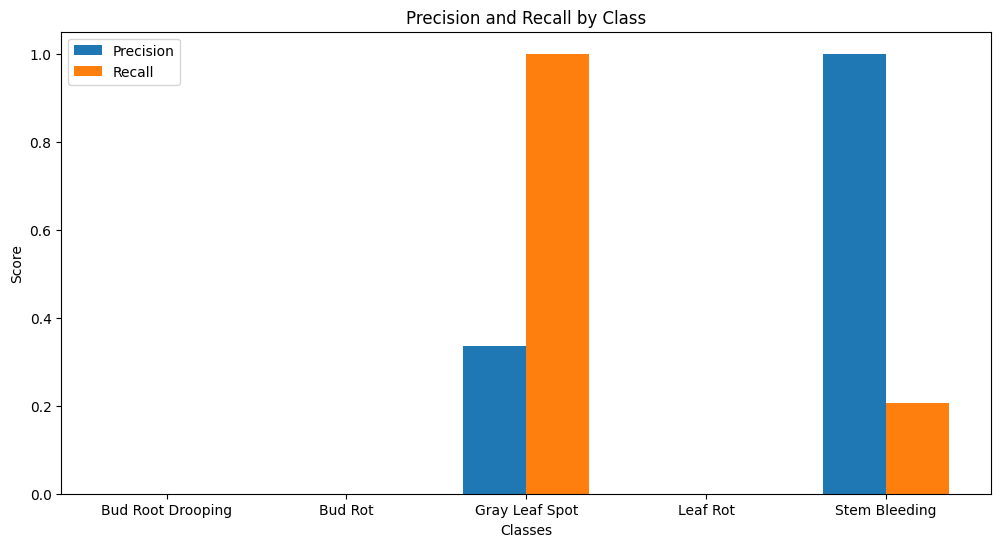

Epoch 4/5, Training Loss: 1.2426, Validation Accuracy: 0.3618
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3356, Recall: 1.0000, F1 Score: 0.5026
Class: Leaf Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Stem Bleeding, Precision: 1.0000, Recall: 0.2069, F1 Score: 0.3429
Train Epoch 5/5, Batch 1/38, Loss: 1.5340
Train Epoch 5/5, Batch 11/38, Loss: 0.9075
Train Epoch 5/5, Batch 21/38, Loss: 1.1384
Train Epoch 5/5, Batch 31/38, Loss: 1.4885


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


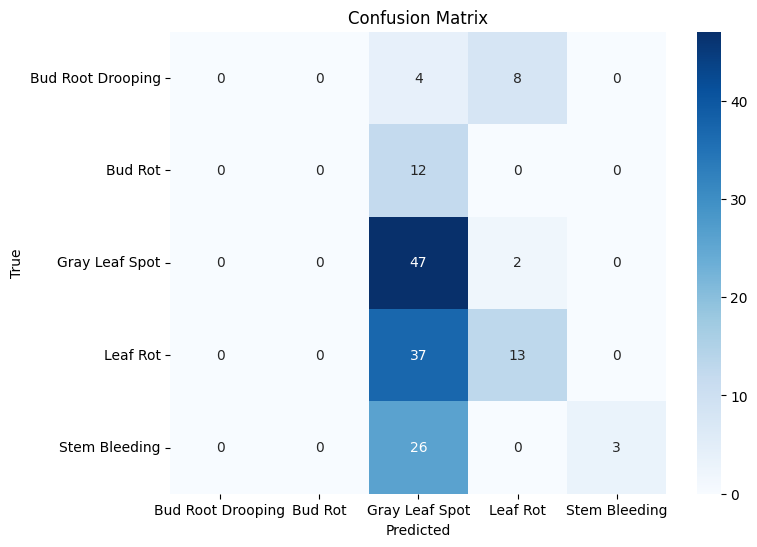

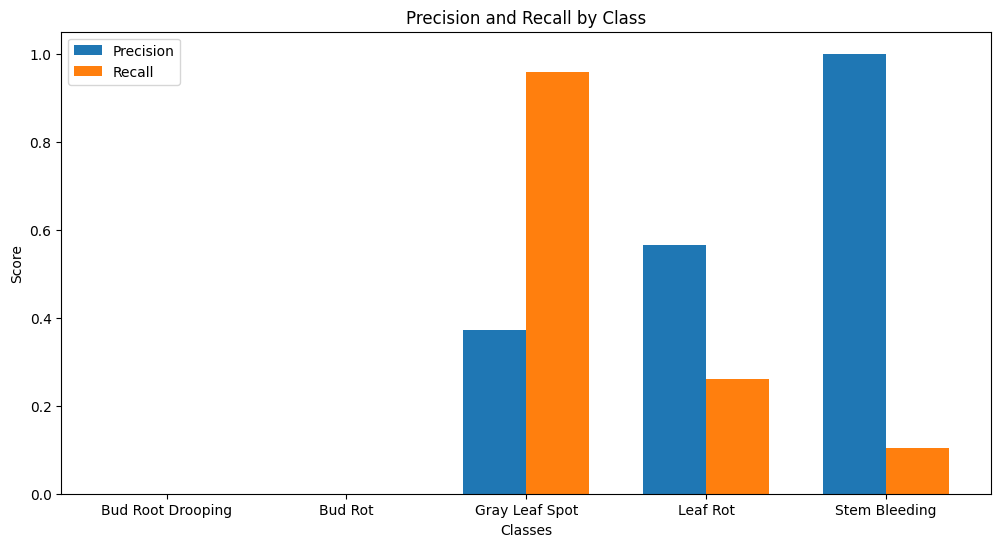

Epoch 5/5, Training Loss: 1.1672, Validation Accuracy: 0.4145
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.3730, Recall: 0.9592, F1 Score: 0.5371
Class: Leaf Rot, Precision: 0.5652, Recall: 0.2600, F1 Score: 0.3562
Class: Stem Bleeding, Precision: 1.0000, Recall: 0.1034, F1 Score: 0.1875


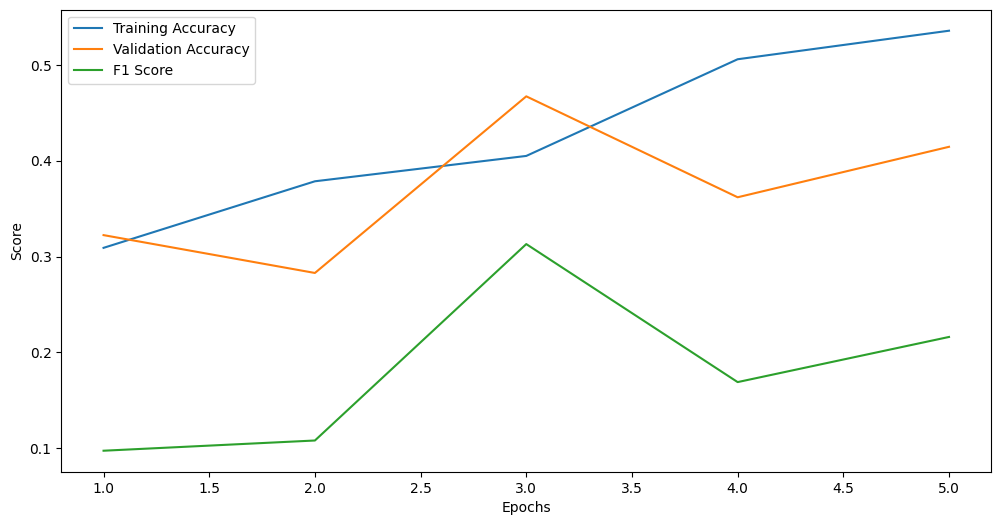

Total time taken for batched inference = 3406.719446182251 ms


In [ ]:
# custom Vision Transformer Model
class CustomVisionTransformerModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomVisionTransformerModel, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0, global_pool='avg')

        # Modifies the classifier
        self.classifier = nn.Linear(self.vit.num_features, num_classes)

    def forward(self, x):
        x = self.vit(x)
        x = self.classifier(x)
        return x

vit_model = CustomVisionTransformerModel(num_classes=5).to(device)
optimizer = optim.Adam(vit_model.parameters(), lr=lr)
train(vit_model, train_dataloader_swin, val_dataloader_swin, criterion, optimizer, num_epochs=5)